In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline
import scipy as sp
import scipy.sparse as sps
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from sklearn import neighbors


In [55]:
def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((200,2))
    y = np.zeros(200,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:] = np.random.multivariate_normal(mean2, cov2, 100)
    y[100:] = np.ones(100)
    return X,y,"Gaussian"

def generateXOR():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((400,2))
    y = np.zeros(400,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:200] = np.random.multivariate_normal(mean2, cov2, 100)
    
    
    mean3 = [2, -2]
    cov3 = [[1, 0], [0, 1]]  # diagonal covariance
    mean4 = [-2, 2]
    cov4 = [[1, 0], [0, 1]]  # diagonal covariance

    X[200:300] = np.random.multivariate_normal(mean3, cov3, 100)
    X[300:] = np.random.multivariate_normal(mean4, cov4, 100)
    y[200:] = np.ones(200)
    
    return X,y,"XOR"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros((2*size*EACH,2))
    y = np.zeros(2*size*EACH,dtype=int)
    y[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH)
        X[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH)
    return X,y,"Parabolas"

In [56]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plotData(X,y,dataName):
    num = len(np.unique(sorted(y)))
    for i in range(num):
        plt.plot(X[:,0][y==i], X[:,1][y==i], colors[i%8]+'o')
    plt.axis('equal')
#     plt.savefig(dataName+'.jpg')
    plt.show()




def Prototyping(X,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_
#     plotData(X,kmeans.labels_,"Two Gaussian")
    
    return centers
def distance2(p1,p2):
    ans = 0
    for i in xrange(p1.shape[0]):
        ans += (p1[i] - p2[i]) ** 2
    return ans
def similarity(p1,p2,sigma):
    return np.exp((-distance2(p1,p2))/(2*(sigma**2)))

In [57]:
def bipartiteUnsupervised(X,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    print numS,numP
    N = numS + numP
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

def bipartiteSupervised(X,y,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
    print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]

    P1 = np.sum(y)
    P2 = len(y) - P1
    for i in xrange(numS):
        W[i,numS+numP+y[i]] = 1.
        W[numS+numP+y[i],i] = 1.


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

def bipartite10Fold(X,y,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
    print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]

    kf = KFold(numS,n_folds=10,shuffle=True)
    for train_index,test_index in kf:
        break
    print "len train: ",len(train_index)
    P1 = np.sum(y)
    P2 = len(y) - P1
    for i in train_index:
        W[i,numS+numP+y[i]] = 1.
        W[numS+numP+y[i],i] = 1.


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

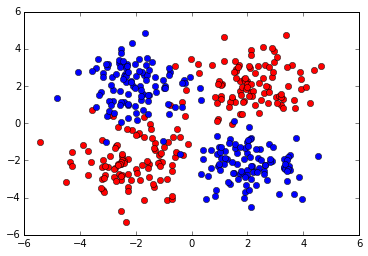

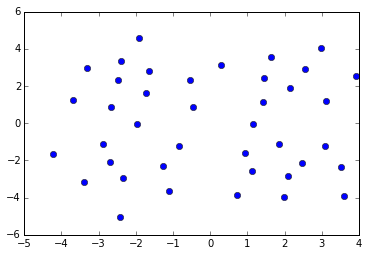

In [58]:
#supervisedBipartite10Fold
X,y,name = generateXOR()
plt.plot(X[:,0][y==0],X[:,1][y==0],'ro')
plt.plot(X[:,0][y==1],X[:,1][y==1],'bo')
plt.show()

numP = 40
centers = Prototyping(X,numP)
plt.plot(centers[:,0],centers[:,1],'bo')


400 40


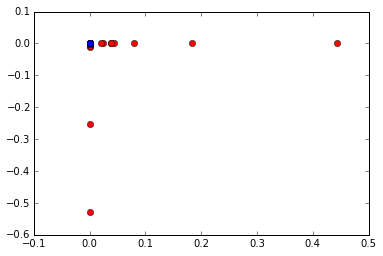

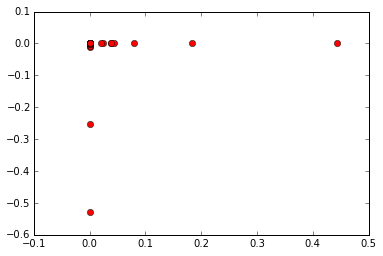

In [59]:
sigma = .1
numS = X.shape[0]

W,D,L = bipartiteUnsupervised(X,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=3)
vals = vals.real
vecs = vecs.real[:numS]
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.show()
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.show()

400 40 2


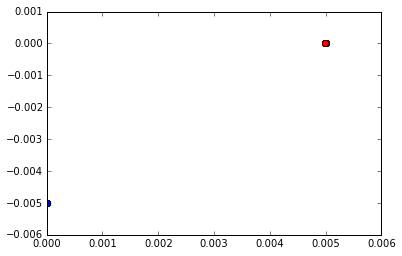

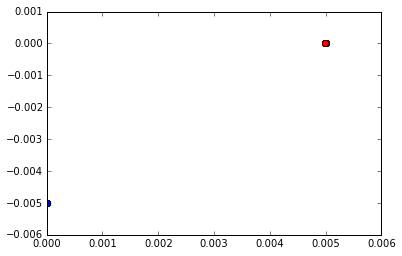

In [60]:
sigma = .1
numS = X.shape[0]

W,D,L = bipartiteSupervised(X,y,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=3)
vals = vals.real
vecs = vecs.real[:numS]
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.show()
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.show()

In [8]:

# sigma = 20

# for sigma in xrange(1,20):
#     print '=======================================================================',sigma
#     W,D,L = bipartite10Fold(X,y,centers,sigma)
#     vals, vecs = sps.linalg.eigs(L, M=D, k=7)
#     vals = vals.real
#     vecs = vecs.real[:numS]
#     for i in xrange(1,7,2):
#         print '------------------------------------------'+str(i),str(i+1)+'---------------'
#         plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#         plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#         plt.show()
#         plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#         plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#         plt.show()


In [9]:
# sigma = 6


# W,D,L = bipartite10Fold(X,y,centers,sigma)
# vals, vecs = sps.linalg.eigs(L, k=7)
# vals = vals.real
# vecs = vecs.real[:numS]
# for i in xrange(1,7,2):
#     print '------------------------------------------'+str(i),str(i+1)+'---------------'
#     plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#     plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#     plt.show()
#     plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#     plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#     plt.show()

In [10]:
# sigma = 6


# W,D,L = bipartite10Fold(X,y,centers,sigma)
# d = np.array(W.sum(axis=0))
# d12 = d**(-.5)
# D12 = sps.diags(d,[0])
# Ln = D12.dot(L.dot(D12))
# vals, vecs = sps.linalg.eigs(L, k=7)
# vals = vals.real
# vecs = vecs.real[:numS]
# for i in xrange(1,7,2):
#     print '------------------------------------------'+str(i),str(i+1)+'---------------'
#     plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#     plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#     plt.show()
#     plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
#     plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
#     plt.show()

<h1 style="color:purple">Load datasets</h1>

In [61]:
# wine  -------------------------------------------------------------------------------------------------
def loadWine():
    wineData = pd.read_csv('data/wine.data',header=None)
    wineY = wineData[0].apply(lambda x: x-1).values
    wineX = wineData.drop(0,axis=1)
    wineX = wineX.values
    return wineX,wineY

# wine  -------------------------------------------------------------------------------------------------
def loadWineNorm():
    wineData = pd.read_csv('data/wine.data',header=None)
    wineY = wineData[0].apply(lambda x: x-1).values
    wineX = wineData.drop(0,axis=1)
    wineX = wineX.values
    wineX = (wineX - wineX.mean(axis=0))/(wineX.max(axis=0)-wineX.min(axis=0))
    return wineX,wineY


# glass  -------------------------------------------------------------------------------------------------
def loadGlass():
    glassData = pd.read_csv('data/glass.data',header=None)
    glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
    glassX = glassData.drop([0,10],axis=1)
    glassX = glassX.values
    return glassX,glassY
    
# sonar  -------------------------------------------------------------------------------------------------
def loadSonar():
    sonarData = pd.read_csv('data/sonar.data',header=None)
    sonarY = (sonarData[60].apply(lambda x: 0 if x=='M' else 1)).values
    sonarX = sonarData.drop(60,axis=1)
    sonarX = sonarX.values
    return sonarX,sonarY

# iris  -------------------------------------------------------------------------------------------------
def irisLableSet(name):
    names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    for i in xrange(3):
        if names[i] == name:
            return i
def loadIris():
    irisData = pd.read_csv('data/iris.data',header=None)
    irisY = irisData[4].apply(irisLableSet).values
    irisX = irisData.drop(4,axis=1)
    irisX = irisX.values
    return irisX,irisY
    
# mnist   -------------------------------------------------------------------------------------------------
import scipy.io
def loadMnist():
    mnist = scipy.io.loadmat('data/mnistAll.mat')
    trains = []
    labels = []
    tests = []
    for i in range(10):
        trains.append(mnist['train'+str(i)])
        num = mnist['train'+str(i)].shape[0]
        labels.append(i*np.ones(num,dtype=int))
    mnistX = np.concatenate(trains)
    mnistY = np.concatenate(labels)
    return mnistX,mnistY
    
# breast cancer  -------------------------------------------------------------------------------------------------
def loadWdbc():
    wdbcData = pd.read_csv('data/wdbc.data',header=None)
    wdbcY = (wdbcData[1].apply(lambda x: 0 if x=='M' else 1)).values
    wdbcX = wdbcData.drop([0,1],axis=1)
    wdbcX = wdbcX.values
    return wdbcX,wdbcY

# usps   -------------------------------------------------------------------------------------------------
def loadUsps():
    with open('data/usps/usps_train.jf','r') as f:
        i = 0
        lines = f.readlines()
        uspsX = np.zeros((len(lines),256))
        uspsY = np.zeros(len(lines),dtype=int)
        for line in lines:
            splitedLine = line.split()
            features = map(float,splitedLine[1:])
            uspsY[i] = int(splitedLine[0])
            for j in xrange(256):
                uspsX[i,j] = features[j]
            i += 1
    return uspsX,uspsY

# waveform  -------------------------------------------------------------------------------------------------
def loadWaveform():
    waveformData = pd.read_csv('data/waveForm/waveform.data',header=None)
    waveformY = waveformData[21].values
    waveformX = waveformData.drop(21,axis=1)
    waveformX = waveformX.values
    return waveformX,waveformY   

In [62]:
def bipartite10Fold2(X,y,centers,sigma,train_index,test_index):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
#     print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
#     print "len train: ",len(train_index)
    P = []
    for i in xrange(numL):
        P.append(sum(y==i))
        
    for i in train_index:
        W[i,numS+numP+y[i]] = 1./P[y[i]]
        W[numS+numP+y[i],i] = 1./P[y[i]]


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L
def supervised10FoldRepresentation(X,y,sigma):
    numP = 40
    labels = np.unique(sorted(y))
    centers = Prototyping(X,numP)
    numS = X.shape[0]
    kf = KFold(numS,n_folds=10,shuffle=True)
    fi = 0
    for train_index,test_index in kf:
        print "fold number:",fi
        fi += 1
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTr = y[train_index]
        yTe = y[test_index]
        for i in xrange(1,7,2):
            print '------------------------------------------'+str(i),str(i+1)+'---------------'
            for c in labels:
                plt.plot(vecs[:,i][train_index][yTr==c],vecs[:,i+1][train_index][yTr==c],colors[c%8]+'o')
            plt.show()
            for c in labels:
                plt.plot(vecs[:,i][test_index][yTe==c],vecs[:,i+1][test_index][yTe==c],colors[c%8]+'x')
            plt.show()


In [63]:
def supervised10Fold(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc), np.std(acc)  
def supervised10FoldClf(X,y,numP,sigma,clf):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        clf.fit(newRepTrain,yTrain)
        XPred = clf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
        i += 1
    return np.mean(acc), np.std(acc)  

<h1 style="color:purple">Proposed 10 Fold</h1>

In [64]:
X,y,name = generateXOR()
for numP in xrange(10,41,10):
    print '-----------------------------------------------------numP:',numP
    t = supervised10Fold(X,y,numP,1)
    print "accuracy:",t
# supervised10FoldRepresentation(X,y,sigma)

-----------------------------------------------------numP: 10
accuracy: (0.95250000000000001, 0.03249999999999998)
-----------------------------------------------------numP: 20
accuracy: (0.95499999999999985, 0.026925824035672508)
-----------------------------------------------------numP: 30


KeyboardInterrupt: 

In [66]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

X,y,name = generateXOR()
clf = neighbors.KNeighborsClassifier(n_neighbors=2)
clf = OneVsOneClassifier(LinearSVC(random_state=0))
for numP in xrange(10,41,10):
    print '-----------------------------------------------------numP:',numP
    t = supervised10FoldClf(X,y,numP,1,clf)
    print "accuracy:",t
# supervised10FoldRepresentation(X,y,sigma)

-----------------------------------------------------numP: 10
accuracy: (0.94499999999999995, 0.031224989991991973)
-----------------------------------------------------numP: 20
accuracy: (0.94000000000000006, 0.025495097567963899)
-----------------------------------------------------numP: 30
accuracy: (0.94500000000000006, 0.026925824035672501)
-----------------------------------------------------numP: 40
accuracy: (0.94750000000000001, 0.039449334595148738)


In [67]:
def runP(X,Y):
    Means = np.zeros(20)
    for numP in xrange(20,61,5):
        print wineX.shape
        Means[numP/5-4] = supervised10Fold(X,Y,numP,2)
        # supervised10FoldRepresentation(wineX,wineY,1)
    return Means

def runSigma(X,Y,sigmas,clf):
    Stds = np.zeros(len(sigmas))
    Means = np.zeros(len(sigmas))
    numP = 30
    idx = 0
    for sigma in sigmas:
#         print '--------------------------------------- sigma: ',sigma
        try:
            Means[idx],Stds[idx] = supervised10FoldClf(X,Y,numP,sigma,clf)
        except Exception as e:
            print e
        idx += 1
#         Means[idx] = supervised10FoldRepresentation(wineX,wineY,1)
    return Means,Stds

In [68]:
def run10Fold(X,y,sigmas,clf):
    result = []
    resultStd = []
    for i in xrange(10):
        Means,Stds = runSigma(X,y,sigmas,clf)
        result.append(Means.max())
        resultStd.append(Stds[Means.argmax()])
        print i , Means.max(),Stds[Means.argmax()]
    return result,resultStd

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

sigmas = [.09,.1,.11,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,1]
wineX,wineY = loadWineNorm()
# clf = neighbors.KNeighborsClassifier(n_neighbors=2)
# clf = GaussianNB()
clf = OneVsOneClassifier(SVC(kernel='rbf'))

wineResult,wineResultStd = run10Fold(wineX,wineY,sigmas,clf)

0 0.937908496732 0.0530379169377
1 0.927124183007 0.0663817119081
2 0.955555555556 0.0415739709642
3 0.916013071895 0.0797954634649
4 0.971895424837 0.0375233989396
5 0.933006535948 0.0647397085941
6 0.949346405229 0.0390040586047
7 0.943137254902 0.0775026715898
8 0.966666666667 0.0368513865595
9 0.954901960784 0.0485995070458


In [71]:
wineResult, wineResultStd

([0.93790849673202614,
  0.92712418300653598,
  0.95555555555555549,
  0.9160130718954248,
  0.97189542483660118,
  0.93300653594771243,
  0.94934640522875813,
  0.94313725490196065,
  0.96666666666666679,
  0.95490196078431366],
 [0.05303791693769503,
  0.066381711908108917,
  0.041573970964154924,
  0.079795463464890415,
  0.037523398939627008,
  0.064739708594137649,
  0.039004058604679009,
  0.077502671589758237,
  0.036851386559504457,
  0.048599507045807323])

In [72]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
irisX,irisY = loadIris()
irisResult,irisResultStd = run10Fold(irisX,irisY,sigmas,clf)

Factor is exactly singular
Factor is exactly singular
0 0.92 0.0884433277428
Factor is exactly singular
Factor is exactly singular
1 0.893333333333 0.08
Factor is exactly singular
Factor is exactly singular
2 0.833333333333 0.130809445802
Factor is exactly singular
Factor is exactly singular
3 0.8 0.190904280844
Factor is exactly singular
Factor is exactly singular
4 0.82 0.103494497975
Factor is exactly singular
Factor is exactly singular
5 0.886666666667 0.107703296143
Factor is exactly singular
Factor is exactly singular
6 0.873333333333 0.0916515138991
Factor is exactly singular
Factor is exactly singular
7 0.826666666667 0.155492050529
Factor is exactly singular
Factor is exactly singular
8 0.913333333333 0.0669991708075
Factor is exactly singular
Factor is exactly singular
ARPACK error -1: No convergence (1831 iterations, 6/7 eigenvectors converged)
9 0.873333333333 0.172433562085


In [73]:
irisResult,irisResultStd

([0.91999999999999993,
  0.89333333333333331,
  0.83333333333333337,
  0.80000000000000004,
  0.82000000000000006,
  0.88666666666666671,
  0.87333333333333329,
  0.82666666666666655,
  0.91333333333333333,
  0.87333333333333341],
 [0.088443327742810676,
  0.079999999999999988,
  0.1308094458023239,
  0.19090428084368474,
  0.10349449797506684,
  0.1077032961426901,
  0.091651513899116813,
  0.15549205052920803,
  0.066999170807472586,
  0.17243356208503416])

In [74]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
glassResult,glassResultStd = run10Fold(glassX,glassY,sigmas,clf)

0 0.356060606061 0.114662446431
1 0.355844155844 0.0807402828348
2 0.355844155844 0.0910645959219
3 0.356060606061 0.0572775697939
4 0.355627705628 0.0957730450231
5 0.355411255411 0.122311801999
6 0.355411255411 0.0770076211967
7 0.356060606061 0.0788262239594
8 0.356493506494 0.0816740410158
9 0.356060606061 0.0756291428336


In [75]:
glassResult,glassResultStd

([0.35606060606060608,
  0.35584415584415585,
  0.35584415584415585,
  0.35606060606060608,
  0.35562770562770563,
  0.35541125541125546,
  0.35541125541125546,
  0.35606060606060608,
  0.35649350649350647,
  0.35606060606060608],
 [0.1146624464308284,
  0.080740282834778493,
  0.091064595921922203,
  0.057277569793936112,
  0.095773045023094222,
  0.12231180199894391,
  0.077007621196745937,
  0.078826223959437849,
  0.081674041015758383,
  0.075629142833574886])

In [76]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
wdbcResult,wdbcResultStd = run10Fold(wdbcX,wdbcY,sigmas,clf)

0 0.913909774436 0.0240395823741
1 0.926221804511 0.0203644929343
2 0.922713032581 0.0305145081561
3 0.917418546366 0.0248136122632
4 0.896365914787 0.0226262493829
5 0.929605263158 0.0387413797638
6 0.90507518797 0.0263385299764
7 0.91914160401 0.032576166551
8 0.905231829574 0.0423396779232
9 0.924404761905 0.0273099773785


In [77]:
wdbcResult,wdbcResultStd

([0.91390977443609012,
  0.92622180451127822,
  0.92271303258145365,
  0.9174185463659148,
  0.89636591478696737,
  0.92960526315789471,
  0.9050751879699247,
  0.91914160401002509,
  0.90523182957393489,
  0.92440476190476206],
 [0.024039582374057383,
  0.020364492934303029,
  0.030514508156080228,
  0.024813612263166654,
  0.022626249382872162,
  0.038741379763785479,
  0.02633852997640683,
  0.03257616655097504,
  0.042339677923239769,
  0.027309977378545763])

In [78]:
# sigmas = [.5,1,1.5,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,10]
# uspsX,uspsY = loadUsps()
# uspsResult,uspsResultStd = run10Fold(uspsX,uspsY,sigmas,clf)
uspsResultStd=[ 0.0093503090041, 0.0135689789358,
         0.0114084437433, 0.00864490668976]
uspsResult = [0.859276922788,0.86312193472,
            0.862296446624,0.860513557698]

In [79]:
uspsResult,uspsResultStd

([0.859276922788, 0.86312193472, 0.862296446624, 0.860513557698],
 [0.0093503090041, 0.0135689789358, 0.0114084437433, 0.00864490668976])

In [80]:
sigmas = [.2,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,2.5,3,4,5,7,8,10]
waveformX,waveformY= loadWaveform()
waveformResult,waveformResultStd = run10Fold(waveformX,waveformY,sigmas,clf)

0 0.8322 0.0101764433866
1 0.8342 0.0106376689176
2 0.8382 0.0141265707091
3 0.8344 0.0102683981224
4 0.8388 0.0161046577114
5 0.8298 0.0155807573628
6 0.8358 0.0154
7 0.8344 0.0133506554146
8 0.8372 0.0204391780657
9 0.8322 0.015503547981


In [81]:
waveformResult,waveformResultStd

([0.83219999999999994,
  0.83419999999999983,
  0.83819999999999995,
  0.83439999999999992,
  0.83879999999999999,
  0.82979999999999998,
  0.83579999999999988,
  0.83439999999999992,
  0.83719999999999994,
  0.83220000000000005],
 [0.01017644338656685,
  0.01063766891757777,
  0.014126570709128256,
  0.010268398122394757,
  0.016104657711357929,
  0.015580757362849853,
  0.015400000000000014,
  0.013350655414622922,
  0.020439178065665944,
  0.015503547981026771])

In [82]:
sigmas = [1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonResult,moonResultStd = run10Fold(moonX,moonY,sigmas,clf)

0 0.495 0.114455231423
1 0.55875 0.174736408627
2 0.54875 0.186953369855
3 0.535 0.145752358471
4 0.54125 0.129909824494
5 0.5725 0.214752764825
6 0.5175 0.165
7 0.5125 0.16592543506
8 0.56375 0.219690833901
9 0.505 0.160292701019


In [83]:
moonResult,moonResultStd

([0.49500000000000011,
  0.55874999999999997,
  0.54874999999999996,
  0.53499999999999992,
  0.5412499999999999,
  0.57250000000000001,
  0.51749999999999996,
  0.51249999999999996,
  0.56374999999999997,
  0.505],
 [0.11445523142259595,
  0.17473640862739512,
  0.18695336985462443,
  0.1457523584714841,
  0.12990982449376182,
  0.21475276482504246,
  0.16500000000000001,
  0.16592543506045118,
  0.21969083390073424,
  0.16029270101910442])

In [84]:
sigmas = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,5]
xorX,xorY,tmp = generateXOR()
xorResult,xorResultStd = run10Fold(xorX,xorY,sigmas,clf)

0 0.9325 0.0354436171969
1 0.935 0.0435889894354
2 0.92 0.0471699056603
3 0.9375 0.0230488611432
4 0.9075 0.0388104367407
5 0.945 0.0291547594742
6 0.93 0.0415331193146
7 0.9325 0.0447911821679
8 0.915 0.0476969600708
9 0.9225 0.0564025708634


In [85]:
xorResult,xorResultStd

([0.93250000000000011,
  0.93499999999999994,
  0.91999999999999993,
  0.9375,
  0.90749999999999997,
  0.94499999999999995,
  0.93000000000000005,
  0.93249999999999988,
  0.91500000000000004,
  0.92249999999999999],
 [0.035443617196894546,
  0.043588989435406726,
  0.047169905660283021,
  0.023048861143232194,
  0.038810436740650052,
  0.02915475947422649,
  0.041533119314590361,
  0.044791182167922293,
  0.047696960070847276,
  0.056402570863392398])

In [86]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    X = concentric['X'][:,[0,1]]
    Y = concentric['Y'][:,0]
    Y = (Y==1)
    return X,Y,"Concentric"

In [87]:
sigmas = [.4,.5,.7,.8,.9,1,1.1,1.2,1.3,1.5]
concentricX,concentricY,tmp = generateConcentric()
concentricResult,concentricResultStd = run10Fold(concentricX,concentricY,sigmas,clf)

0 0.754334677419 0.0660694589304
1 0.754637096774 0.110183987885
2 0.754133064516 0.0666733139381
3 0.754133064516 0.0749480205976
4 0.754435483871 0.0604640424487
5 0.754637096774 0.0848155555304
6 0.754233870968 0.0767941404692
7 0.754838709677 0.0631788703128
8 0.754233870968 0.0596119955244
9 0.754435483871 0.097118214129


In [88]:
concentricResult,concentricResultStd

([0.75433467741935489,
  0.75463709677419355,
  0.75413306451612905,
  0.75413306451612905,
  0.75443548387096782,
  0.75463709677419355,
  0.75423387096774186,
  0.75483870967741939,
  0.75423387096774197,
  0.75443548387096782],
 [0.066069458930400518,
  0.110183987885102,
  0.066673313938135984,
  0.074948020597566389,
  0.06046404244871801,
  0.084815555530442441,
  0.076794140469216968,
  0.063178870312836727,
  0.05961199552443977,
  0.097118214129012587])

In [89]:
sigmas = [.03,0.04,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]
sonarX,sonarY= loadSonar()
sonarResult,sonarResultStd = run10Fold(sonarX,sonarY,sigmas,clf)

Factor is exactly singular
0 0.788095238095 0.101127431341
Factor is exactly singular
1 0.712619047619 0.0961388947036
Factor is exactly singular
2 0.813095238095 0.0678069990167
Factor is exactly singular
3 0.764285714286 0.0622699849077
Factor is exactly singular
4 0.73119047619 0.0511594590416
Factor is exactly singular
5 0.725952380952 0.0909290047247
Factor is exactly singular
6 0.721904761905 0.102379844955
Factor is exactly singular
7 0.798333333333 0.111889816631
Factor is exactly singular
8 0.715476190476 0.0761551257277
Factor is exactly singular
9 0.72119047619 0.112124657304


In [90]:
sonarResult,sonarResultStd

([0.78809523809523818,
  0.71261904761904771,
  0.81309523809523809,
  0.76428571428571423,
  0.73119047619047617,
  0.7259523809523809,
  0.72190476190476183,
  0.79833333333333323,
  0.71547619047619038,
  0.72119047619047616],
 [0.10112743134093001,
  0.096138894703600222,
  0.067806999016666841,
  0.06226998490772391,
  0.05115945904163869,
  0.090929004724712326,
  0.10237984495525096,
  0.11188981663118244,
  0.076155125727709064,
  0.11212465730386961])

<h1 style="color:red">------------------------------------------------------------------------------------------</h1>

In [62]:
def supervised5Fold(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=5,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc) 

In [63]:
def runSigma5Fold(X,Y,sigmas):
    Means = np.zeros(len(sigmas))
    numP = 30
    idx = 0
    for sigma in sigmas:
#         print '--------------------------------------- sigma: ',sigma
        try:
            Means[idx] = supervised5Fold(X,Y,numP,sigma)
        except Exception as e:
            print e
        idx += 1
#         Means[idx] = supervised10FoldRepresentation(wineX,wineY,1)
    return Means

In [64]:
wineX,wineY = loadWine()
resultWine5 = []
sigmas = [10,15,20,25,30,35,40,45,50,55,60,65,70,75]
for i in xrange(20):
    wineMeans = runSigma5Fold(wineX,wineY,sigmas)
    resultWine5.append(wineMeans.max())
    print i , wineMeans.max()

0 0.719206349206
1 0.701746031746
2 0.70253968254
3 0.71380952381
4 0.707619047619
5 0.696825396825
6 0.70746031746
7 0.719047619048
8 0.702380952381
9 0.719841269841
10 0.708253968254
11 0.697301587302
12 0.718571428571
13 0.70253968254
14 0.69619047619
15 0.706984126984
16 0.713015873016
17 0.70253968254
18 0.701746031746
19 0.702063492063


In [65]:
resultWine5

[0.71920634920634918,
 0.70174603174603178,
 0.70253968253968258,
 0.71380952380952378,
 0.7076190476190477,
 0.69682539682539679,
 0.70746031746031746,
 0.71904761904761894,
 0.70238095238095233,
 0.71984126984126973,
 0.70825396825396825,
 0.69730158730158731,
 0.71857142857142864,
 0.70253968253968258,
 0.69619047619047625,
 0.70698412698412694,
 0.7130158730158731,
 0.70253968253968258,
 0.70174603174603178,
 0.70206349206349206]

In [66]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
irisX,irisY = loadIris()
resultIris5 = []
for i in xrange(20):
    irisMeans = runSigma5Fold(irisX,irisY,sigmas)
    resultIris5.append(irisMeans.max())
    print i , irisMeans.max()

Factor is exactly singular
Factor is exactly singular
0 0.973333333333
Factor is exactly singular
Factor is exactly singular
1 0.953333333333
Factor is exactly singular
Factor is exactly singular
2 0.966666666667
Factor is exactly singular
Factor is exactly singular
3 0.966666666667
Factor is exactly singular
Factor is exactly singular
4 0.966666666667
Factor is exactly singular
Factor is exactly singular
5 0.966666666667
Factor is exactly singular
Factor is exactly singular
6 0.973333333333
Factor is exactly singular
Factor is exactly singular
7 0.96
Factor is exactly singular
Factor is exactly singular
8 0.973333333333
Factor is exactly singular
Factor is exactly singular
9 0.96
Factor is exactly singular
Factor is exactly singular
10 0.96
Factor is exactly singular
Factor is exactly singular
11 0.966666666667
Factor is exactly singular
Factor is exactly singular
12 0.98
Factor is exactly singular
Factor is exactly singular
13 0.966666666667
Factor is exactly singular
Factor is exact

In [67]:
resultIris5

[0.97333333333333338,
 0.95333333333333337,
 0.96666666666666679,
 0.96666666666666656,
 0.96666666666666679,
 0.96666666666666679,
 0.97333333333333338,
 0.96000000000000019,
 0.97333333333333338,
 0.96000000000000019,
 0.95999999999999996,
 0.96666666666666679,
 0.98000000000000009,
 0.96666666666666656,
 0.98000000000000009,
 0.96666666666666679,
 0.96000000000000019,
 0.96666666666666679,
 0.97333333333333338,
 0.96666666666666656]

In [68]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
resultGlass5 = []
for i in xrange(20):
    glassMeans = runSigma5Fold(glassX,glassY,sigmas)
    resultGlass5.append(glassMeans.max())
    print i , glassMeans.max()

0 0.668438538206
1 0.677851605759
2 0.648947951274
3 0.649390919158
4 0.663012181617
5 0.658803986711
6 0.658471760797
7 0.668327796235
8 0.640420819491
9 0.630564784053
10 0.663787375415
11 0.672978959025
12 0.653931339978
13 0.672646733112
14 0.630564784053
15 0.654263565891
16 0.631007751938
17 0.659025470653
18 0.654595791805
19 0.659025470653


In [69]:
resultGlass5

[0.66843853820598009,
 0.67785160575858261,
 0.64894795127353277,
 0.64939091915836111,
 0.66301218161683262,
 0.65880398671096341,
 0.65847176079734226,
 0.6683277962347729,
 0.64042081949058693,
 0.63056478405315608,
 0.66378737541528243,
 0.67297895902547056,
 0.65393133997785158,
 0.67264673311184953,
 0.63056478405315608,
 0.65426356589147283,
 0.63100775193798442,
 0.65902547065337769,
 0.6545957918050942,
 0.65902547065337769]

In [70]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
resultWdbc5 = []
for i in xrange(20):
    wdbcMeans = runSigma5Fold(wdbcX,wdbcY,sigmas)
    resultWdbc5.append(wdbcMeans.max())
    print i , wdbcMeans.max()

0 0.922729389846
1 0.910340009315
2 0.920928427263
3 0.924390622574
4 0.922651762149
5 0.915665269368
6 0.91911193914
7 0.91911193914
8 0.919174041298
9 0.922682813228
10 0.919158515758
11 0.912203074057
12 0.917450706412
13 0.912063344201
14 0.917357553175
15 0.926160534079
16 0.913895357864
17 0.920943952802
18 0.920912901723
19 0.919142990219


In [71]:
resultWdbc5

[0.92272938984629715,
 0.91034000931532366,
 0.92092842726284752,
 0.92439062257413451,
 0.92265176214873468,
 0.91566526936811043,
 0.9191119391398852,
 0.9191119391398852,
 0.91917404129793512,
 0.92268281322775958,
 0.91915851575842245,
 0.91220307405682344,
 0.91745070641204785,
 0.91206334420121105,
 0.91735755317497281,
 0.92616053407855925,
 0.9138953578636857,
 0.92094395280235974,
 0.92091290172333484,
 0.91914299021891011]

In [72]:
sigmas = [.5,1,1.5,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,10]
uspsX,uspsY = loadUsps()
resultUsps5 = []
for i in xrange(20):
    uspsMeans = runSigma5Fold(uspsX,uspsY,sigmas)
    resultUsps5.append(uspsMeans.max())
    print i , uspsMeans.max()

0 0.868604123124
ARPACK error -1: No convergence (73311 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
1 0.868192506471
2 0.87175950606
3 0.868193070587
ARPACK error -1: No convergence (73311 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
4 0.868604405182
5 0.867919004222
6 0.870798346388
ARPACK error -1: No convergence (73311 iterations, 5/7 eigenvectors converged)
7 0.86737134159
8 0.868194950974
9 0.864488896787
10 0.872032444192
ARPACK error -1: No convergence (73311 iterations, 4/7 eigenvectors converged)


KeyboardInterrupt: 

In [73]:
resultUsps5

[0.86860412312396174,
 0.86819250647088086,
 0.8717595060600164,
 0.86819307058689676,
 0.86860440518196957,
 0.86791900422240842,
 0.87079834638791809,
 0.86737134159011153,
 0.8681949509736171,
 0.86448889678651319,
 0.87203244419247261]

In [ ]:
sigmas = [.2,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,2.5,3,4,5,,7,810]
waveformX,waveformY= loadWaveform()
resultWaveform5 = []
for i in xrange(20):
    waveformMeans = runSigma5Fold(waveformX,waveformY,sigmas)
    resultWaveform5.append(waveformMeans.max())
    print i , waveformMeans.max()

In [ ]:
resultWaveform5

In [74]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonMeans = runSigma(moonX,moonY,sigmas)

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


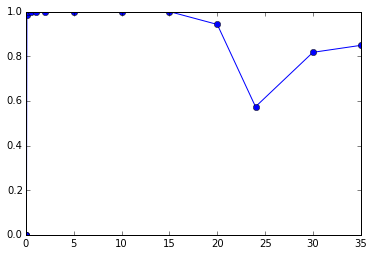

In [75]:
plt.plot(sigmas,moonMeans,'bo-')

In [77]:
moonMeans.max()

1.0

In [52]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros((2*size*EACH,2))
    Y = np.zeros(2*size*EACH,dtype=int)
    Y[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH)
        X[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH)
    return X,Y,"Disks"

In [79]:
sigmas = [0.01,.02,.05,.1,.2,.5,1,2,5,10,15,20,24,30,35]
diskX,diskY,tmp = generateTwoDisks()
diskMeans = runSigma(diskX,diskY,sigmas)

list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64
list indices must be integers, not numpy.float64


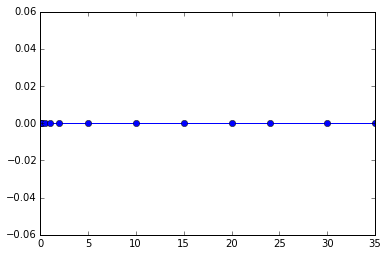

In [80]:
plt.plot(sigmas,diskMeans,'bo-')

In [81]:
diskMeans.max()

0.0

In [86]:
sigmas = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,5]
xorX,xorY,tmp = generateXOR()
xorMeans = runSigma(xorX,xorY,sigmas)

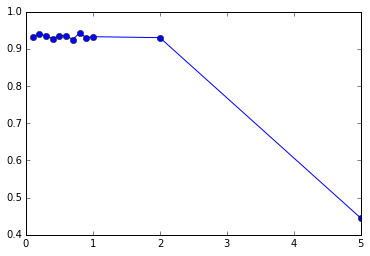

In [87]:
plt.plot(sigmas,xorMeans,'bo-')

In [88]:
xorMeans.max()

0.94250000000000012

In [89]:
xorMeans

array([ 0.9325,  0.94  ,  0.935 ,  0.9275,  0.935 ,  0.935 ,  0.925 ,
        0.9425,  0.93  ,  0.9325,  0.93  ,  0.445 ])

In [100]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    X = concentric['X'][:,[0,1]]
    Y = concentric['Y'][:,0]
    Y = (Y==1)
    return X,Y,"Concentric"

In [109]:
sigmas = [.4,.5,.7,.8,.9,1,1.1,1.2,1.3,1.5]
concentricX,concentricY,tmp = generateConcentric()
concentricMeans = runSigma(concentricX,concentricY,sigmas)

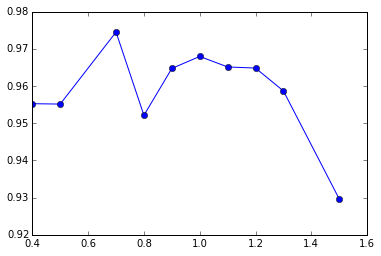

In [111]:
plt.plot(sigmas,concentricMeans,'bo-')

In [112]:
concentricMeans.max()

0.97449596774193559

In [ ]:
supervised10FoldRepresentation(sonarX,sonarY,.2)

In [ ]:
supervised10FoldRepresentation(wineX,wineY,60)

In [ ]:
supervised10FoldRepresentation(glassX,glassY,3)

In [ ]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
def irisLableSet(name):
    names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    for i in xrange(3):
        if names[i] == name:
            return i
irisData = pd.read_csv('data/iris.data',header=None)
irisY = irisData[4].apply(irisLableSet).values
irisX = irisData.drop(4,axis=1)
irisX = irisX.values
irisMeans = runSigma(irisX,irisY,sigmas)

In [ ]:
plt.plot(sigmas,irisMeans,'bo-')

In [ ]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassData = pd.read_csv('data/glass.data',header=None)
glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
glassX = glassData.drop([0,10],axis=1)
glassX = glassX.values
glassMeans = runSigma(glassX,glassY,sigmas)

In [ ]:
print len(sigmas)
plt.plot(sigmas,glassMeans,'bo-')

In [ ]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
glassMeans = runSigma(glassX,glassY,sigmas)

In [ ]:
glassMeans

In [ ]:
results = []
resS = []
for iterator in xrange(10):
    sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
    glassX,glassY = loadGlass()
    glassMeans = runSigma(glassX,glassY,sigmas)
    results.append(glassMeans.max())
    resS.append(glassMeans.argmax())

In [305]:
print results
print
print resS

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


--------------------------------------- sigma:  0.01


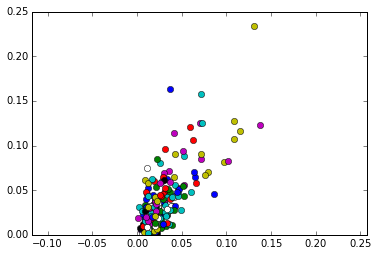

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


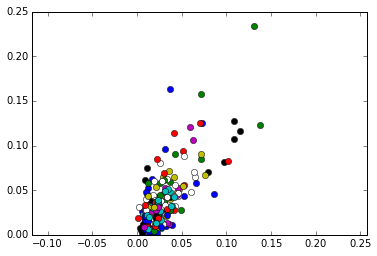

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


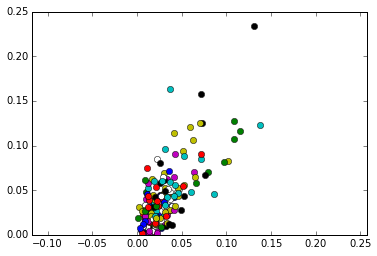

208 30 2
0 : 0.52380952381
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.571428571429
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


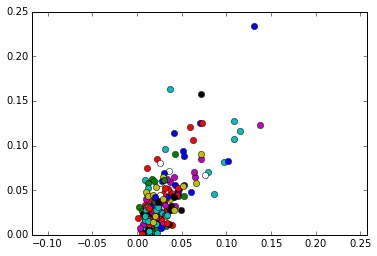

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.65
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.05


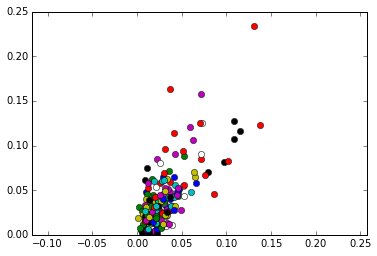

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.65
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.1


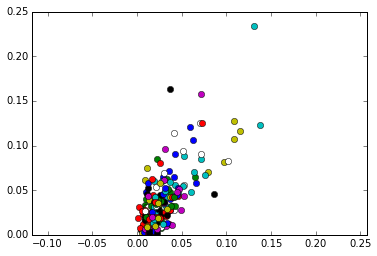

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.904761904762
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.52380952381
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.47619047619
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.85
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.2


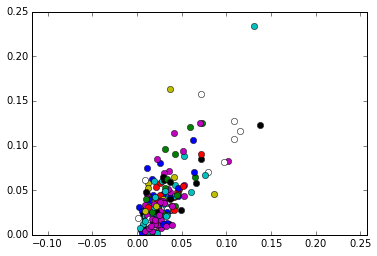

208 30 2
0 : 0.571428571429
208 30 2
1 : 0.952380952381
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.8
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.3


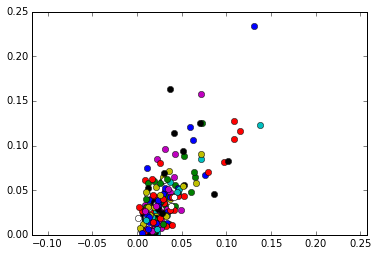

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.904761904762
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.9
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.4


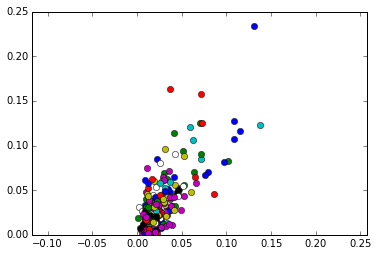

208 30 2
0 : 0.571428571429
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.8
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.5


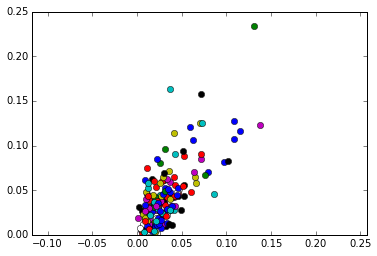

208 30 2
0 : 0.52380952381
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.6
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.6


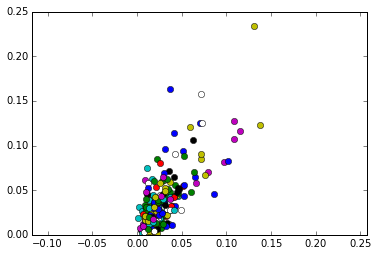

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.857142857143
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.65
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.7


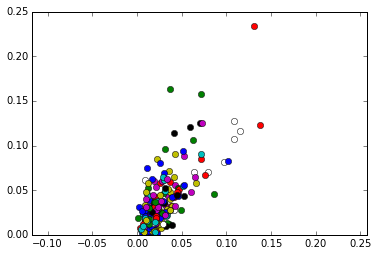

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.6
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.8


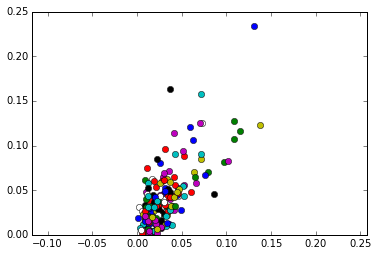

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.9


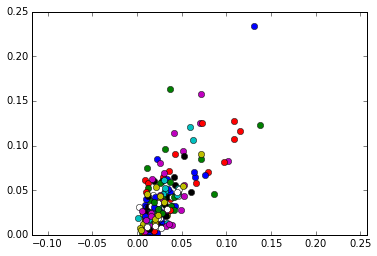

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.55
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.01


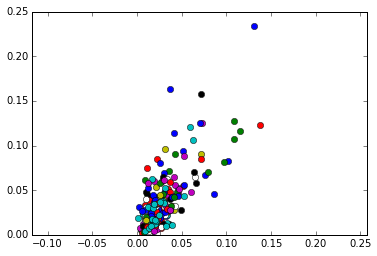

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


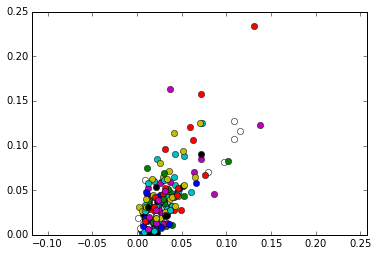

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


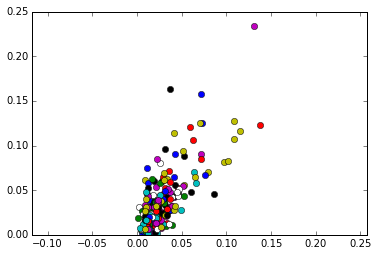

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.571428571429
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


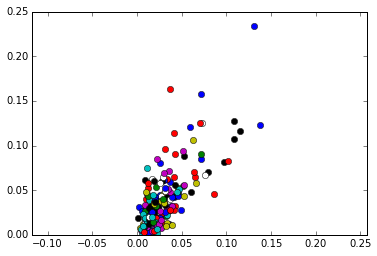

208 30 2
0 : 0.904761904762
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.47619047619
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.47619047619
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.9
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.05


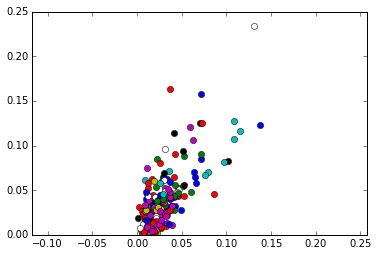

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.428571428571
208 30 2
8 : 0.75
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.1


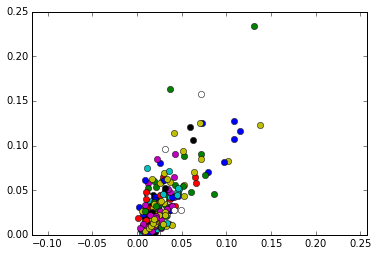

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.8
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.2


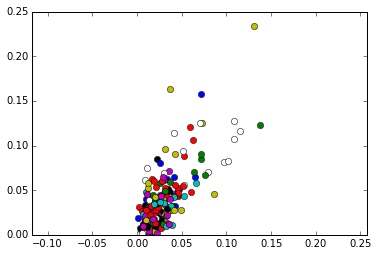

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.8
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.3


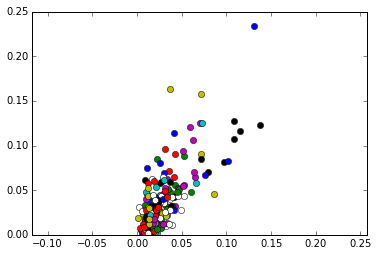

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.9
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.4


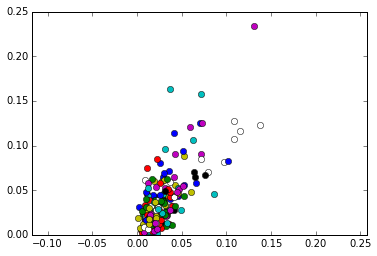

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.75
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.5


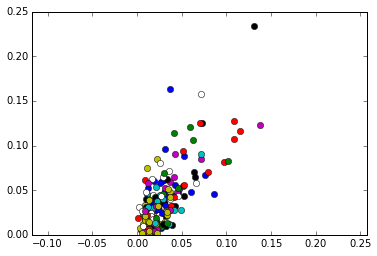

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.571428571429
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.7
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.6


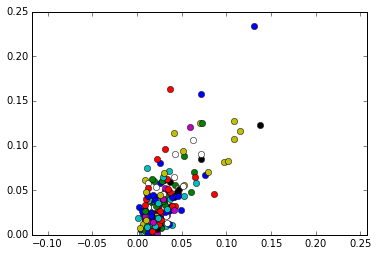

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.65
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.7


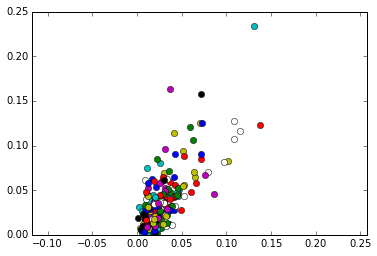

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.52380952381
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.6
208 30 2
9 : 0.5
--------------------------------------- sigma:  0.8


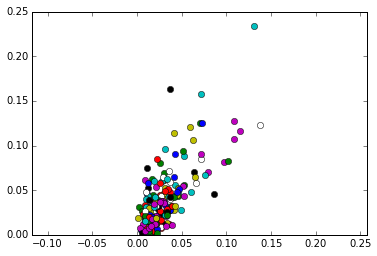

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.75
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.9


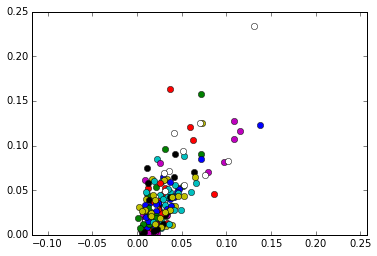

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.6
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.01


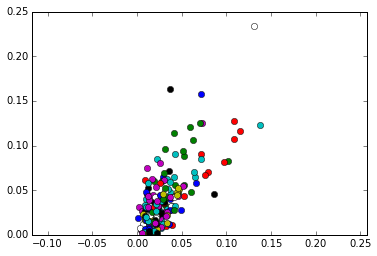

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


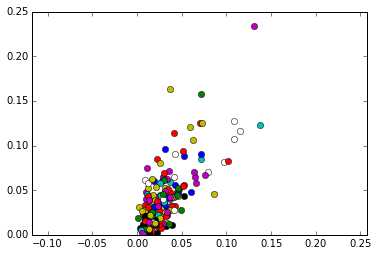

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


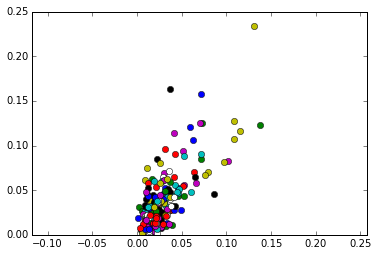

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.52380952381
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


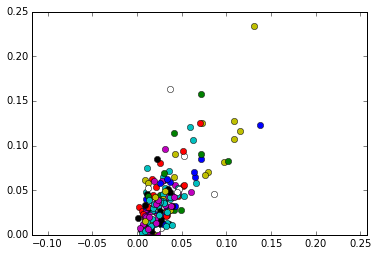

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.4
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.05


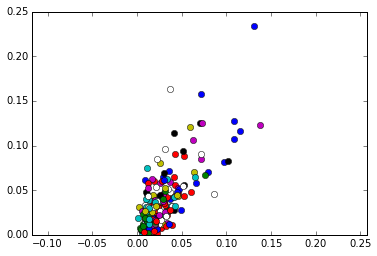

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.75
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.1


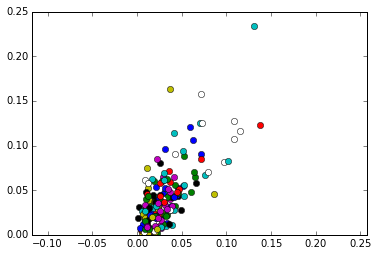

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.857142857143
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.85
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.2


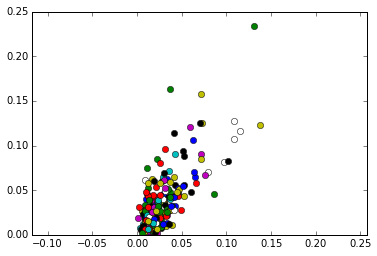

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.6
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.3


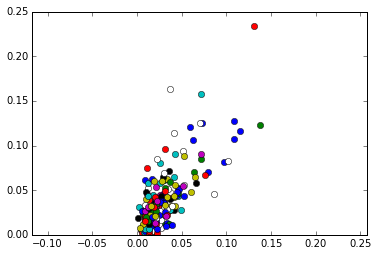

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.571428571429
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.904761904762
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.8
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.4


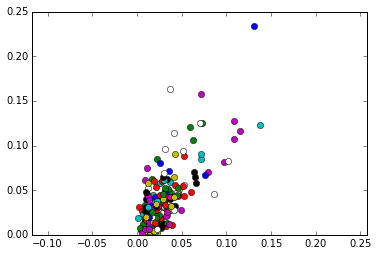

208 30 2
0 : 0.952380952381
208 30 2
1 : 0.47619047619
208 30 2
2 : 0.904761904762
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.65
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.5


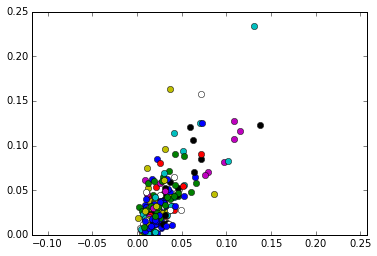

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.52380952381
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.75
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.6


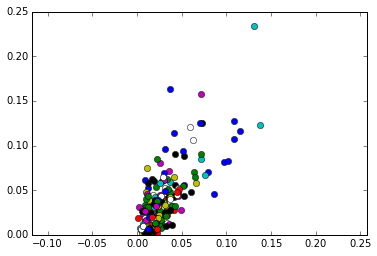

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.6
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.7


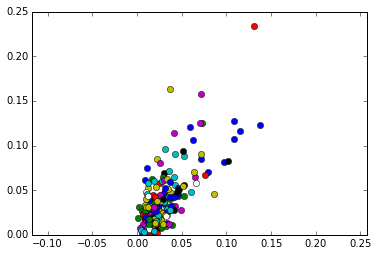

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.952380952381
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.9
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.8


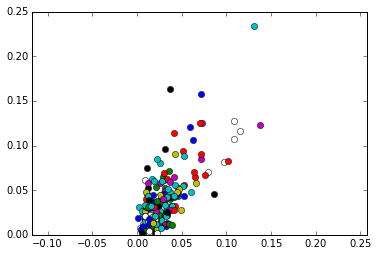

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.47619047619
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.8
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.9


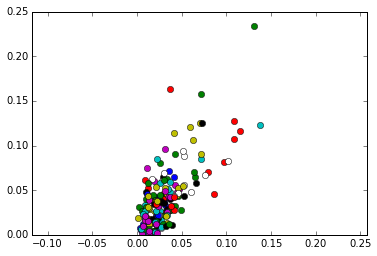

208 30 2
0 : 0.904761904762
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.8
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.01


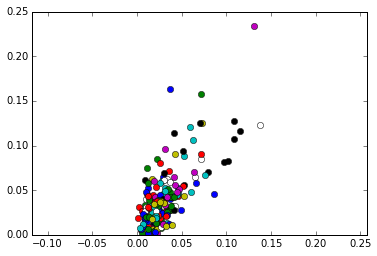

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


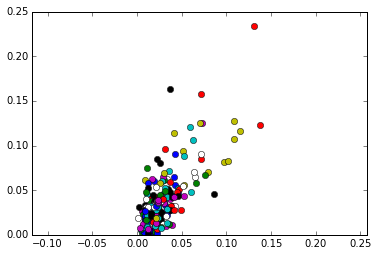

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


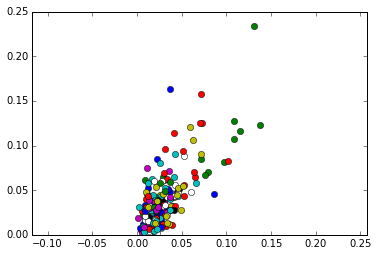

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


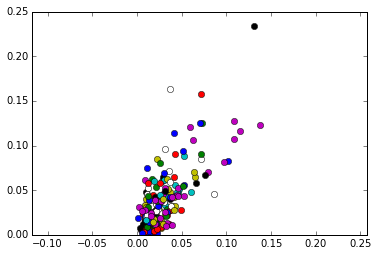

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.52380952381
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.85
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.05


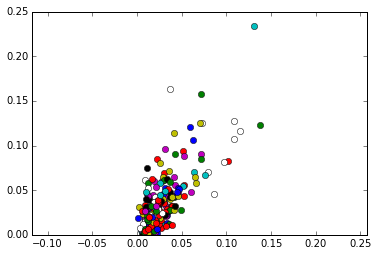

208 30 2
0 : 0.47619047619
208 30 2
1 : 0.52380952381
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.7
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.1


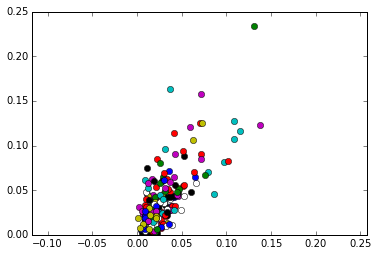

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.75
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.2


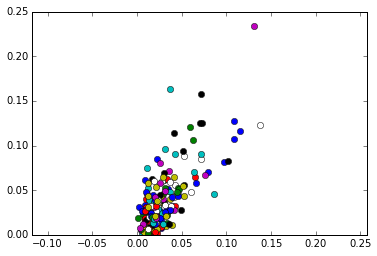

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.85
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.3


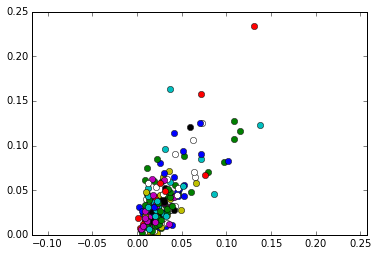

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.47619047619
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.904761904762
208 30 2
8 : 0.75
208 30 2
9 : 0.95
--------------------------------------- sigma:  0.4


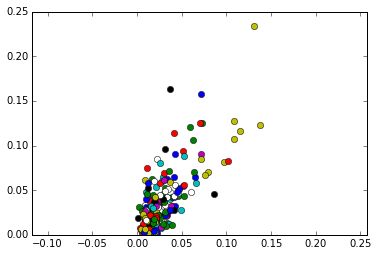

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.8
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.5


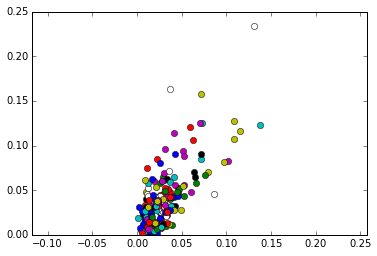

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.9
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.6


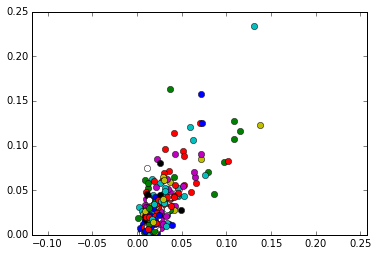

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.65
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.7


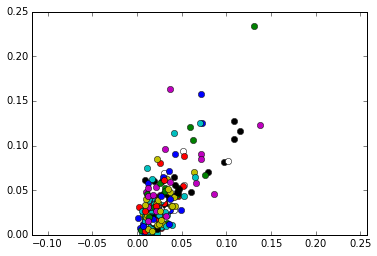

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.65
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.8


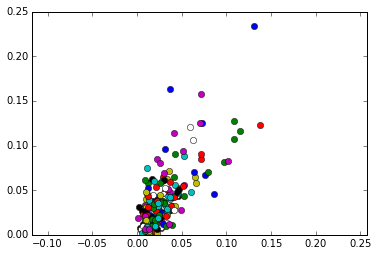

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.952380952381
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.65
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.9


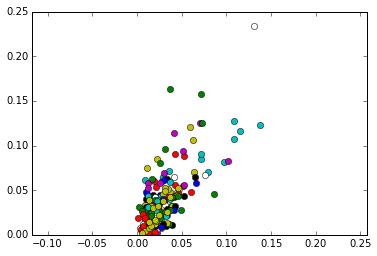

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.904761904762
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.01


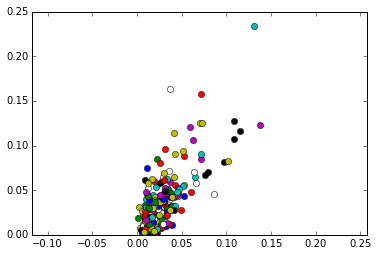

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


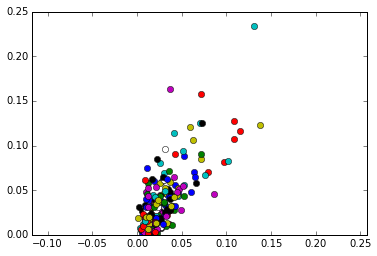

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


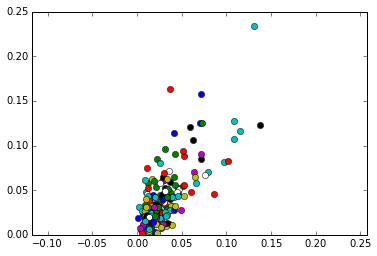

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


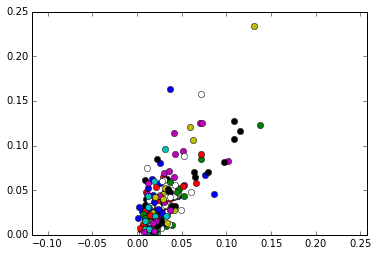

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.52380952381
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.8
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.05


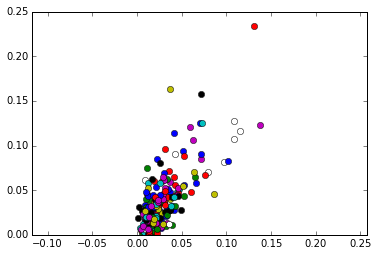

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.5
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.1


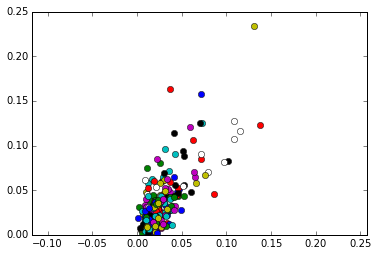

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.7
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.2


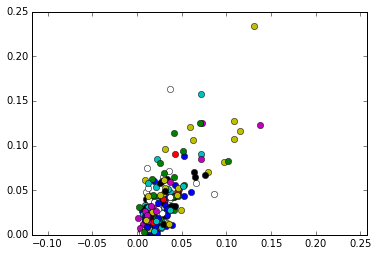

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.75
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.3


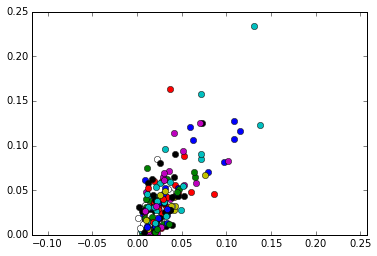

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.75
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.4


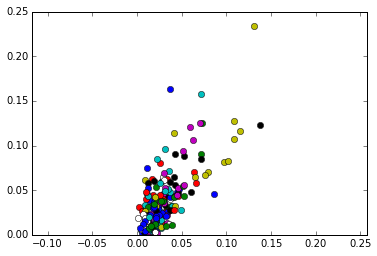

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.904761904762
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.7
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.5


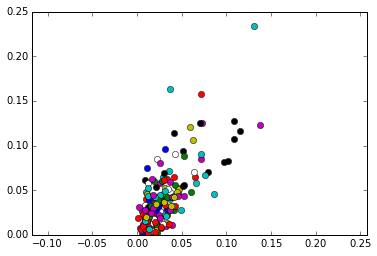

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.904761904762
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.85
208 30 2
9 : 0.9
--------------------------------------- sigma:  0.6


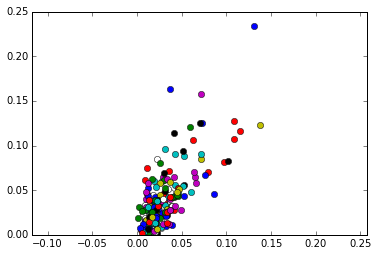

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.7


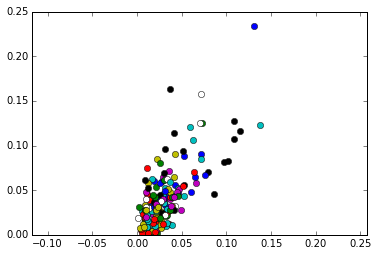

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.857142857143
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.75
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.8


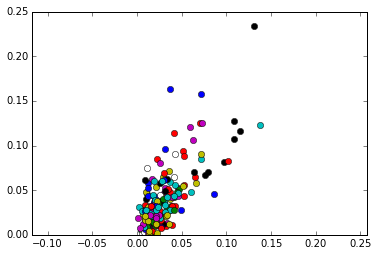

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.52380952381
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.7
208 30 2
9 : 0.9
--------------------------------------- sigma:  0.9


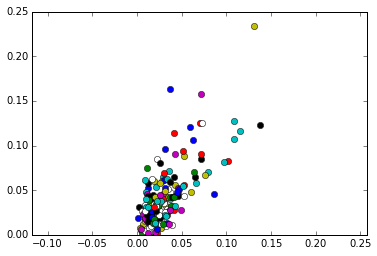

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.47619047619
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.7
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.01


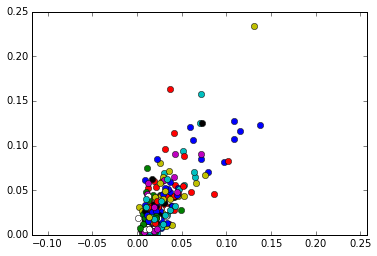

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


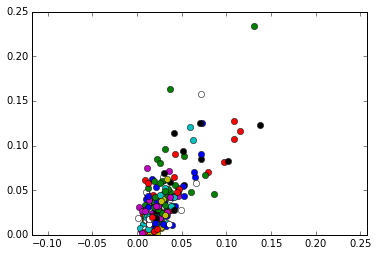

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


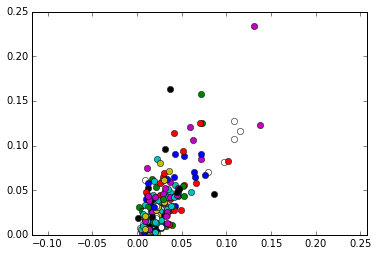

208 30 2
0 : 0.52380952381
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.285714285714
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


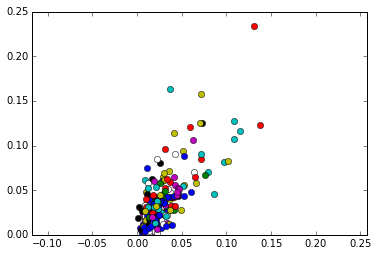

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.428571428571
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.55
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.05


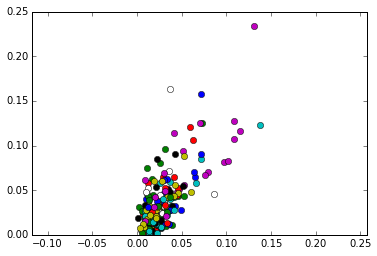

208 30 2
0 : 0.47619047619
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.52380952381
208 30 2
6 : 0.952380952381
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.55
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.1


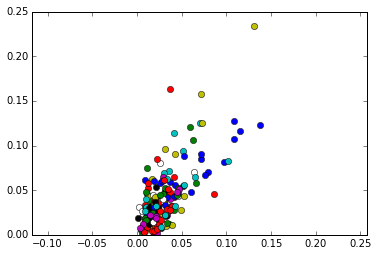

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.571428571429
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.6
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.2


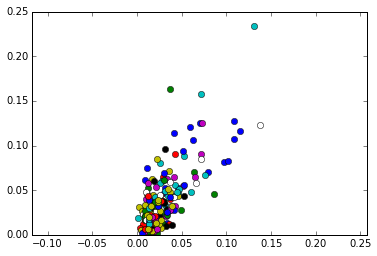

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.904761904762
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.9
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.3


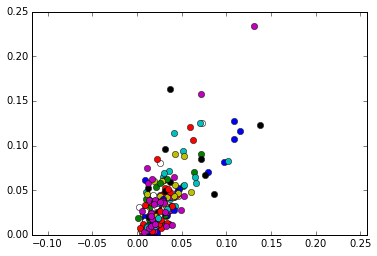

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.95
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.4


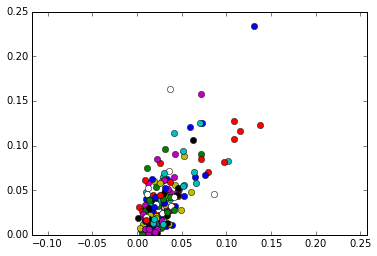

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.55
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.5


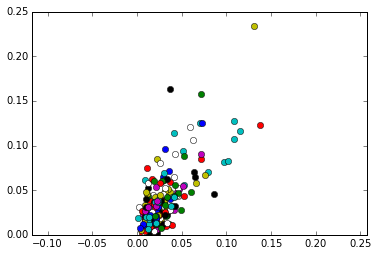

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.65
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.6


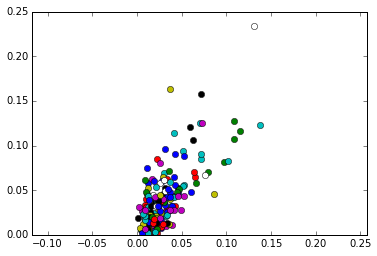

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.47619047619
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.857142857143
208 30 2
6 : 0.52380952381
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.75
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.7


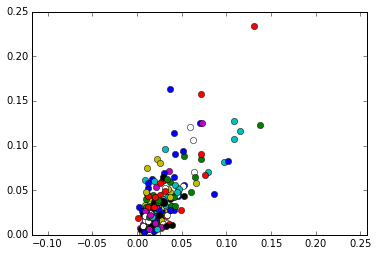

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.7
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.8


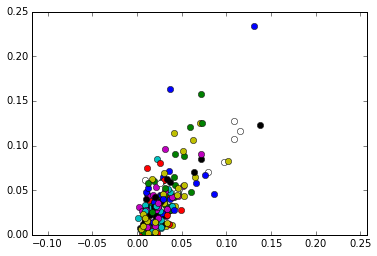

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.47619047619
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.75
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.9


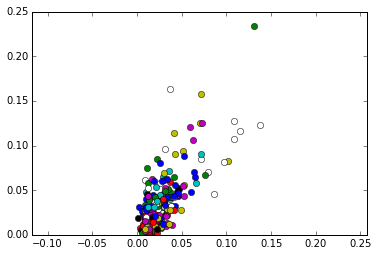

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.47619047619
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.01


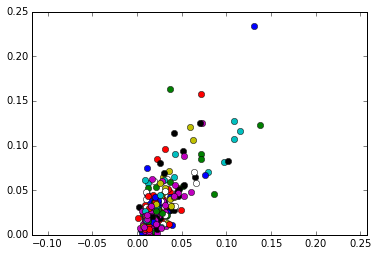

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


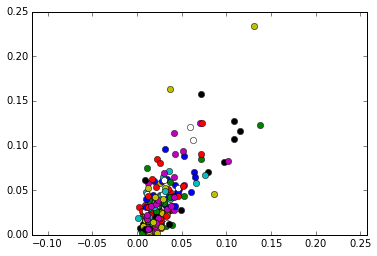

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


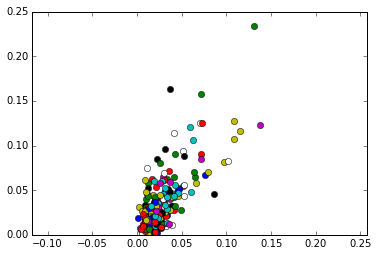

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


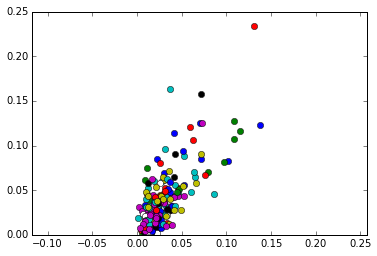

208 30 2
0 : 0.47619047619
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.52380952381
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.65
208 30 2
9 : 0.6
--------------------------------------- sigma:  0.05


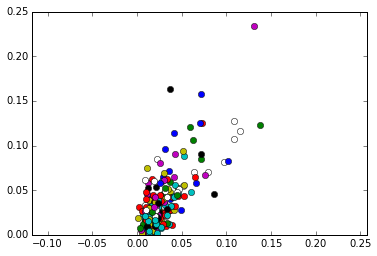

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.85
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.1


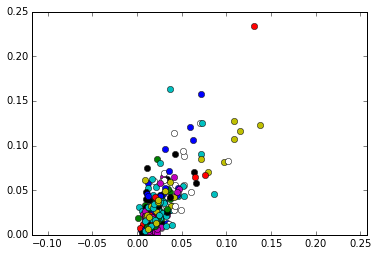

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.8
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.2


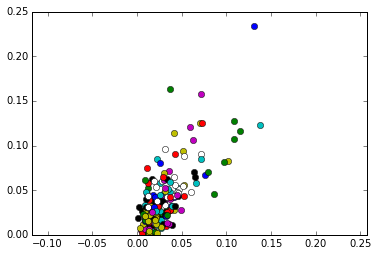

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.52380952381
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.8
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.3


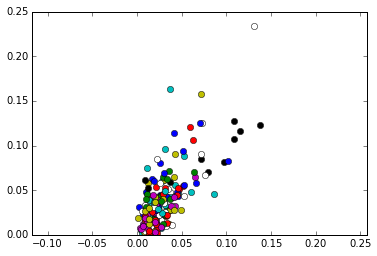

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.904761904762
208 30 2
8 : 0.95
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.4


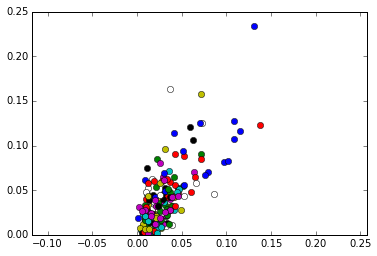

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.952380952381
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.8
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.5


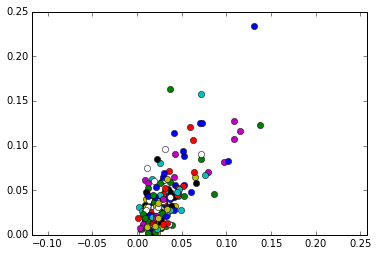

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.47619047619
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.285714285714
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.75
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.6


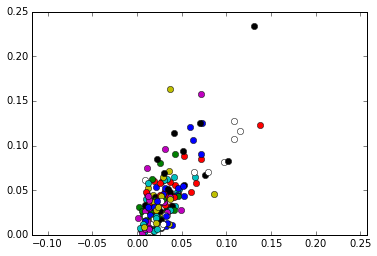

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.65
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.7


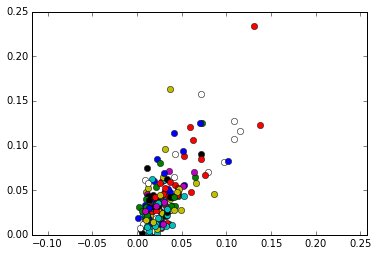

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.8


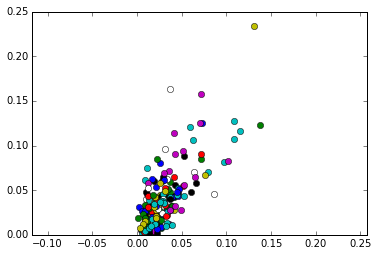

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.571428571429
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.75
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.9


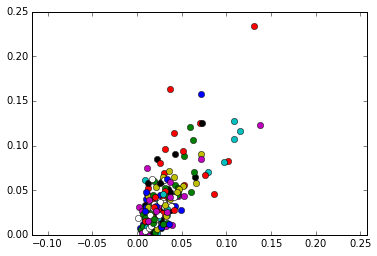

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.571428571429
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.65
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.01


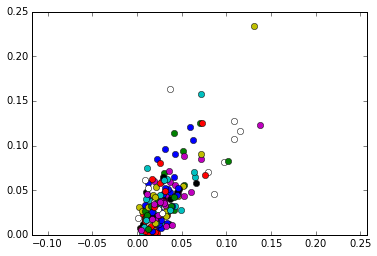

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


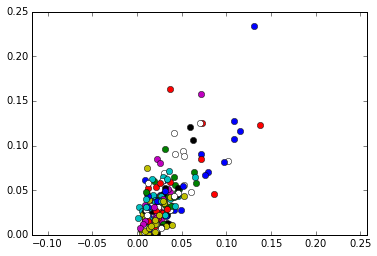

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


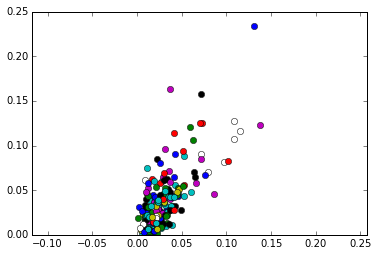

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.714285714286
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


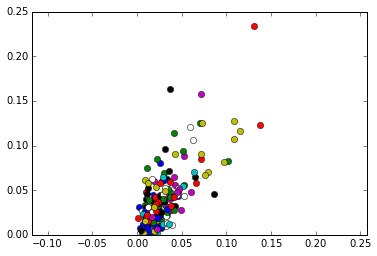

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.904761904762
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.6
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.05


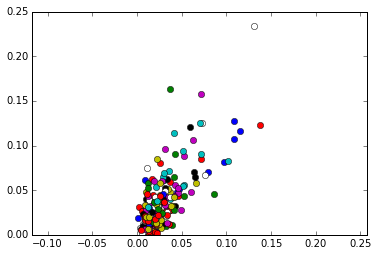

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.7
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.1


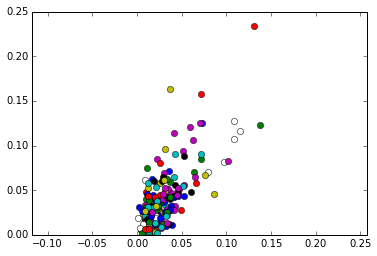

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.952380952381
208 30 2
8 : 0.8
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.2


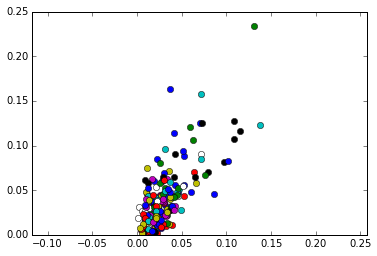

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.952380952381
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.85
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.3


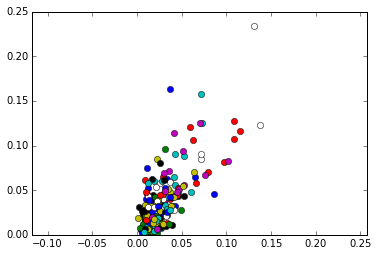

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.904761904762
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.8
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.4


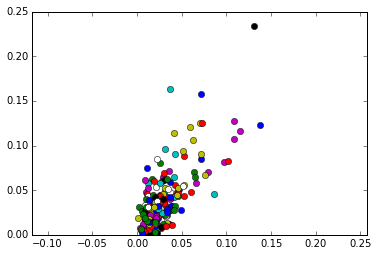

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.7
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.5


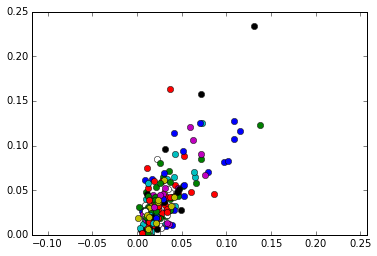

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.904761904762
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.5
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.6


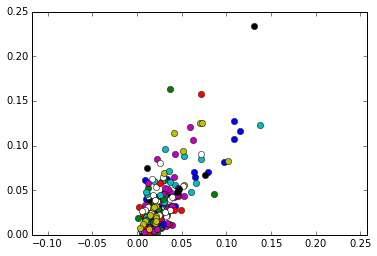

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.55
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.7


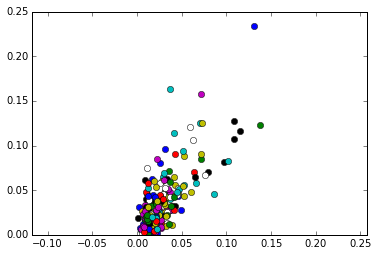

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.571428571429
208 30 2
8 : 0.75
208 30 2
9 : 0.9
--------------------------------------- sigma:  0.8


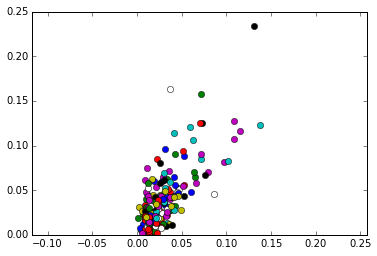

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.9


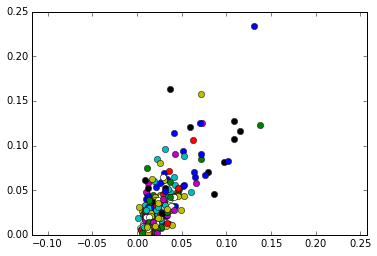

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.952380952381
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.571428571429
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.85
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.01


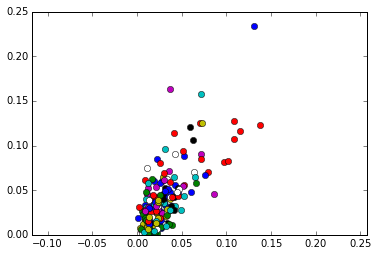

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


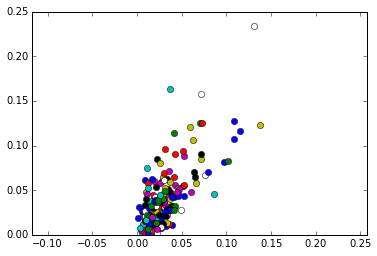

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


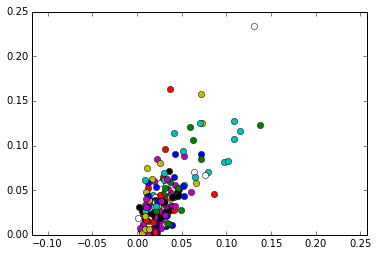

208 30 2
0 : 0.428571428571
208 30 2
1 : 0.52380952381
208 30 2
2 : 0.666666666667
208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.04


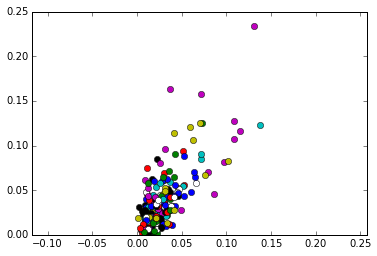

208 30 2
0 : 0.52380952381
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.47619047619
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.619047619048
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.6
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.05


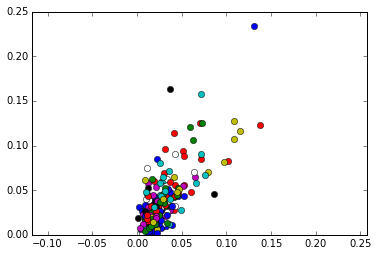

208 30 2
0 : 0.904761904762
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.904761904762
208 30 2
8 : 0.7
208 30 2
9 : 0.55
--------------------------------------- sigma:  0.1


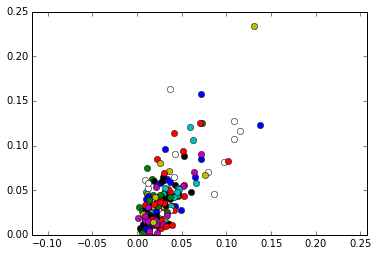

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.47619047619
208 30 2
3 : 0.52380952381
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.8
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.2


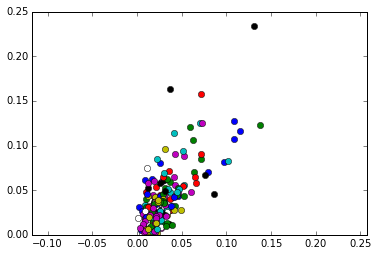

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.6
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.3


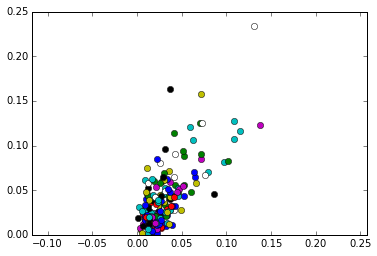

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.714285714286
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.857142857143
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.7
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.4


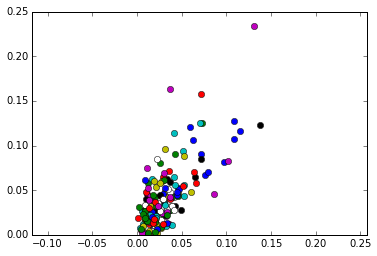

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.714285714286
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.65
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.5


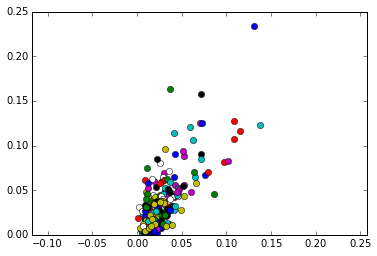

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.65
208 30 2
9 : 0.9
--------------------------------------- sigma:  0.6


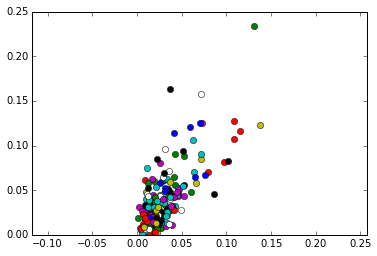

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.809523809524
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.6
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.7


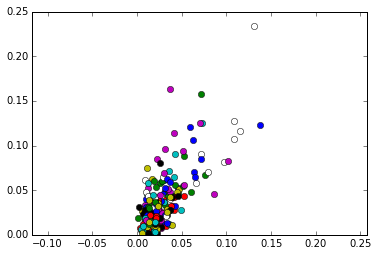

208 30 2
0 : 0.761904761905
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.52380952381
208 30 2
6 : 0.571428571429
208 30 2
7 : 0.714285714286
208 30 2
8 : 0.75
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.8


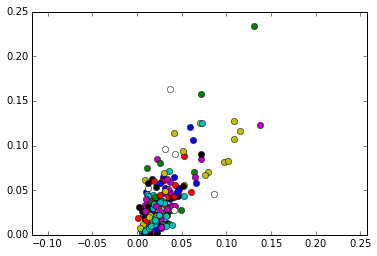

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.85
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.9


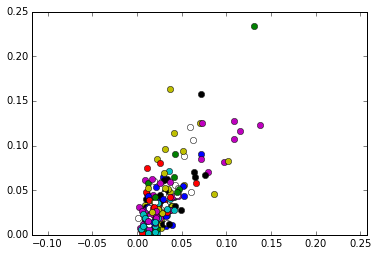

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.571428571429
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.904761904762
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.7
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.01


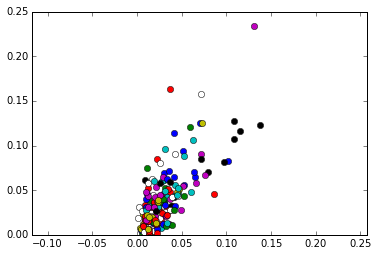

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.02


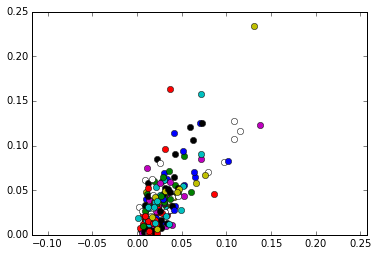

208 30 2
Factor is exactly singular
--------------------------------------- sigma:  0.03


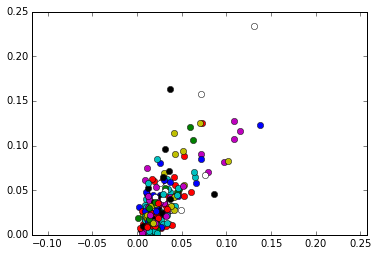

208 30 2
0 : 0.619047619048
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.52380952381
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.47619047619
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.65
208 30 2
9 : 0.35
--------------------------------------- sigma:  0.04


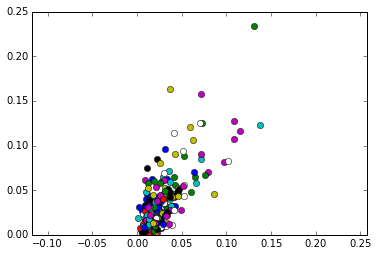

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.571428571429
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.52380952381
208 30 2
6 : 0.333333333333
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.6
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.05


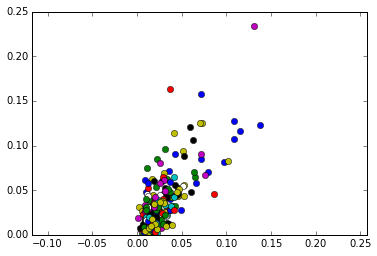

208 30 2
0 : 0.571428571429
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.8
208 30 2
9 : 0.7
--------------------------------------- sigma:  0.1


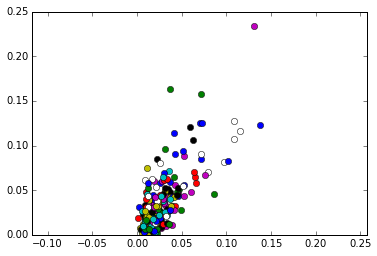

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.666666666667
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.666666666667
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.6
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.2


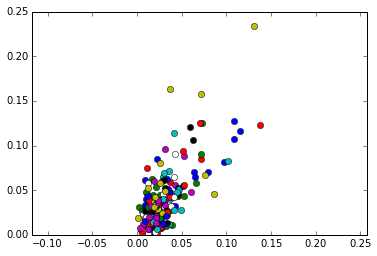

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.809523809524
208 30 2
2 : 0.619047619048
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.952380952381
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.75
208 30 2
9 : 0.9
--------------------------------------- sigma:  0.3


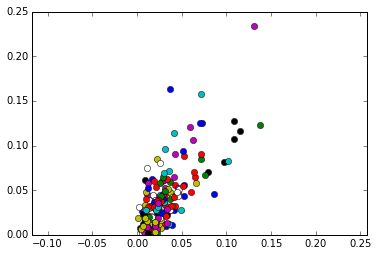

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.666666666667
208 30 2
2 : 0.666666666667
208 30 2
3 : 0.619047619048
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.809523809524
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.809523809524
208 30 2
8 : 0.6
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.4


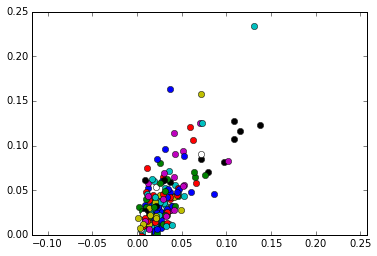

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.571428571429
208 30 2
2 : 0.52380952381
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.809523809524
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.809523809524
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.8
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.5


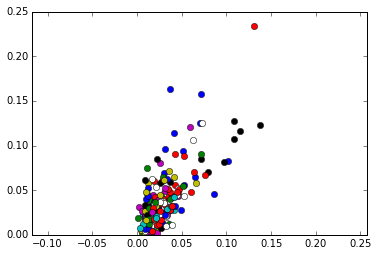

208 30 2
0 : 0.809523809524
208 30 2
1 : 0.761904761905
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.761904761905
208 30 2
4 : 0.761904761905
208 30 2
5 : 0.761904761905
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.857142857143
208 30 2
8 : 0.75
208 30 2
9 : 0.75
--------------------------------------- sigma:  0.6


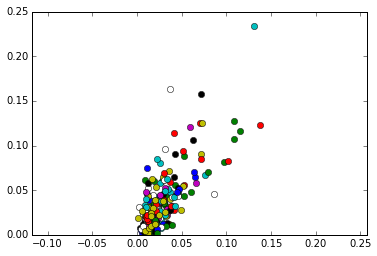

208 30 2
0 : 0.857142857143
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.761904761905
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.666666666667
208 30 2
5 : 0.857142857143
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.761904761905
208 30 2
8 : 0.55
208 30 2
9 : 0.85
--------------------------------------- sigma:  0.7


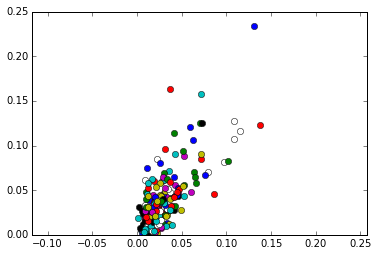

208 30 2
0 : 0.714285714286
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.714285714286
208 30 2
3 : 0.904761904762
208 30 2
4 : 0.857142857143
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.619047619048
208 30 2
7 : 0.619047619048
208 30 2
8 : 0.7
208 30 2
9 : 0.65
--------------------------------------- sigma:  0.8


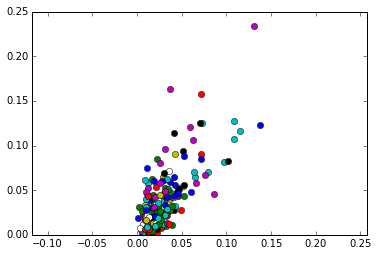

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.857142857143
208 30 2
2 : 0.428571428571
208 30 2
3 : 0.714285714286
208 30 2
4 : 0.619047619048
208 30 2
5 : 0.714285714286
208 30 2
6 : 0.761904761905
208 30 2
7 : 0.52380952381
208 30 2
8 : 0.8
208 30 2
9 : 0.8
--------------------------------------- sigma:  0.9


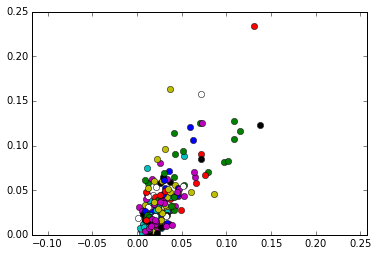

208 30 2
0 : 0.666666666667
208 30 2
1 : 0.619047619048
208 30 2
2 : 0.857142857143
208 30 2
3 : 0.809523809524
208 30 2
4 : 0.714285714286
208 30 2
5 : 0.666666666667
208 30 2
6 : 0.857142857143
208 30 2
7 : 0.666666666667
208 30 2
8 : 0.75
208 30 2
9 : 0.55


In [240]:


results = []
resS = []
for iterator in xrange(10):
    sigmas = [.01,.02,.03,0.04,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]
    sonarData = pd.read_csv('data/sonar.data',header=None)
    sonarY = (sonarData[60].apply(lambda x: 0 if x=='M' else 1)).values
    sonarX = sonarData.drop(60,axis=1)
    sonarX = sonarX.values
    sonarMeans = runSigma(sonarX,sonarY)
    results.append(sonarMeans.max())
    resS.append(sonarMeans.argmax())

In [241]:
print results
print
print resS

[0.76428571428571423, 0.79785714285714282, 0.75047619047619052, 0.78333333333333333, 0.78380952380952373, 0.82238095238095243, 0.76547619047619053, 0.80809523809523809, 0.78309523809523796, 0.78880952380952385]

[6, 6, 7, 6, 7, 6, 7, 6, 6, 6]


--------------------------------------- sigma:  0.01


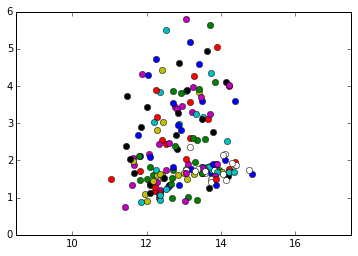

fold number: 0
178 40 3
------------------------------------------1 2---------------


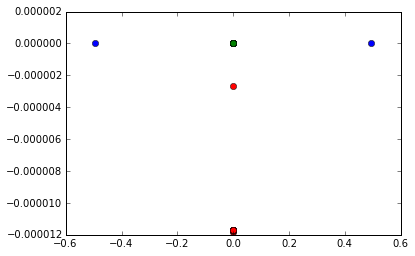

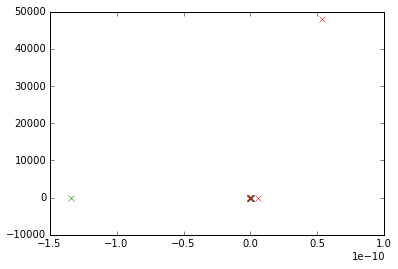

------------------------------------------3 4---------------


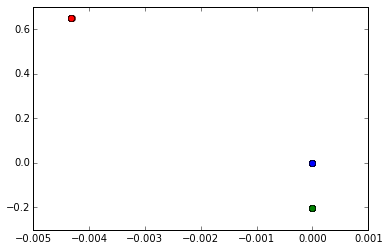

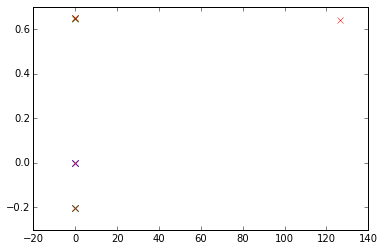

------------------------------------------5 6---------------


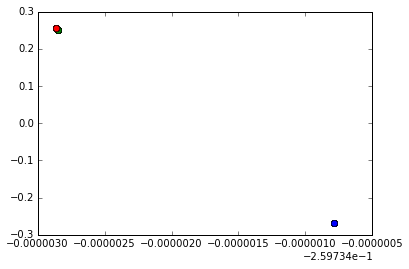

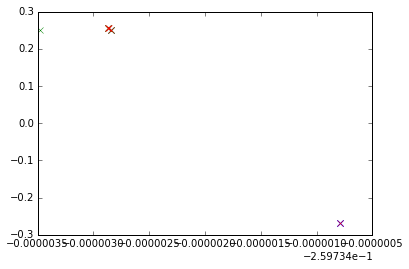

fold number: 1
178 40 3
------------------------------------------1 2---------------


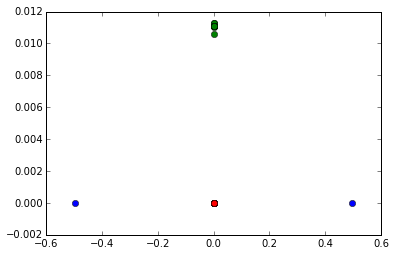

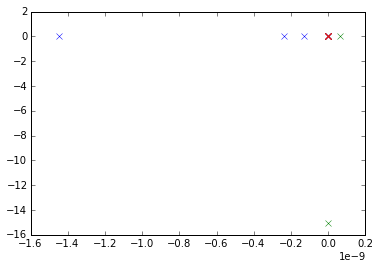

------------------------------------------3 4---------------


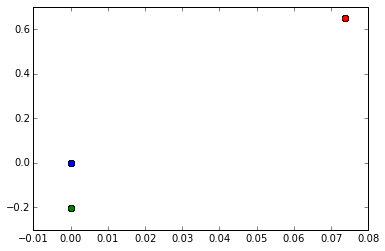

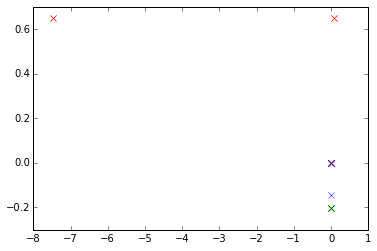

------------------------------------------5 6---------------


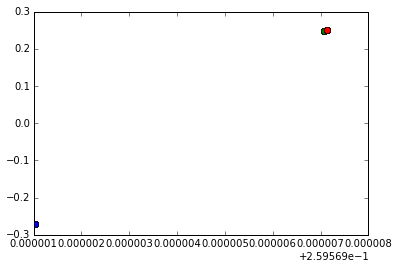

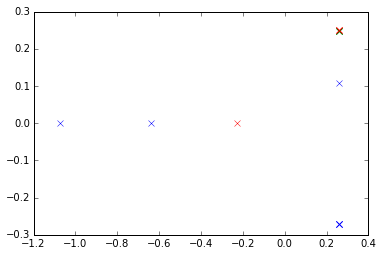

fold number: 2
178 40 3
------------------------------------------1 2---------------


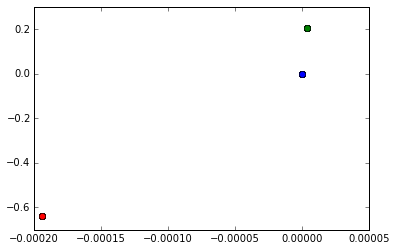

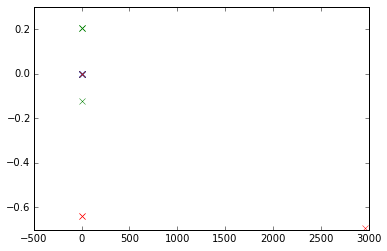

------------------------------------------3 4---------------


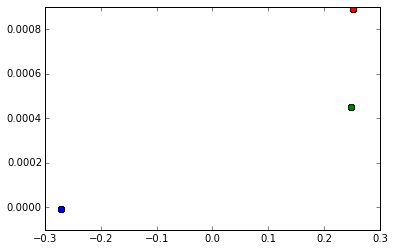

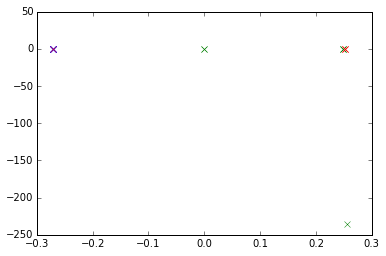

------------------------------------------5 6---------------


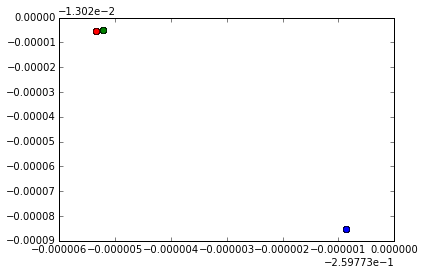

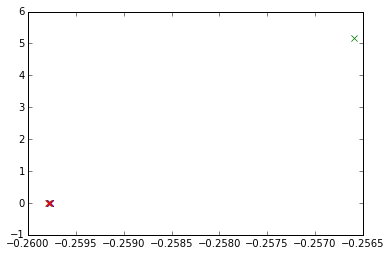

fold number: 3
178 40 3
------------------------------------------1 2---------------


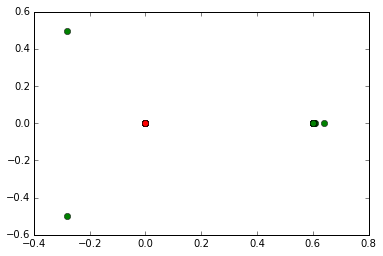

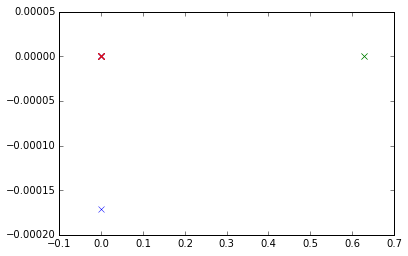

------------------------------------------3 4---------------


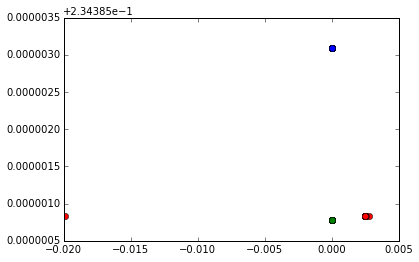

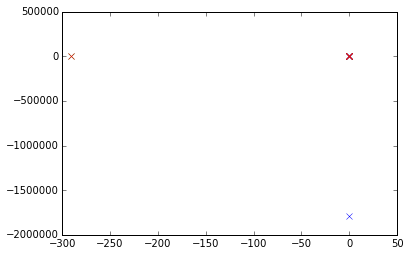

------------------------------------------5 6---------------


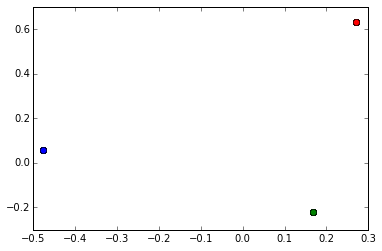

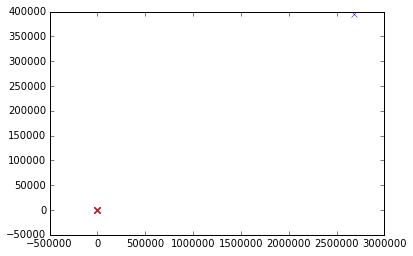

fold number: 4
178 40 3
------------------------------------------1 2---------------


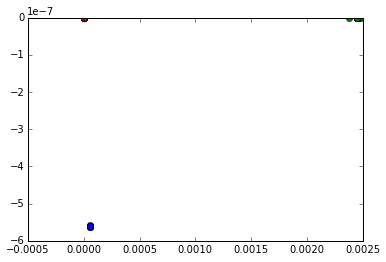

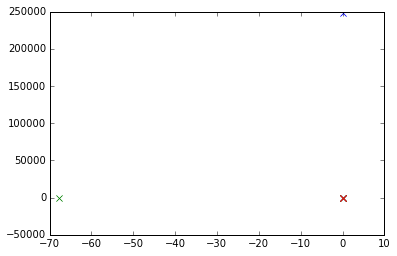

------------------------------------------3 4---------------


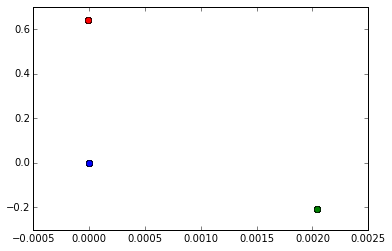

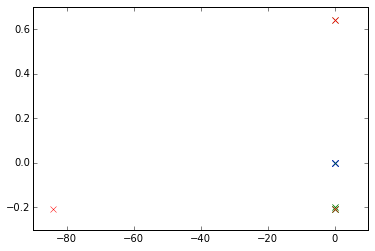

------------------------------------------5 6---------------


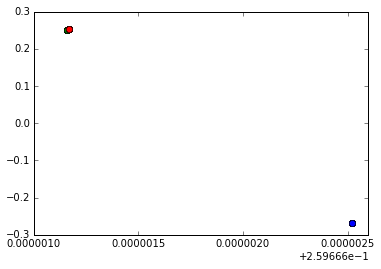

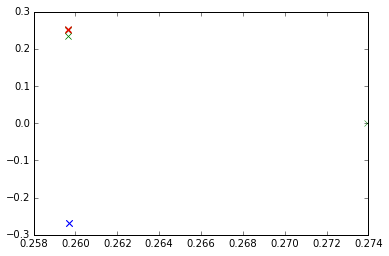

fold number: 5
178 40 3
------------------------------------------1 2---------------


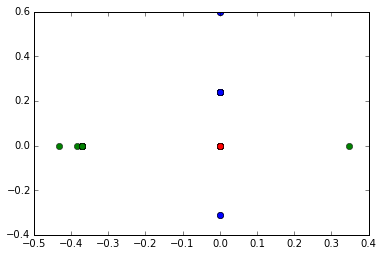

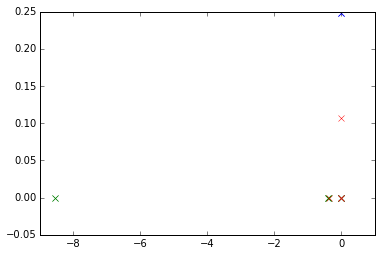

------------------------------------------3 4---------------


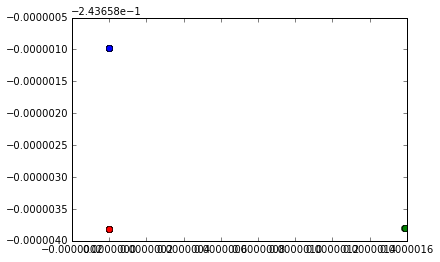

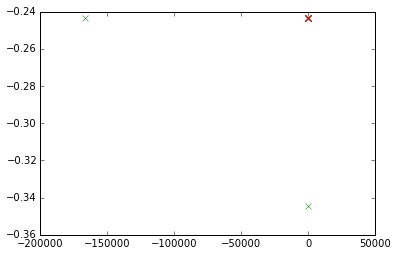

------------------------------------------5 6---------------


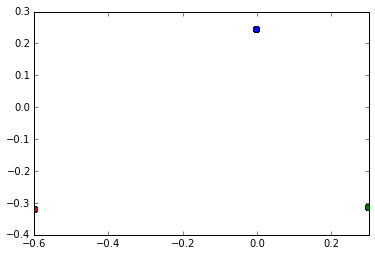

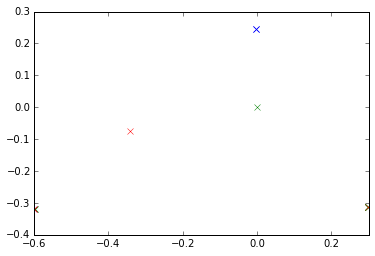

fold number: 6
178 40 3
------------------------------------------1 2---------------


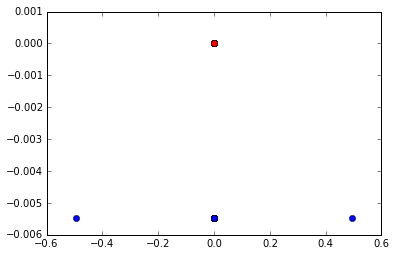

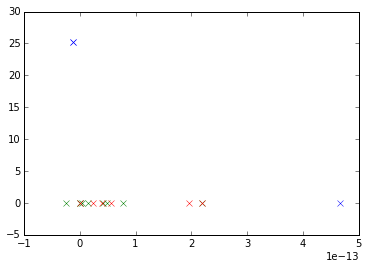

------------------------------------------3 4---------------


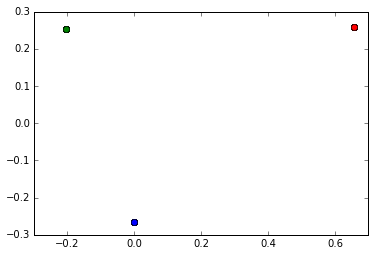

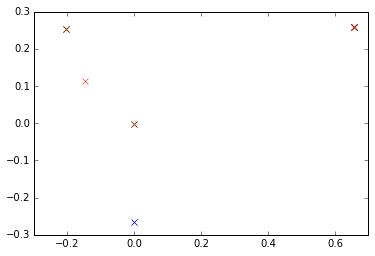

------------------------------------------5 6---------------


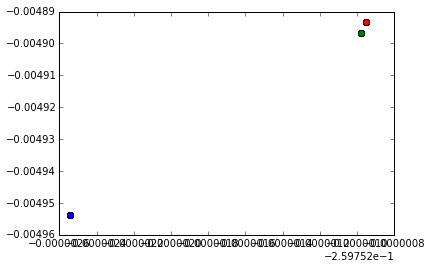

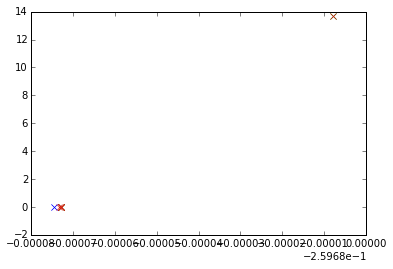

fold number: 7
178 40 3
------------------------------------------1 2---------------


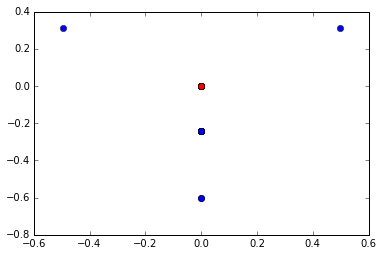

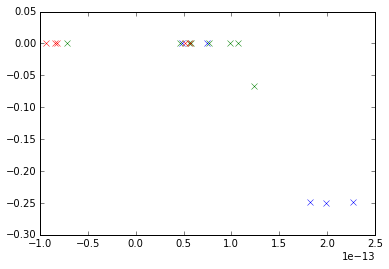

------------------------------------------3 4---------------


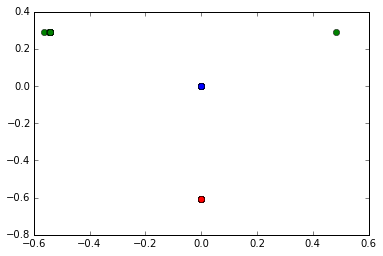

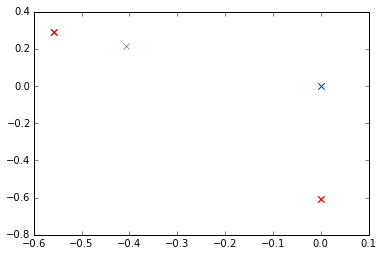

------------------------------------------5 6---------------


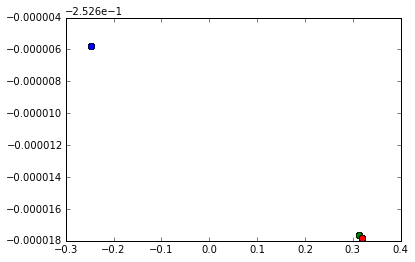

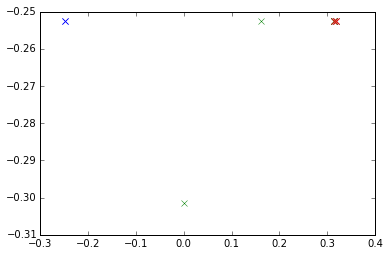

fold number: 8
178 40 3
------------------------------------------1 2---------------


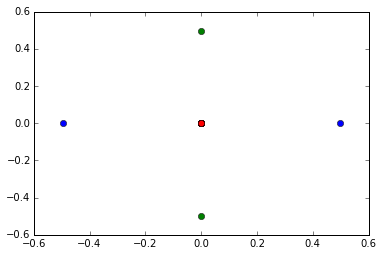

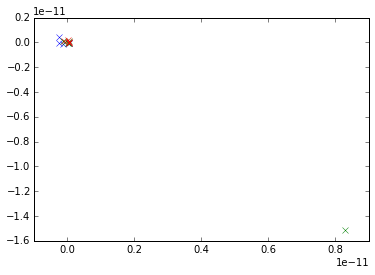

------------------------------------------3 4---------------


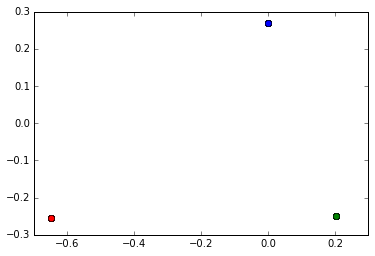

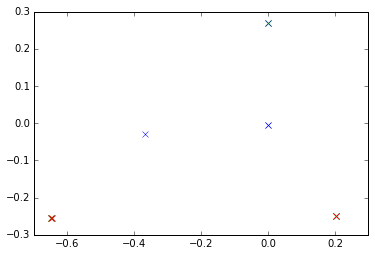

------------------------------------------5 6---------------


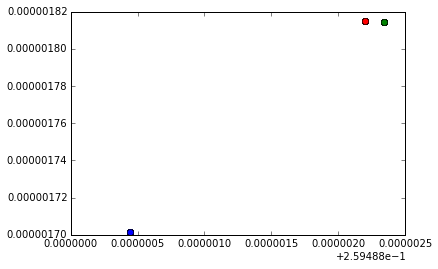

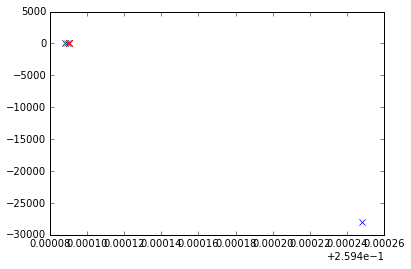

fold number: 9
178 40 3
------------------------------------------1 2---------------


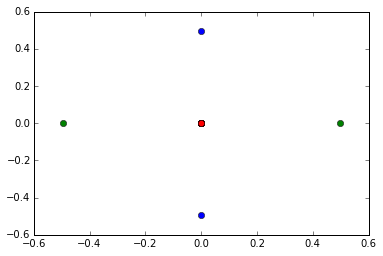

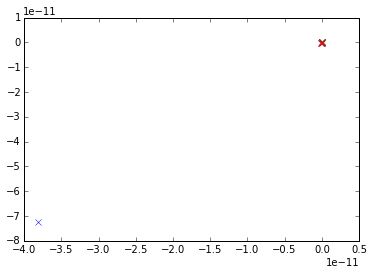

------------------------------------------3 4---------------


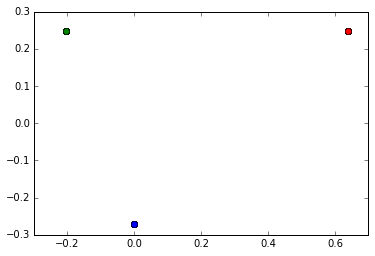

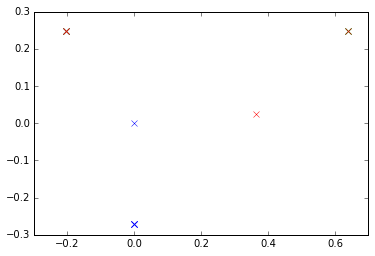

------------------------------------------5 6---------------


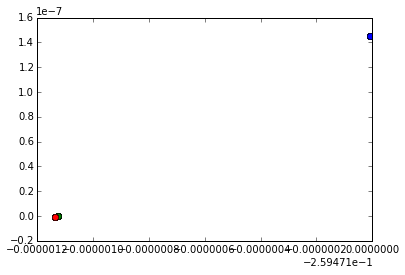

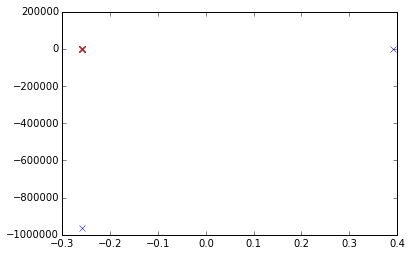

--------------------------------------- sigma:  0.02


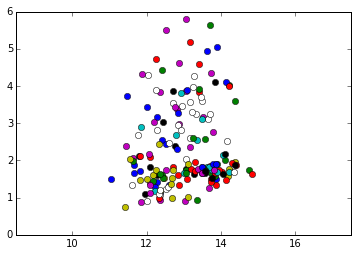

fold number: 0
178 40 3
------------------------------------------1 2---------------


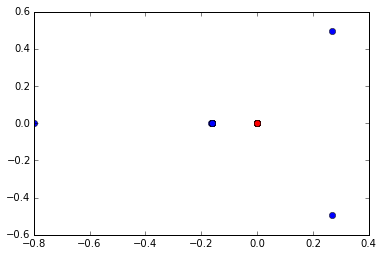

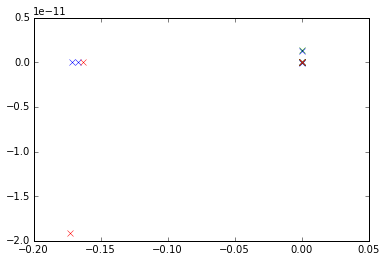

------------------------------------------3 4---------------


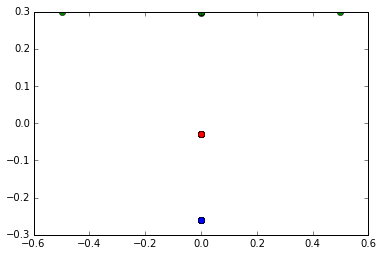

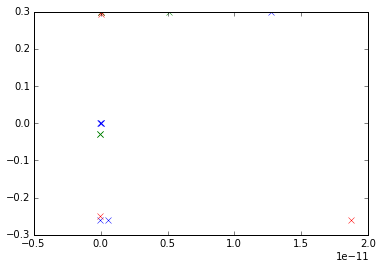

------------------------------------------5 6---------------


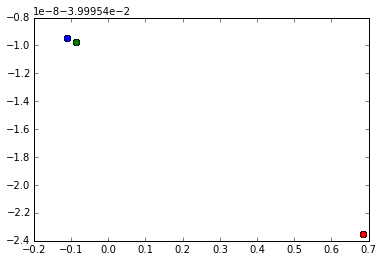

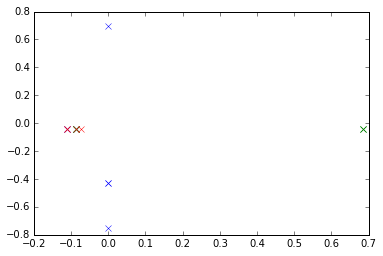

fold number: 1
178 40 3
------------------------------------------1 2---------------


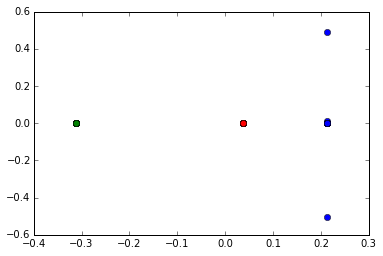

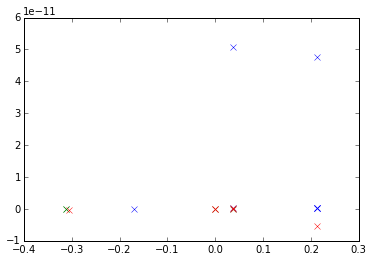

------------------------------------------3 4---------------


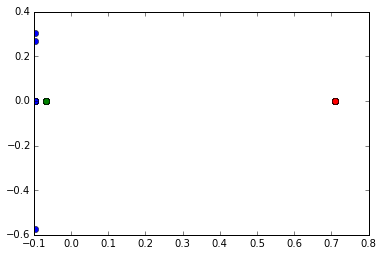

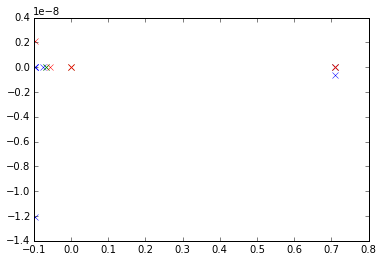

------------------------------------------5 6---------------


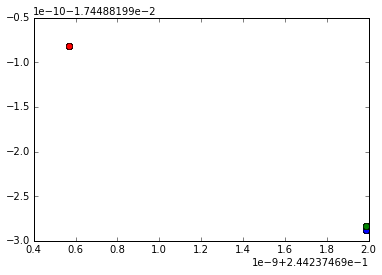

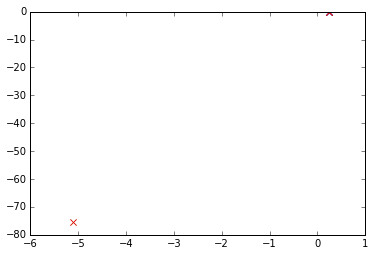

fold number: 2
178 40 3
------------------------------------------1 2---------------


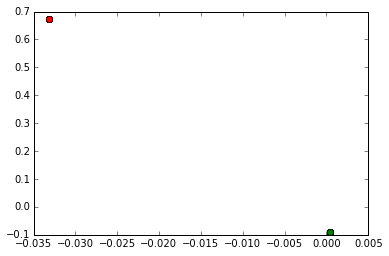

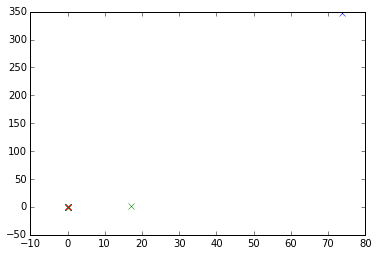

------------------------------------------3 4---------------


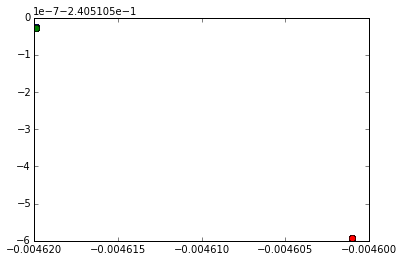

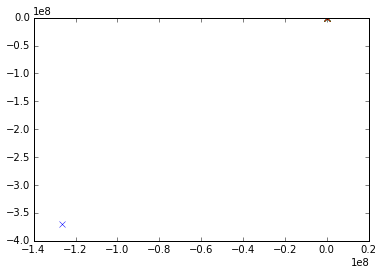

------------------------------------------5 6---------------


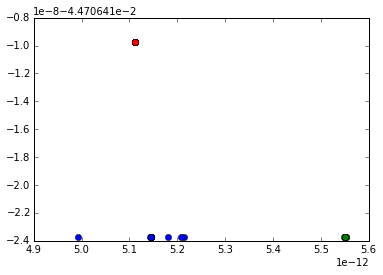

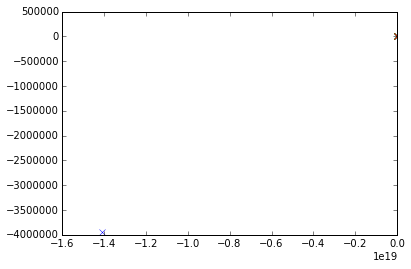

fold number: 3
178 40 3
------------------------------------------1 2---------------


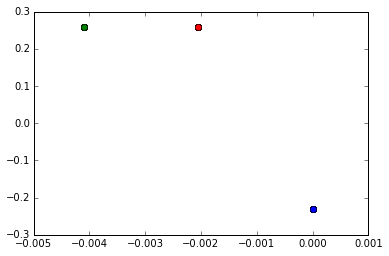

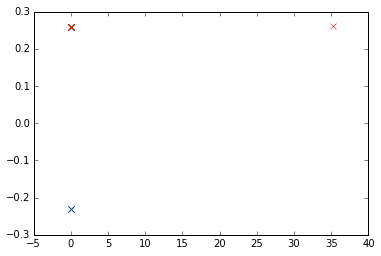

------------------------------------------3 4---------------


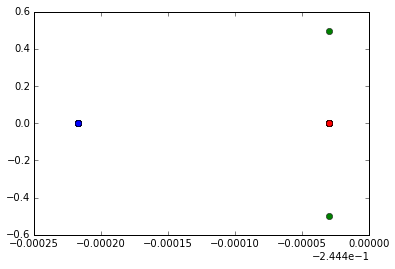

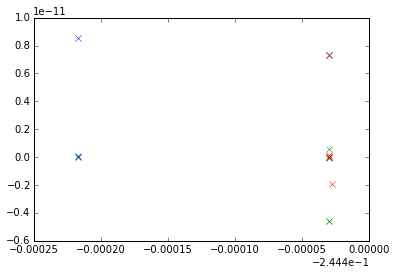

------------------------------------------5 6---------------


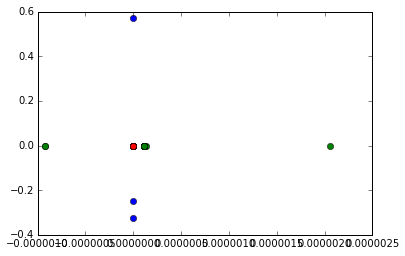

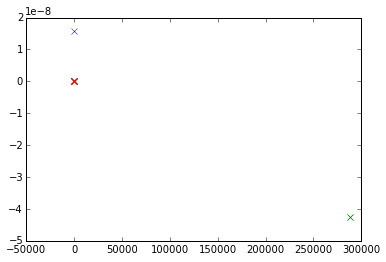

fold number: 4
178 40 3
------------------------------------------1 2---------------


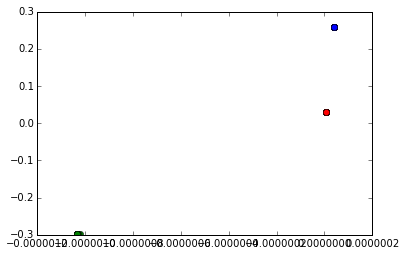

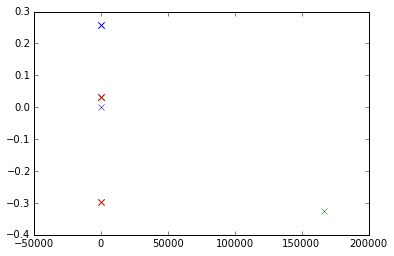

------------------------------------------3 4---------------


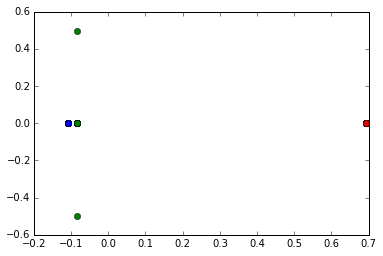

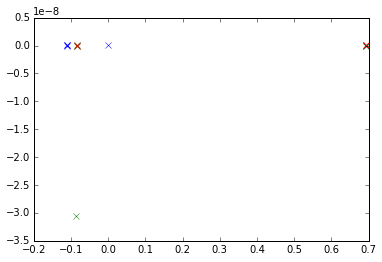

------------------------------------------5 6---------------


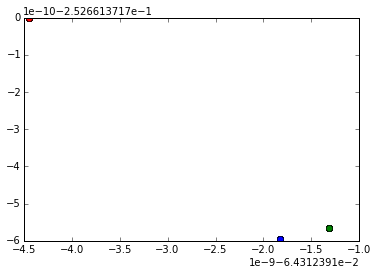

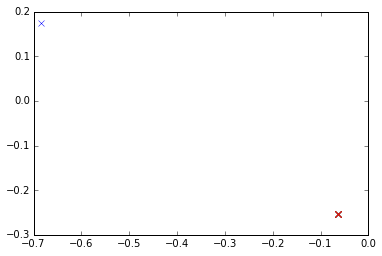

fold number: 5
178 40 3
------------------------------------------1 2---------------


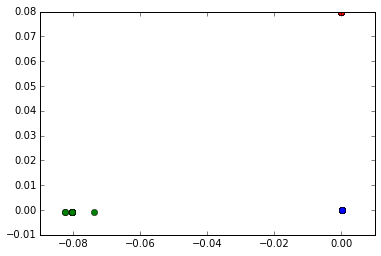

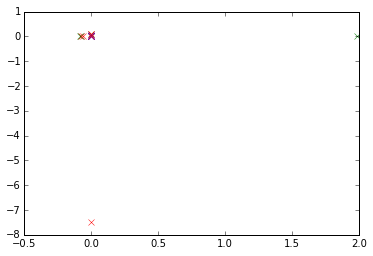

------------------------------------------3 4---------------


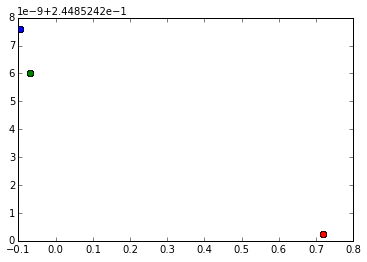

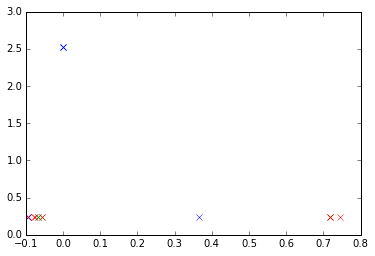

------------------------------------------5 6---------------


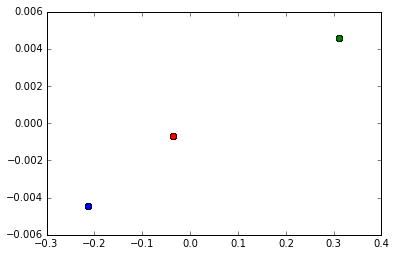

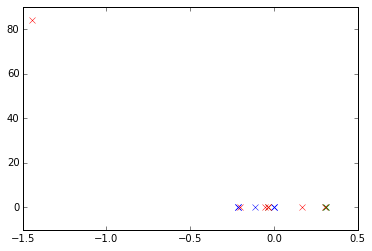

fold number: 6
178 40 3
------------------------------------------1 2---------------


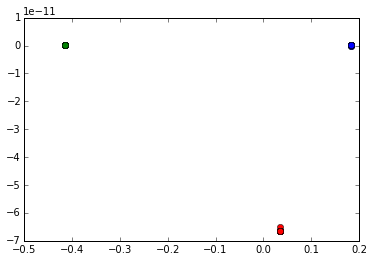

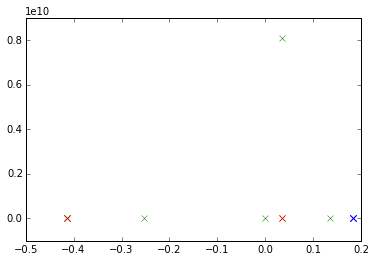

------------------------------------------3 4---------------


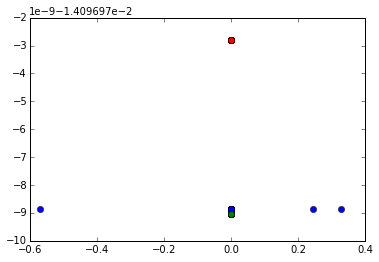

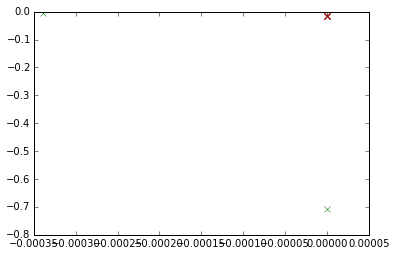

------------------------------------------5 6---------------


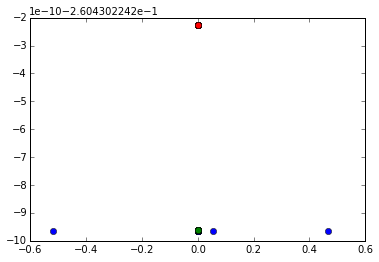

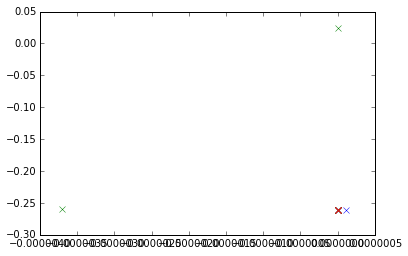

fold number: 7
178 40 3
------------------------------------------1 2---------------


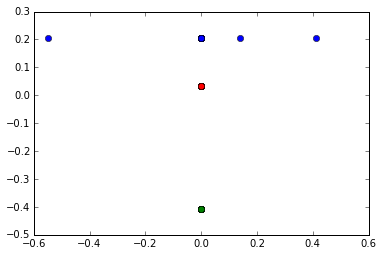

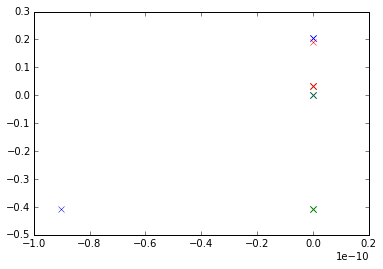

------------------------------------------3 4---------------


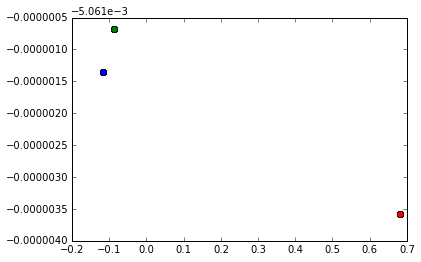

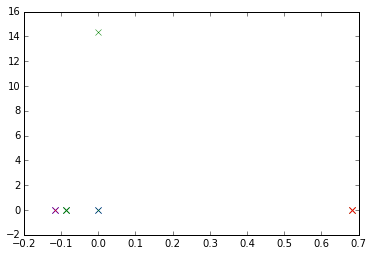

------------------------------------------5 6---------------


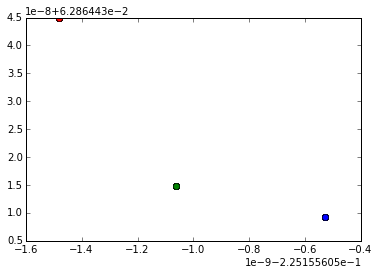

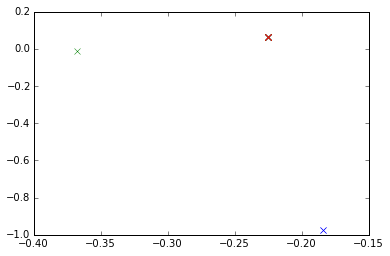

fold number: 8
178 40 3
------------------------------------------1 2---------------


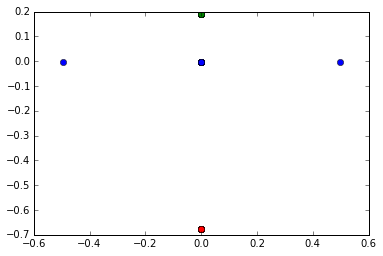

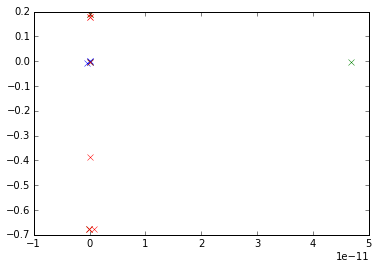

------------------------------------------3 4---------------


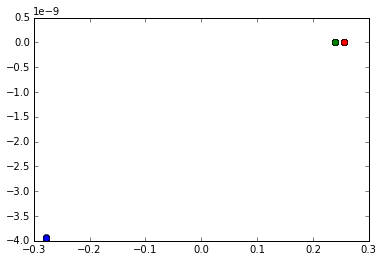

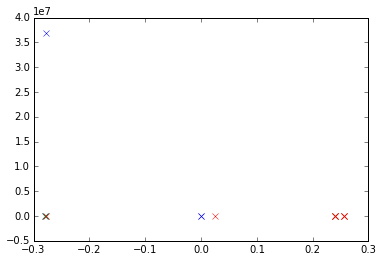

------------------------------------------5 6---------------


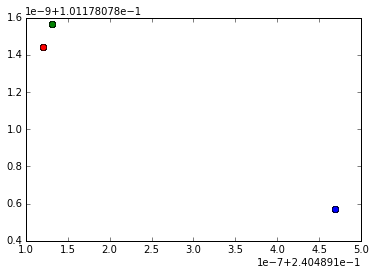

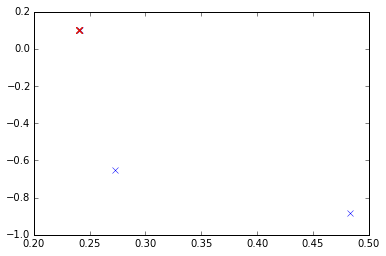

fold number: 9
178 40 3
------------------------------------------1 2---------------


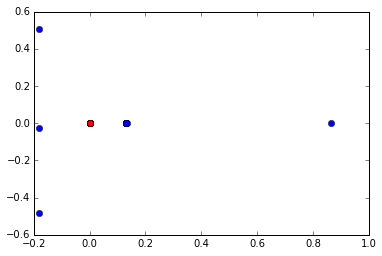

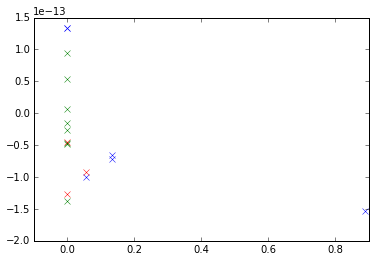

------------------------------------------3 4---------------


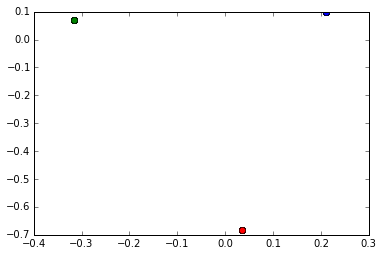

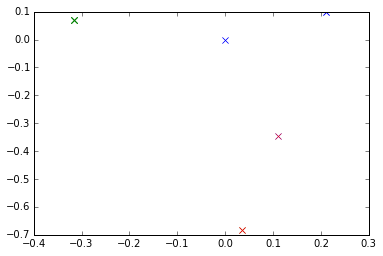

------------------------------------------5 6---------------


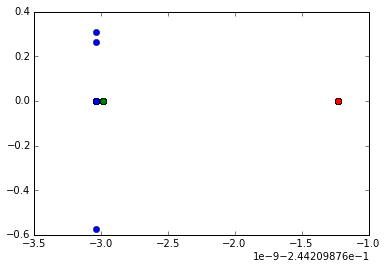

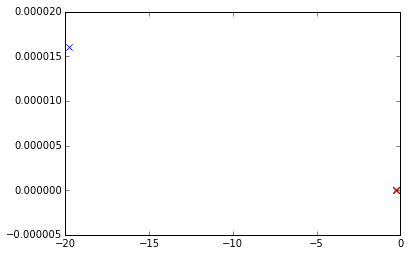

--------------------------------------- sigma:  0.03


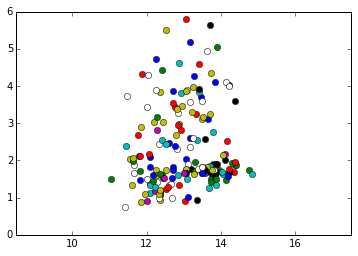

fold number: 0
178 40 3
------------------------------------------1 2---------------


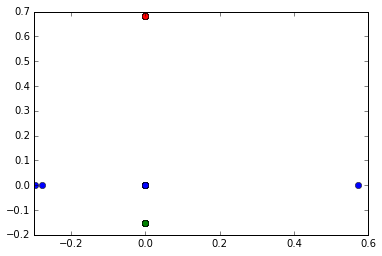

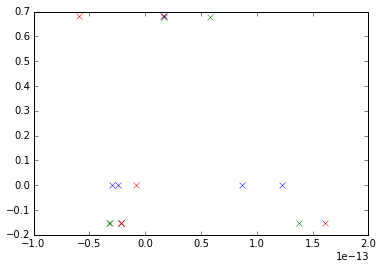

------------------------------------------3 4---------------


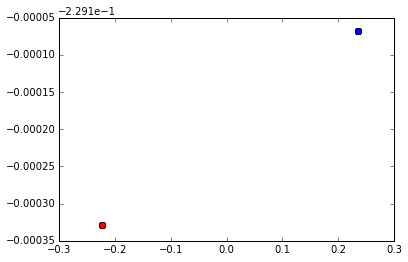

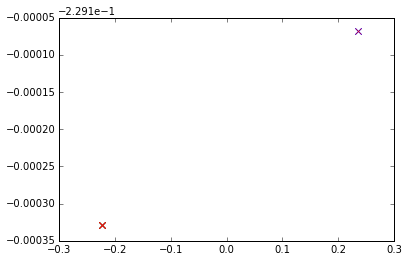

------------------------------------------5 6---------------


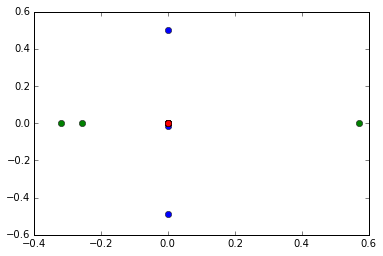

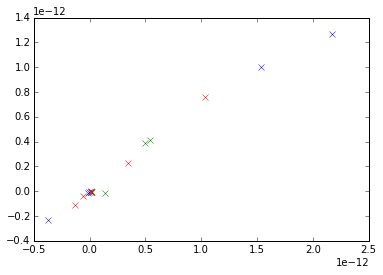

fold number: 1
178 40 3
------------------------------------------1 2---------------


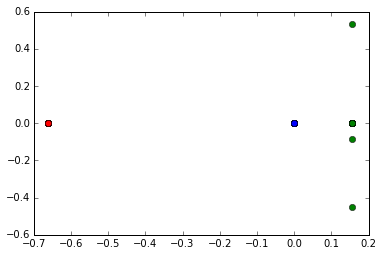

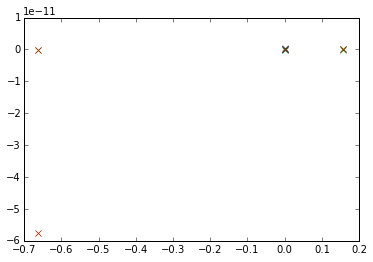

------------------------------------------3 4---------------


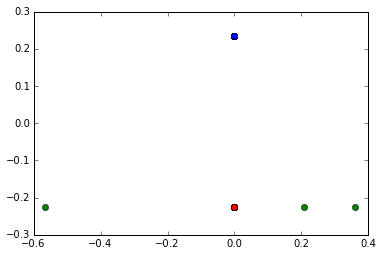

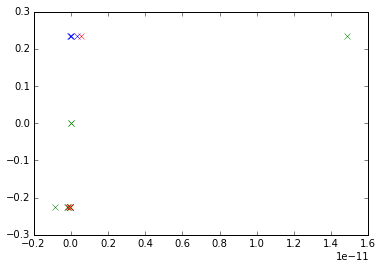

------------------------------------------5 6---------------


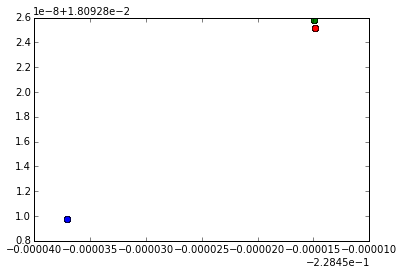

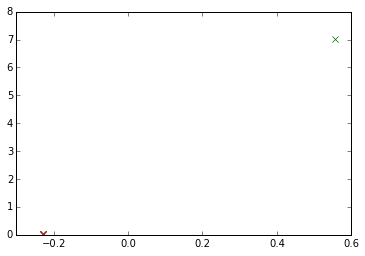

fold number: 2
178 40 3
------------------------------------------1 2---------------


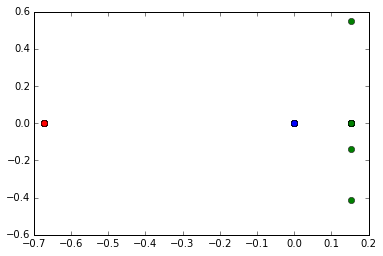

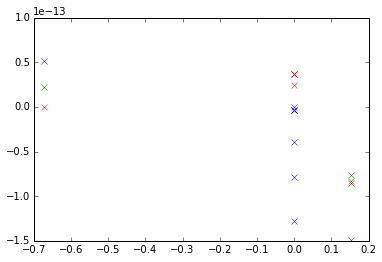

------------------------------------------3 4---------------


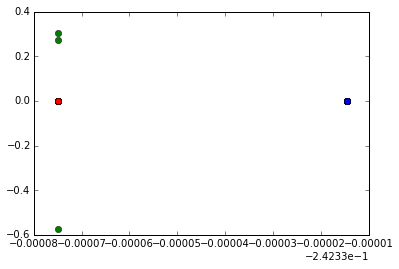

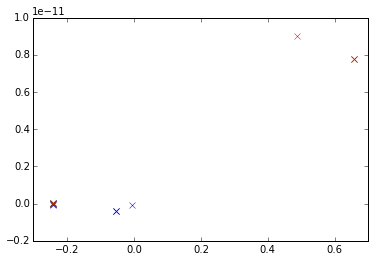

------------------------------------------5 6---------------


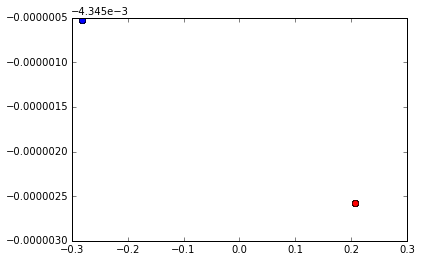

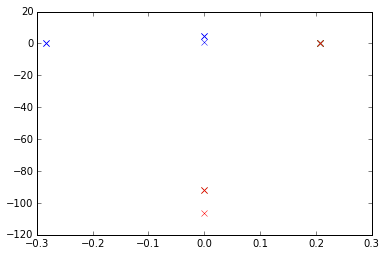

fold number: 3
178 40 3
------------------------------------------1 2---------------


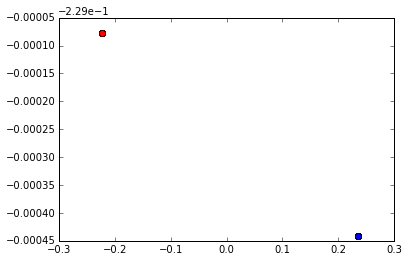

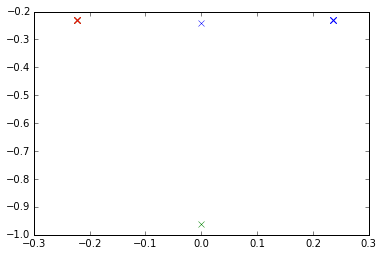

------------------------------------------3 4---------------


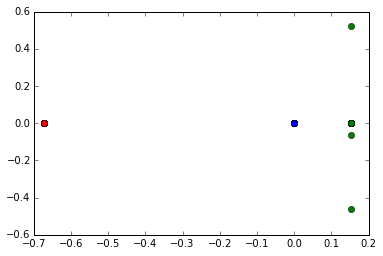

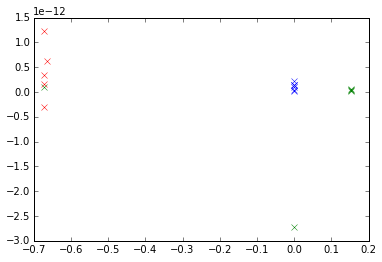

------------------------------------------5 6---------------


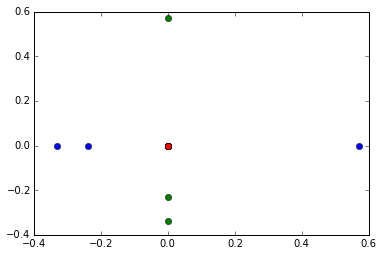

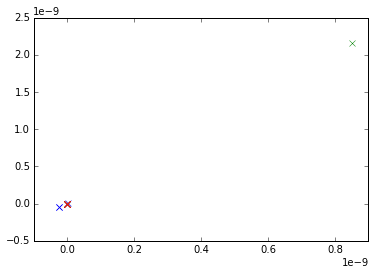

fold number: 4
178 40 3
------------------------------------------1 2---------------


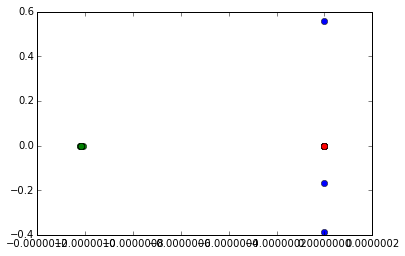

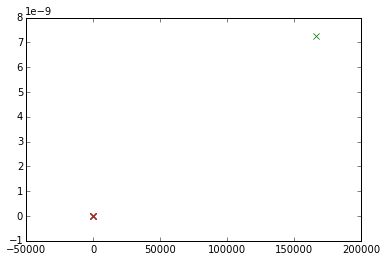

------------------------------------------3 4---------------


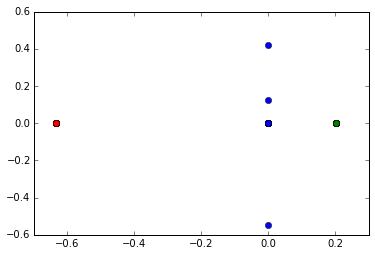

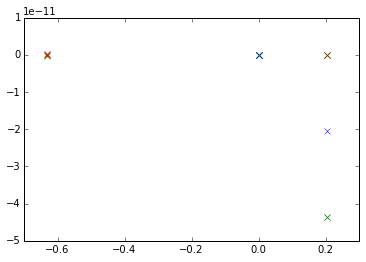

------------------------------------------5 6---------------


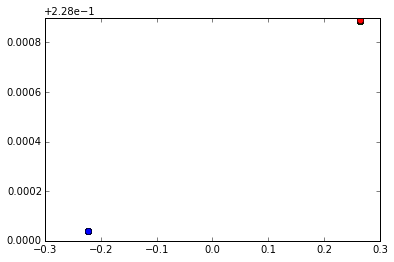

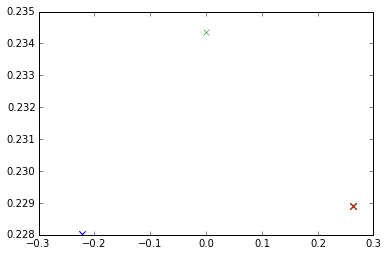

fold number: 5
178 40 3
------------------------------------------1 2---------------


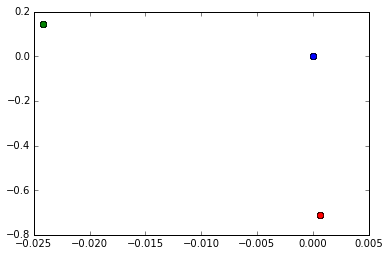

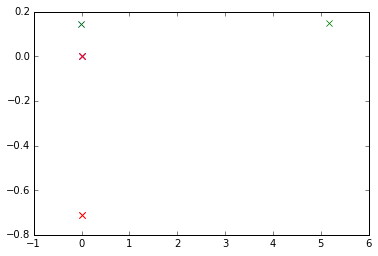

------------------------------------------3 4---------------


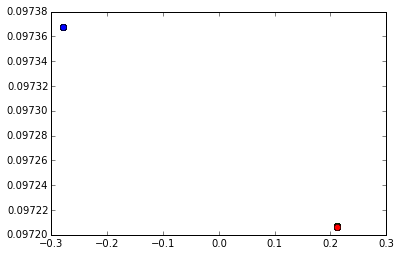

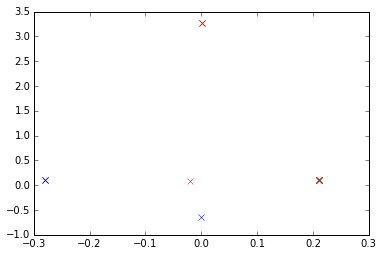

------------------------------------------5 6---------------


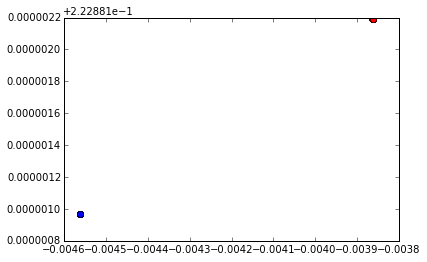

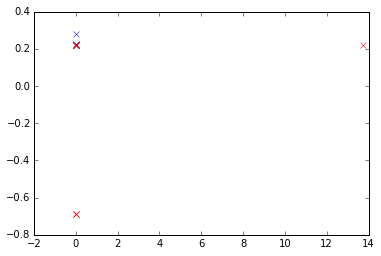

fold number: 6
178 40 3
------------------------------------------1 2---------------


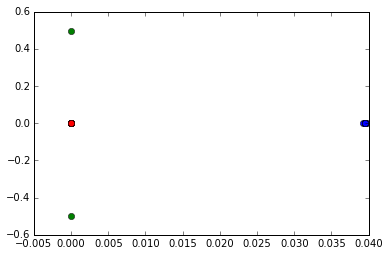

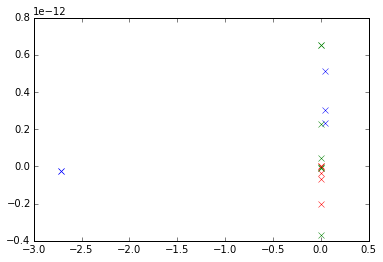

------------------------------------------3 4---------------


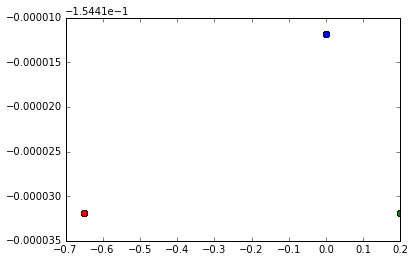

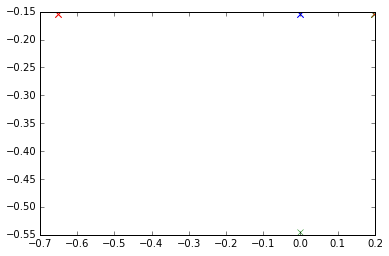

------------------------------------------5 6---------------


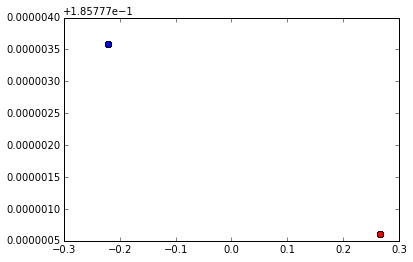

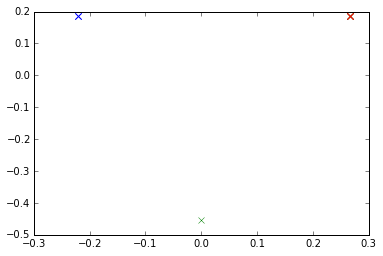

fold number: 7
178 40 3
------------------------------------------1 2---------------


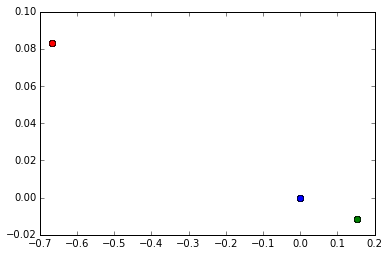

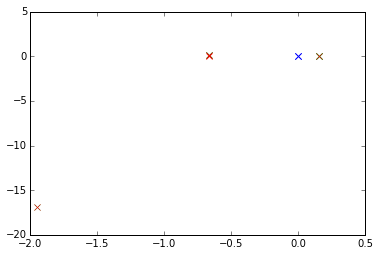

------------------------------------------3 4---------------


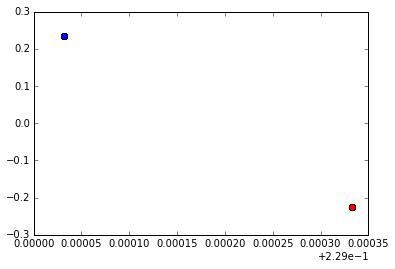

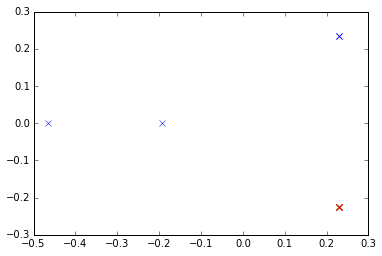

------------------------------------------5 6---------------


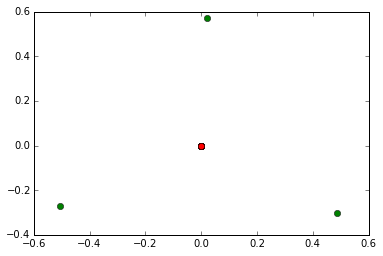

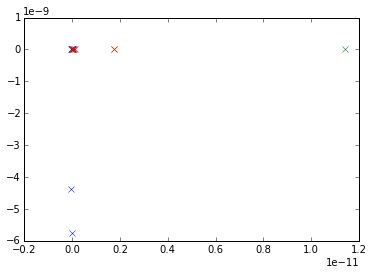

fold number: 8
178 40 3
------------------------------------------1 2---------------


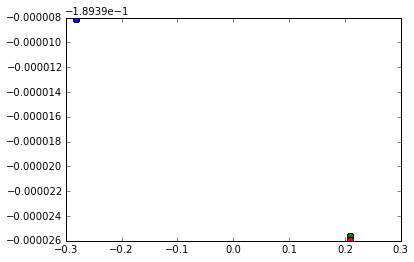

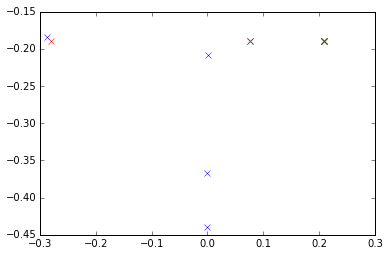

------------------------------------------3 4---------------


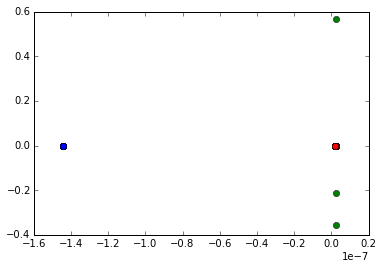

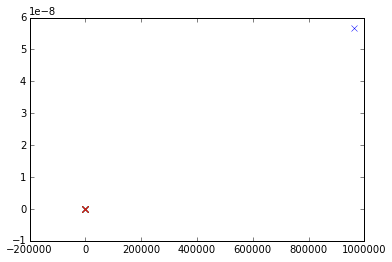

------------------------------------------5 6---------------


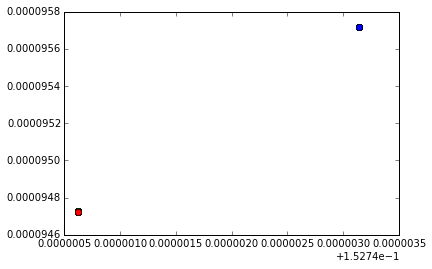

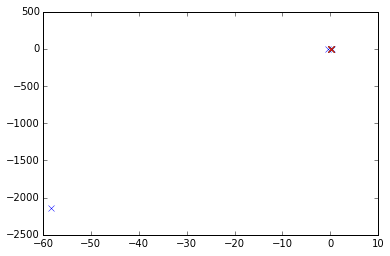

fold number: 9
178 40 3
------------------------------------------1 2---------------


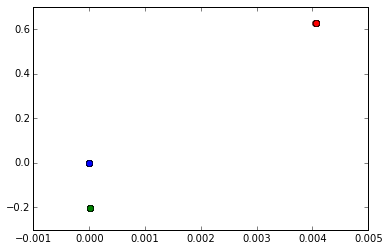

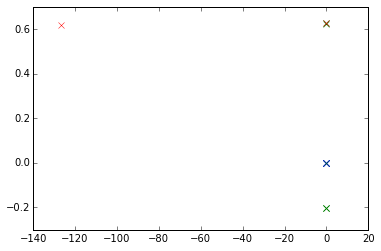

------------------------------------------3 4---------------


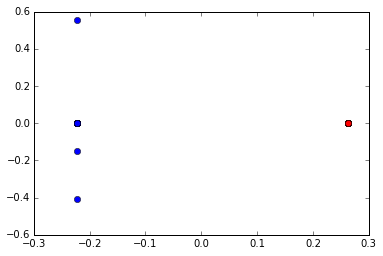

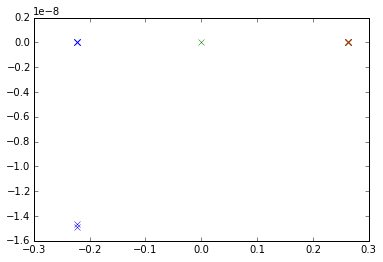

------------------------------------------5 6---------------


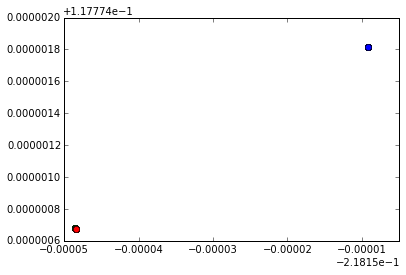

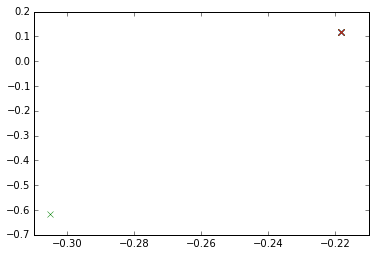

--------------------------------------- sigma:  0.04


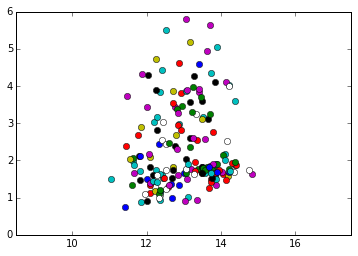

fold number: 0
178 40 3
------------------------------------------1 2---------------


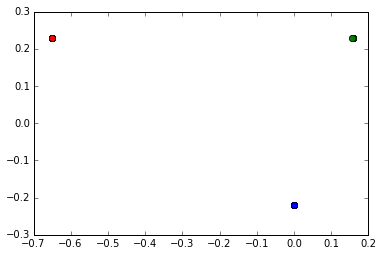

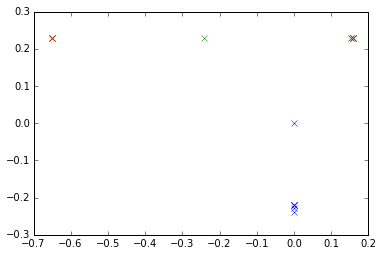

------------------------------------------3 4---------------


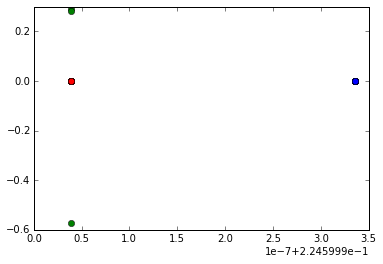

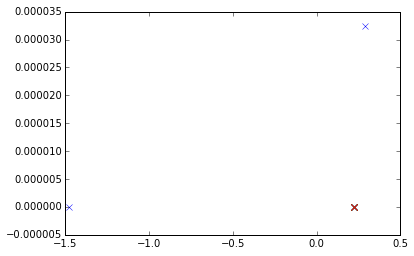

------------------------------------------5 6---------------


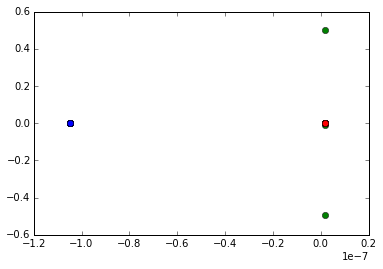

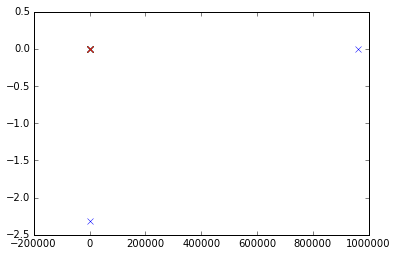

fold number: 1
178 40 3
------------------------------------------1 2---------------


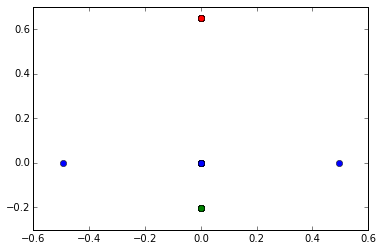

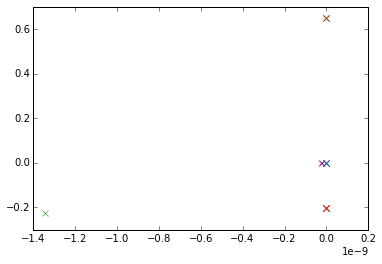

------------------------------------------3 4---------------


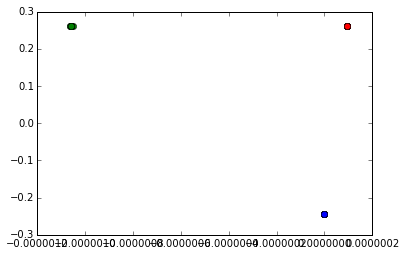

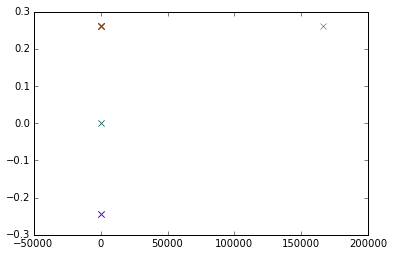

------------------------------------------5 6---------------


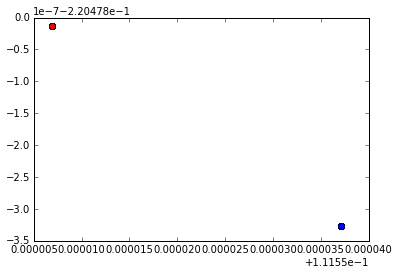

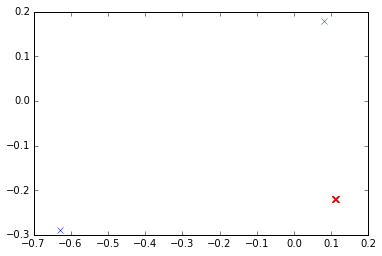

fold number: 2
178 40 3
------------------------------------------1 2---------------


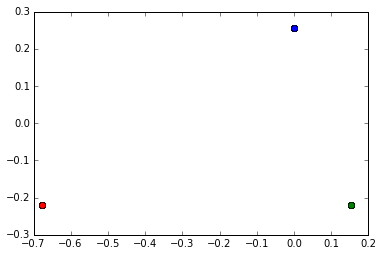

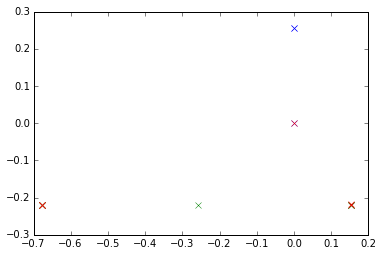

------------------------------------------3 4---------------


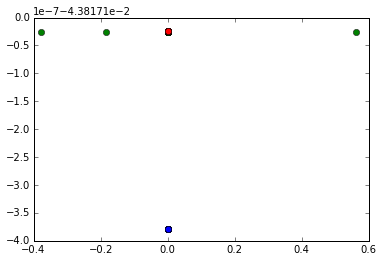

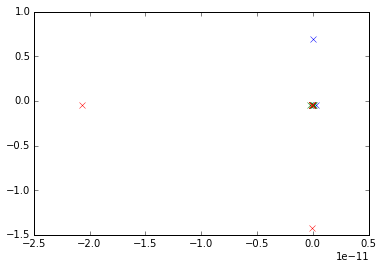

------------------------------------------5 6---------------


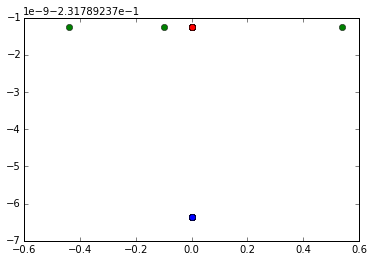

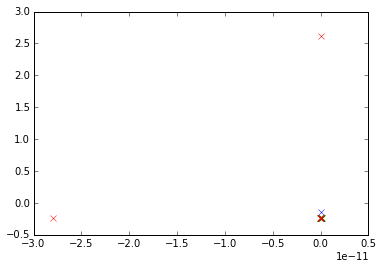

fold number: 3
178 40 3
------------------------------------------1 2---------------


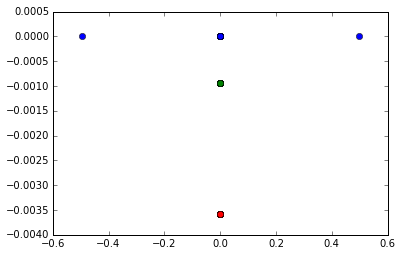

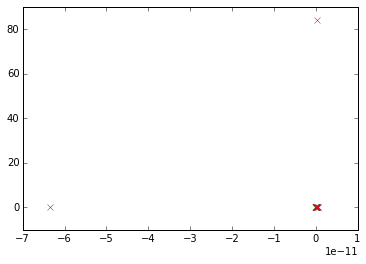

------------------------------------------3 4---------------


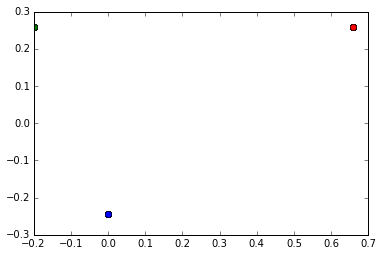

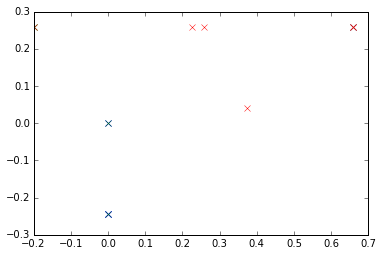

------------------------------------------5 6---------------


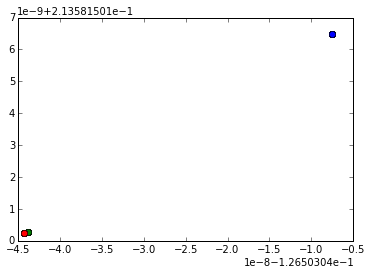

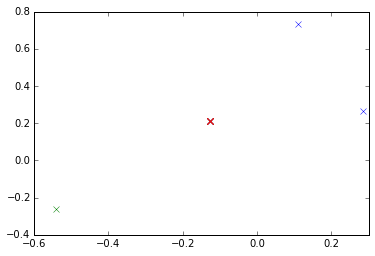

fold number: 4
178 40 3
------------------------------------------1 2---------------


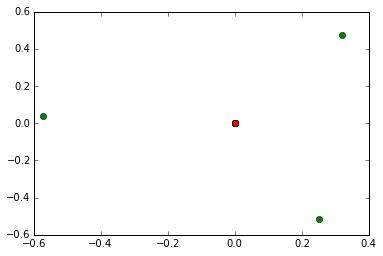

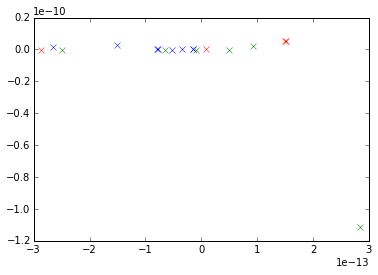

------------------------------------------3 4---------------


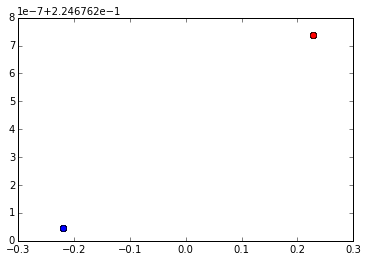

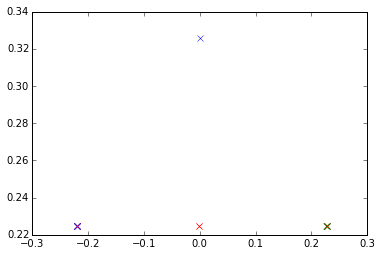

------------------------------------------5 6---------------


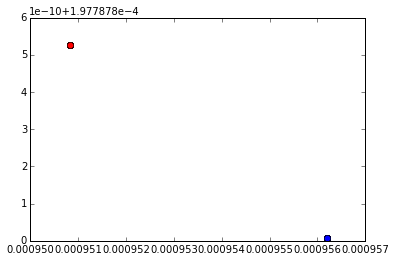

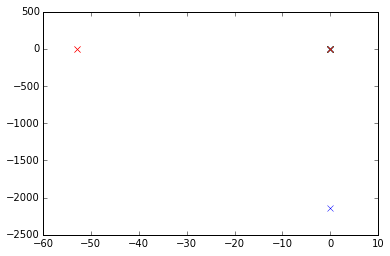

fold number: 5
178 40 3
------------------------------------------1 2---------------


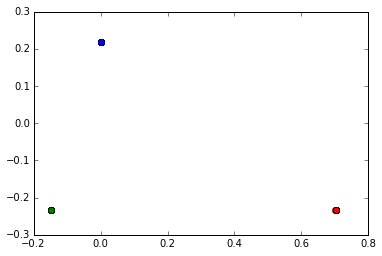

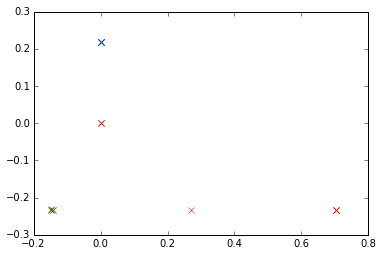

------------------------------------------3 4---------------


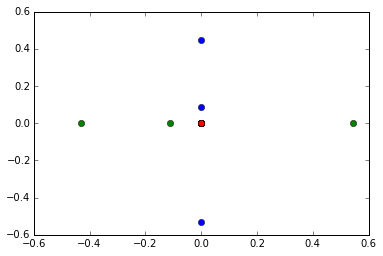

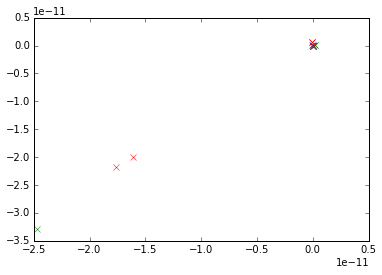

------------------------------------------5 6---------------


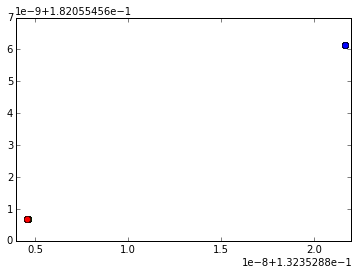

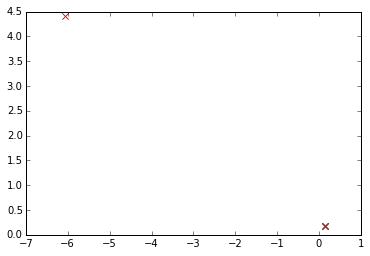

fold number: 6
178 40 3
------------------------------------------1 2---------------


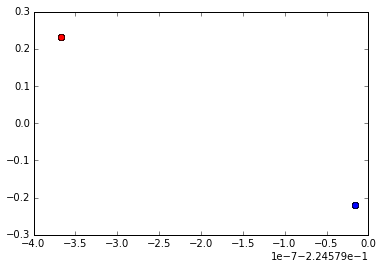

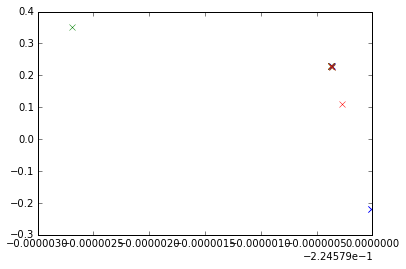

------------------------------------------3 4---------------


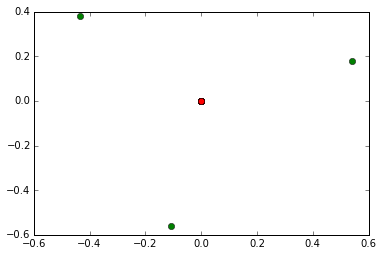

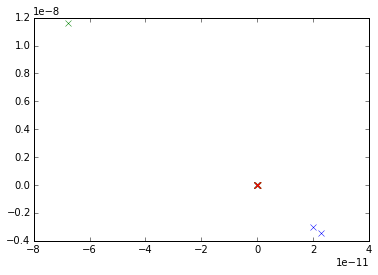

------------------------------------------5 6---------------


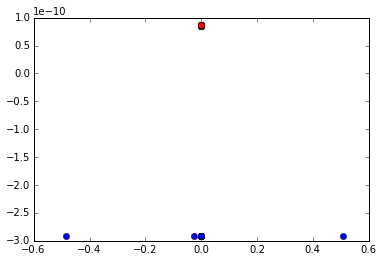

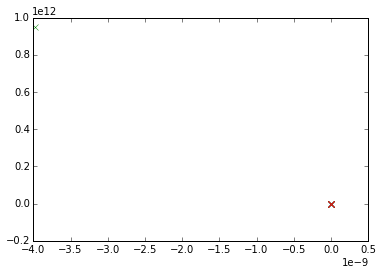

fold number: 7
178 40 3
------------------------------------------1 2---------------


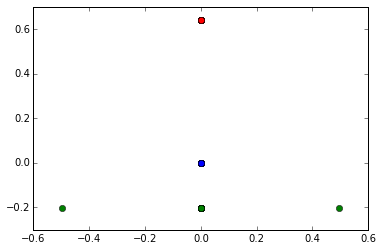

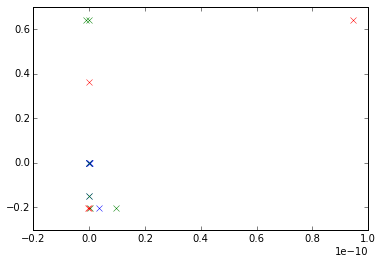

------------------------------------------3 4---------------


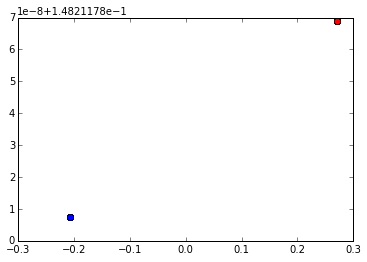

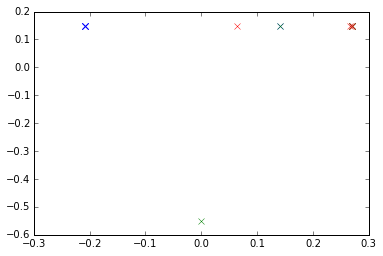

------------------------------------------5 6---------------


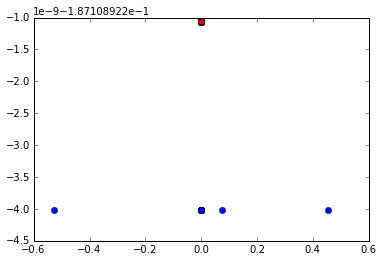

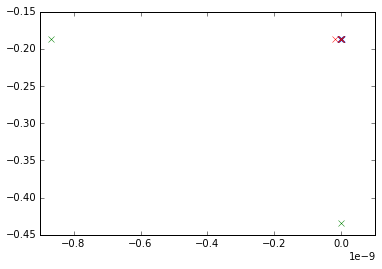

fold number: 8
178 40 3
------------------------------------------1 2---------------


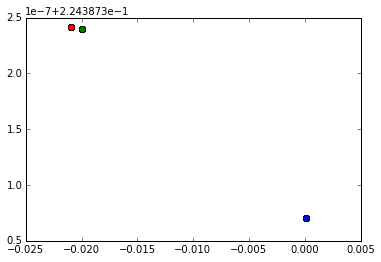

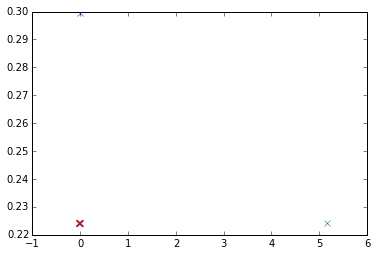

------------------------------------------3 4---------------


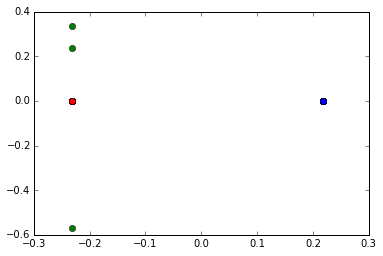

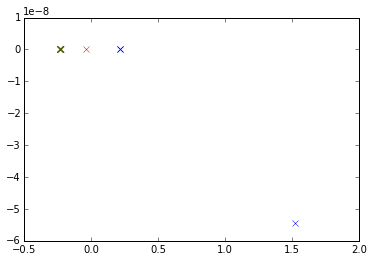

------------------------------------------5 6---------------


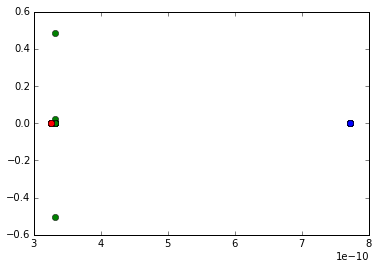

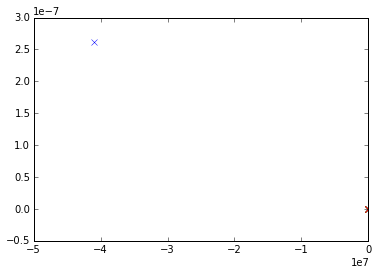

fold number: 9
178 40 3
------------------------------------------1 2---------------


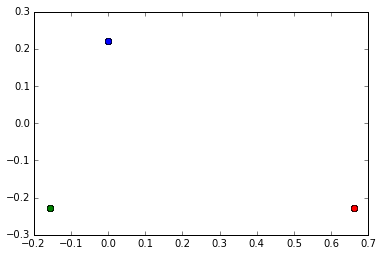

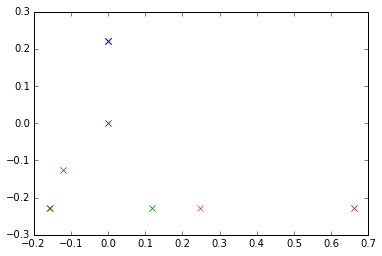

------------------------------------------3 4---------------


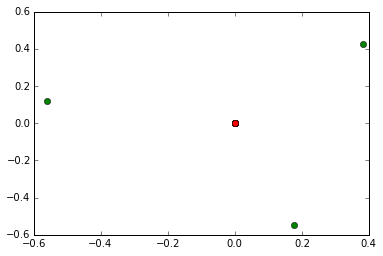

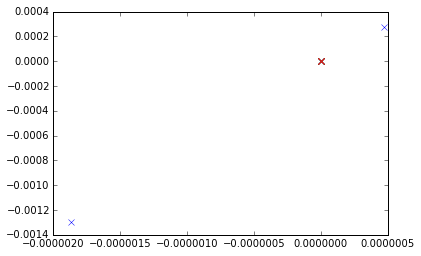

------------------------------------------5 6---------------


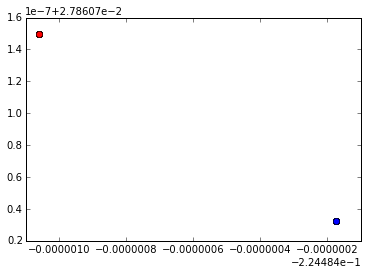

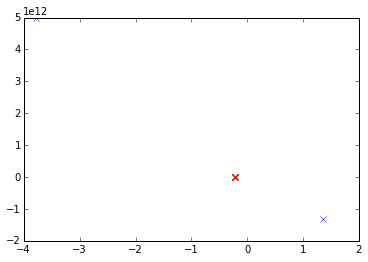

--------------------------------------- sigma:  0.05


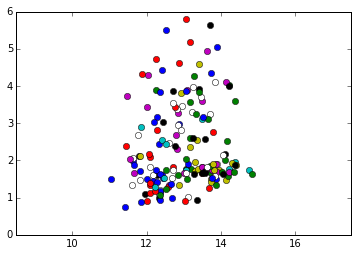

fold number: 0
178 40 3
------------------------------------------1 2---------------


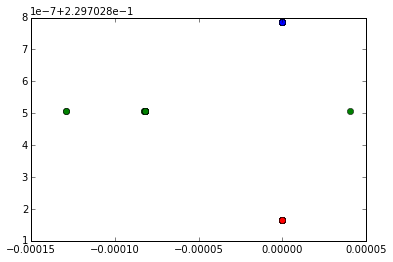

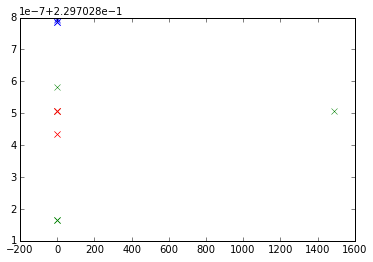

------------------------------------------3 4---------------


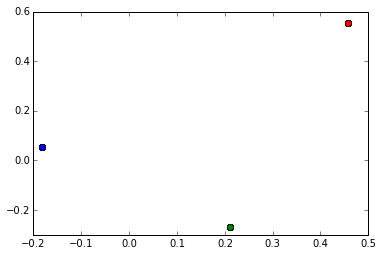

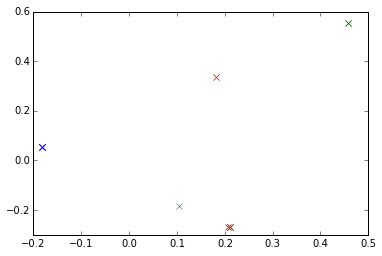

------------------------------------------5 6---------------


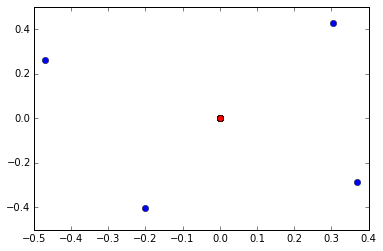

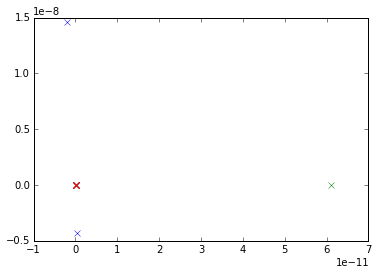

fold number: 1
178 40 3
------------------------------------------1 2---------------


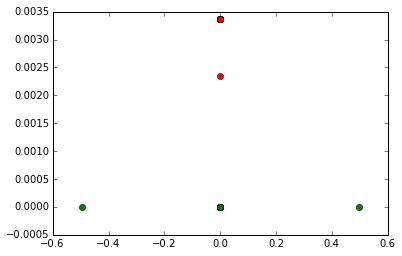

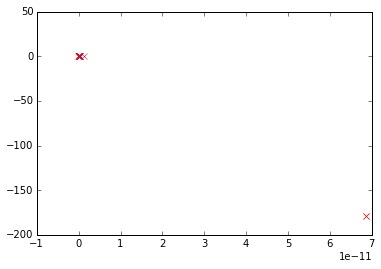

------------------------------------------3 4---------------


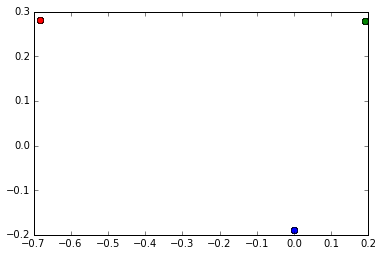

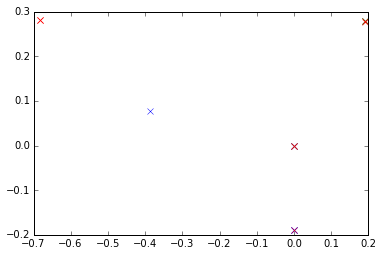

------------------------------------------5 6---------------


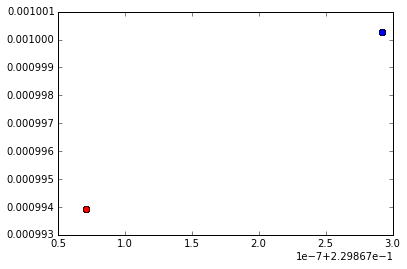

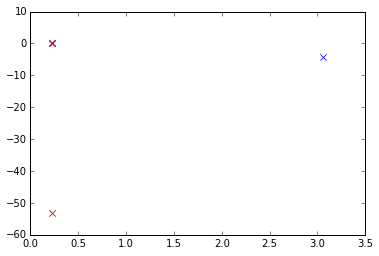

fold number: 2
178 40 3
------------------------------------------1 2---------------


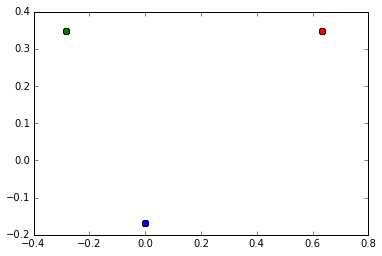

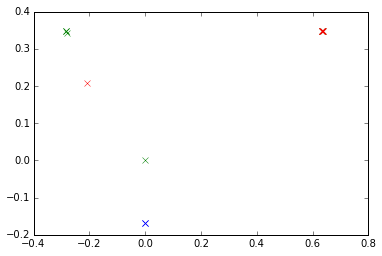

------------------------------------------3 4---------------


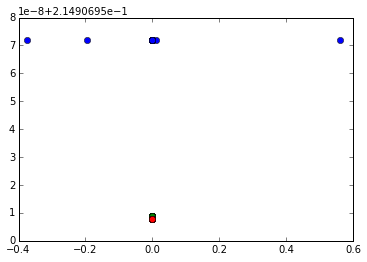

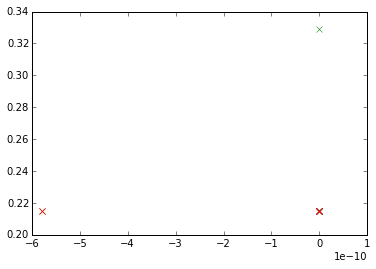

------------------------------------------5 6---------------


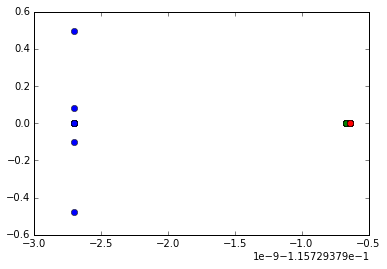

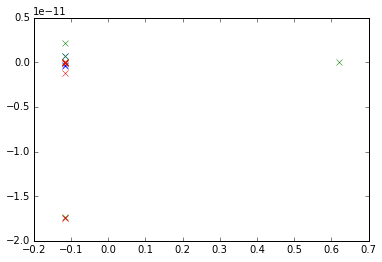

fold number: 3
178 40 3
------------------------------------------1 2---------------


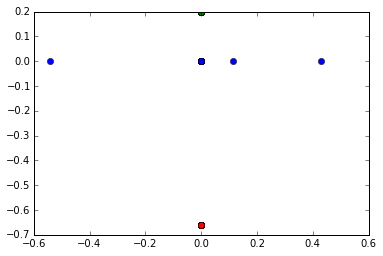

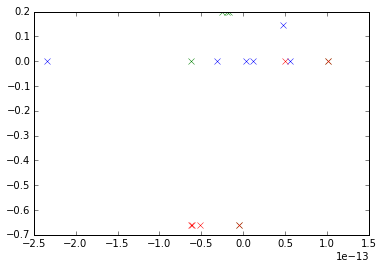

------------------------------------------3 4---------------


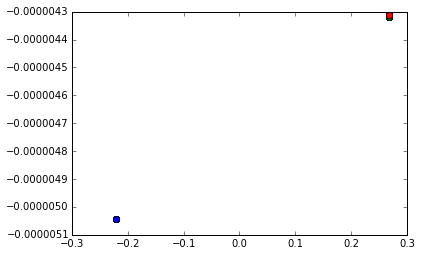

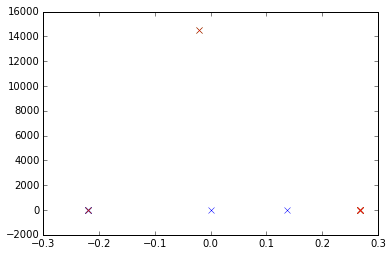

------------------------------------------5 6---------------


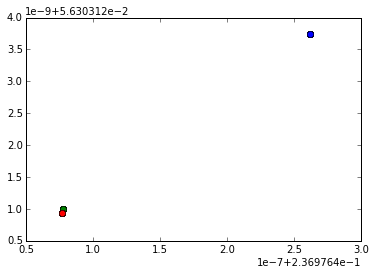

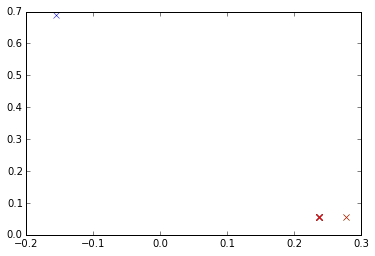

fold number: 4
178 40 3
------------------------------------------1 2---------------


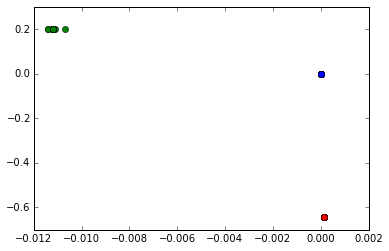

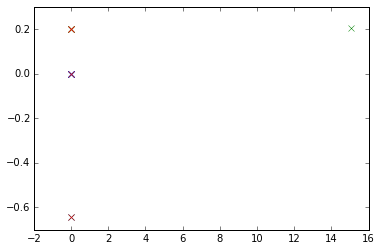

------------------------------------------3 4---------------


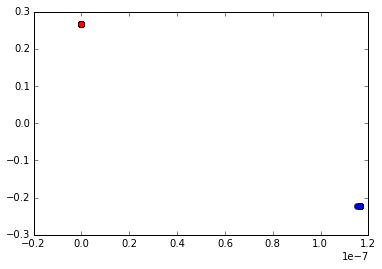

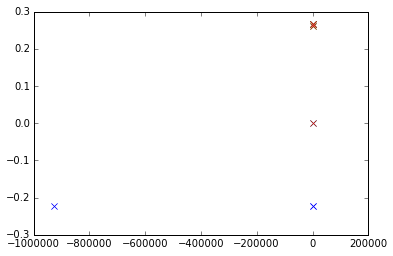

------------------------------------------5 6---------------


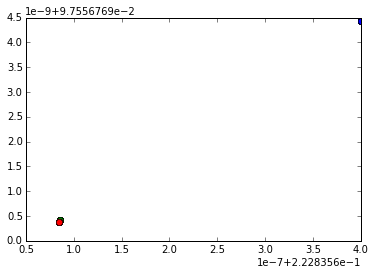

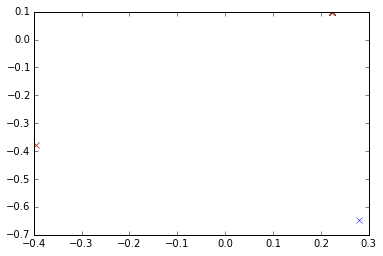

fold number: 5
178 40 3
------------------------------------------1 2---------------


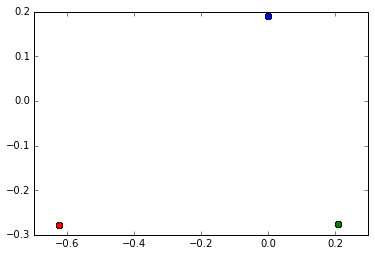

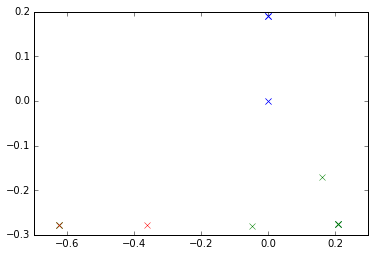

------------------------------------------3 4---------------


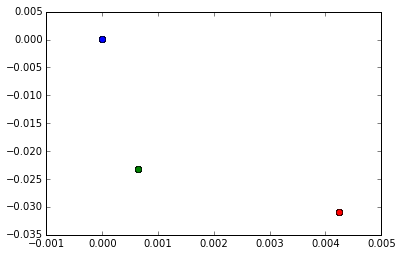

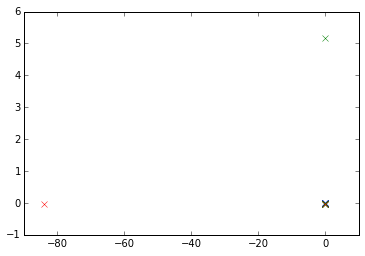

------------------------------------------5 6---------------


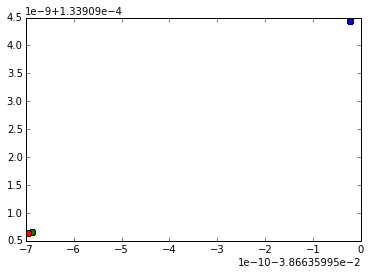

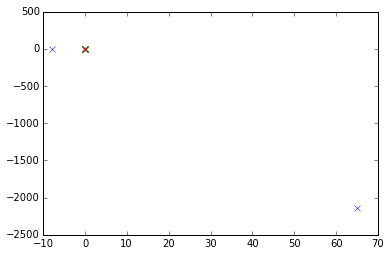

fold number: 6
178 40 3
------------------------------------------1 2---------------


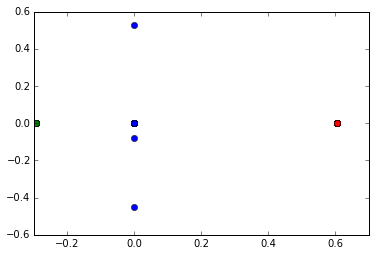

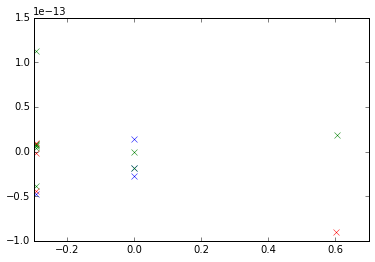

------------------------------------------3 4---------------


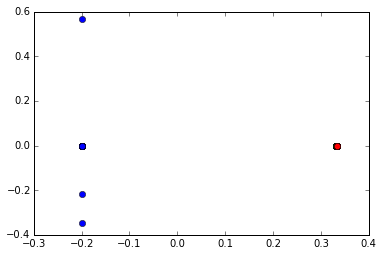

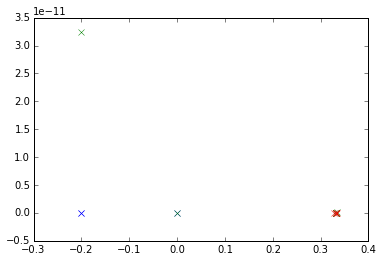

------------------------------------------5 6---------------


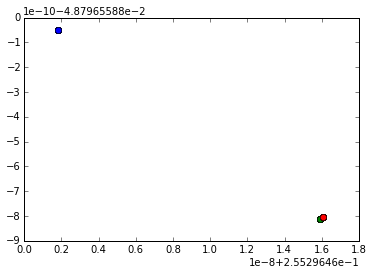

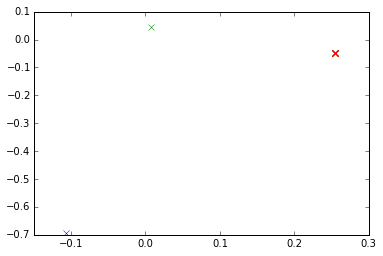

fold number: 7
178 40 3
------------------------------------------1 2---------------


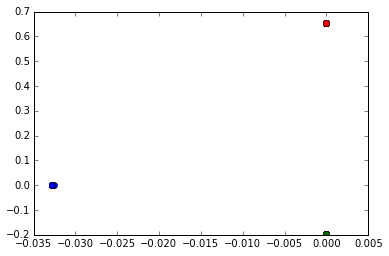

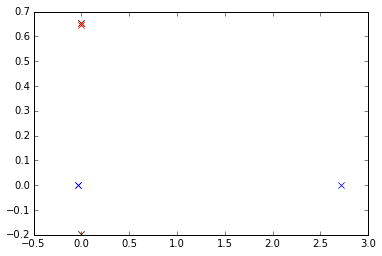

------------------------------------------3 4---------------


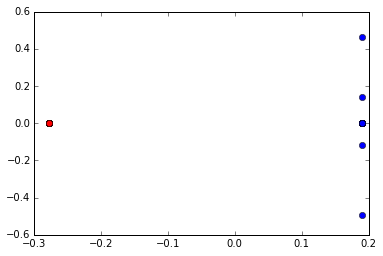

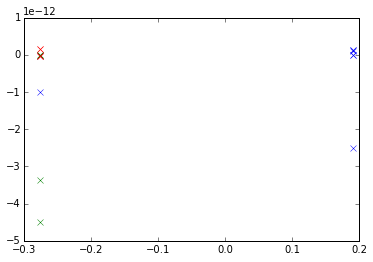

------------------------------------------5 6---------------


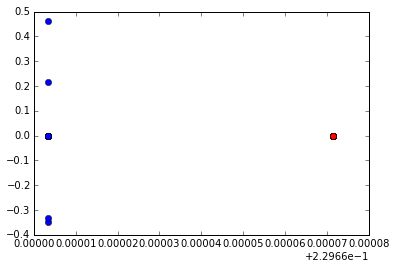

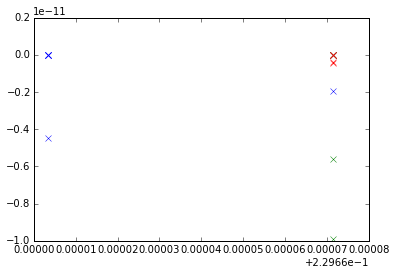

fold number: 8
178 40 3
------------------------------------------1 2---------------


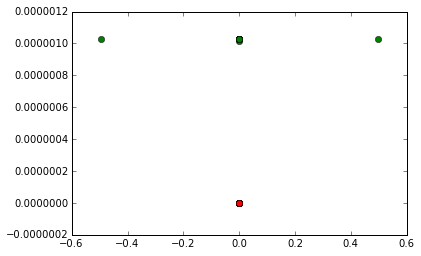

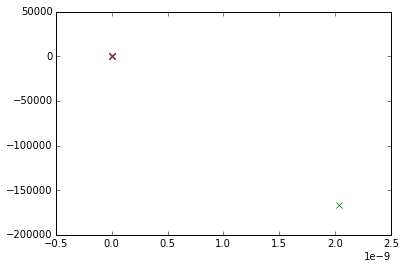

------------------------------------------3 4---------------


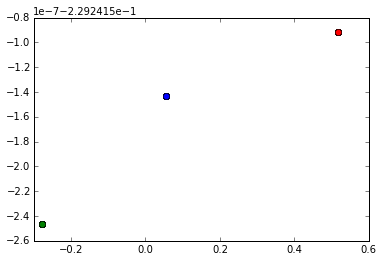

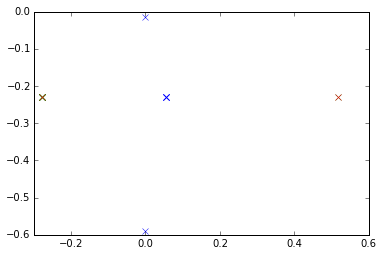

------------------------------------------5 6---------------


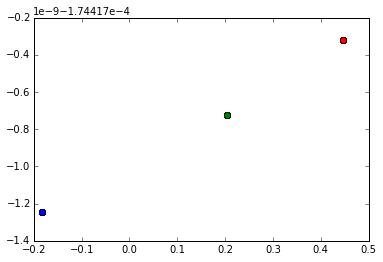

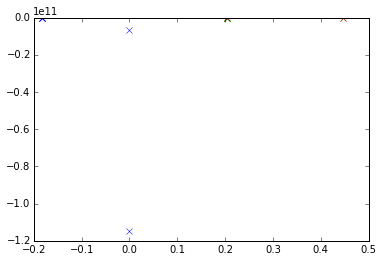

fold number: 9
178 40 3
------------------------------------------1 2---------------


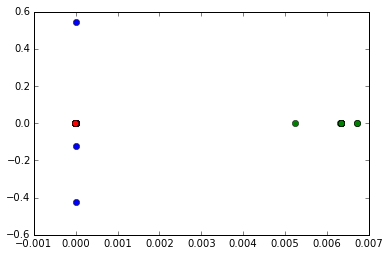

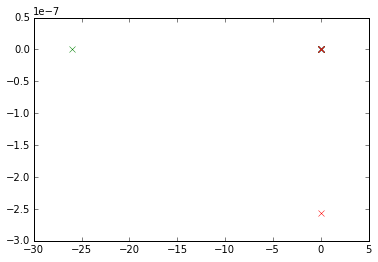

------------------------------------------3 4---------------


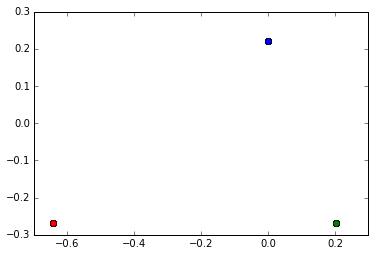

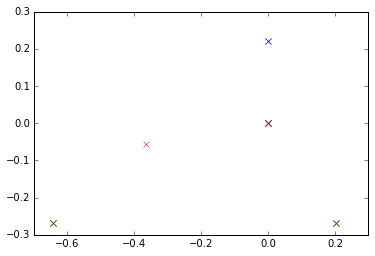

------------------------------------------5 6---------------


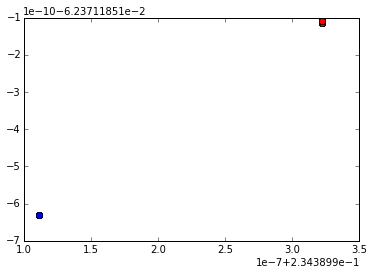

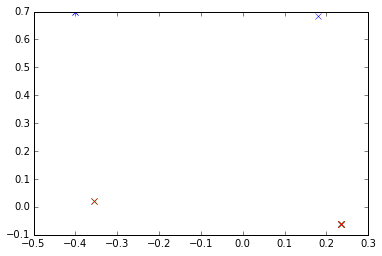

--------------------------------------- sigma:  0.1


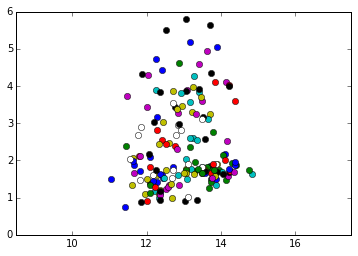

fold number: 0
178 40 3
------------------------------------------1 2---------------


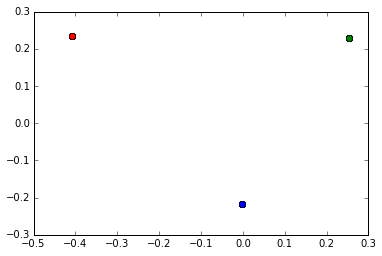

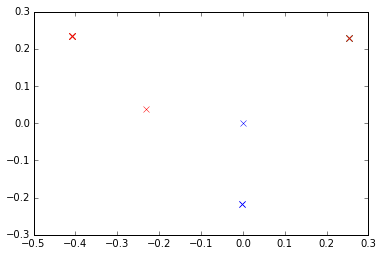

------------------------------------------3 4---------------


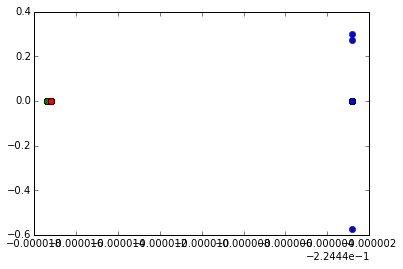

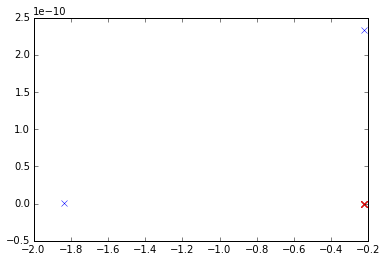

------------------------------------------5 6---------------


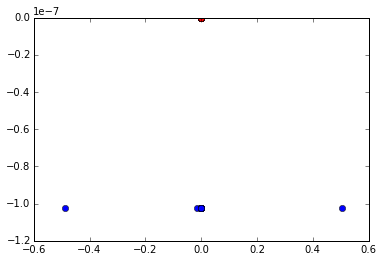

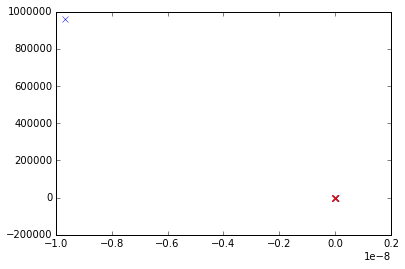

fold number: 1
178 40 3
------------------------------------------1 2---------------


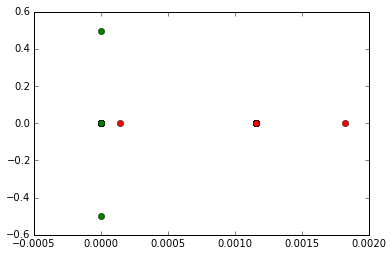

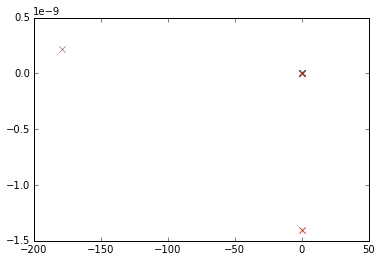

------------------------------------------3 4---------------


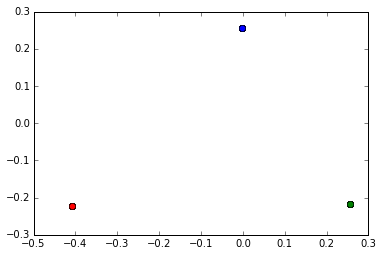

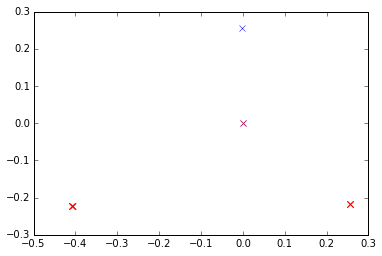

------------------------------------------5 6---------------


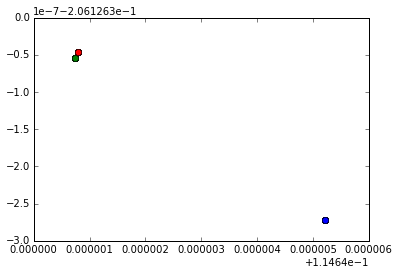

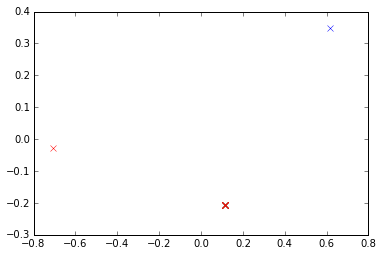

fold number: 2
178 40 3
------------------------------------------1 2---------------


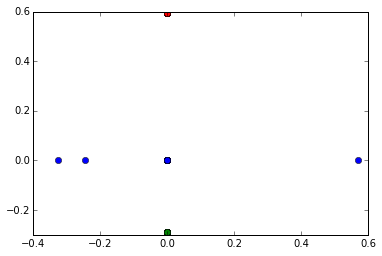

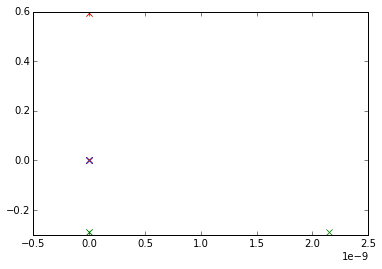

------------------------------------------3 4---------------


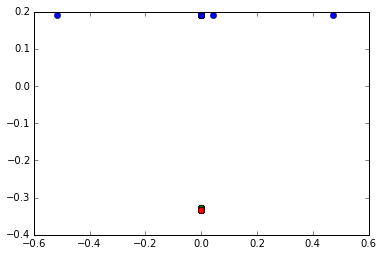

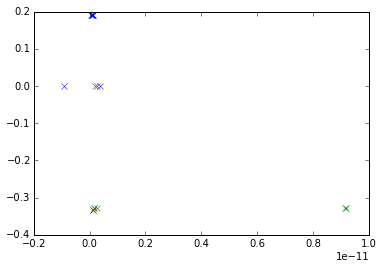

------------------------------------------5 6---------------


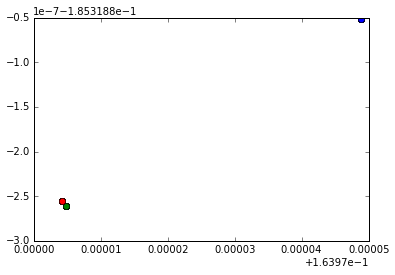

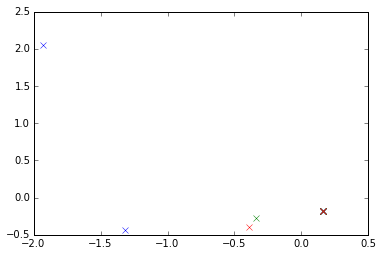

fold number: 3
178 40 3
------------------------------------------1 2---------------


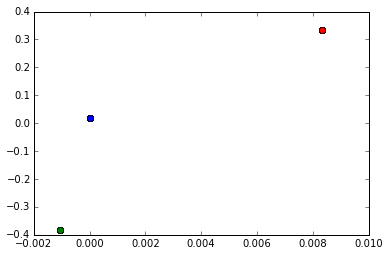

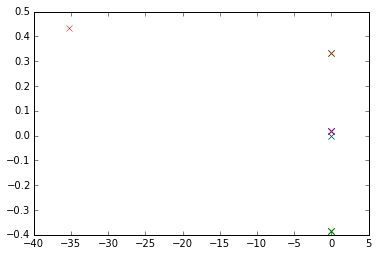

------------------------------------------3 4---------------


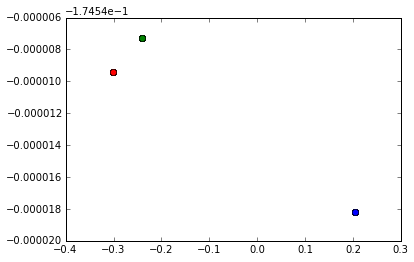

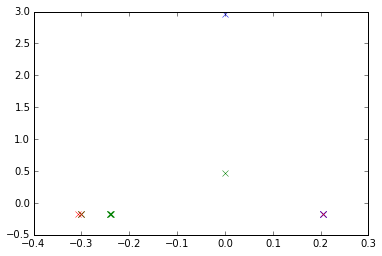

------------------------------------------5 6---------------


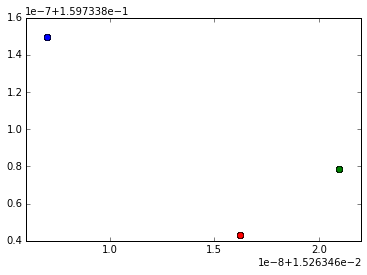

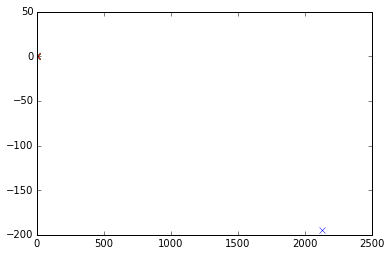

fold number: 4
178 40 3
------------------------------------------1 2---------------


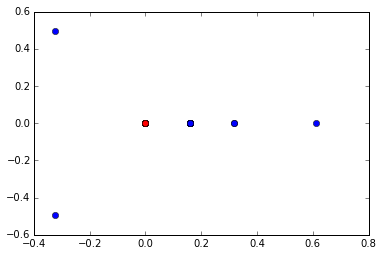

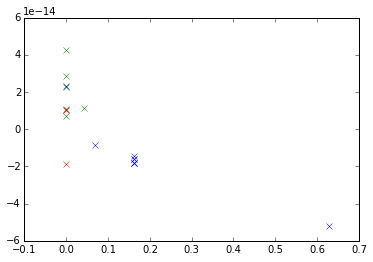

------------------------------------------3 4---------------


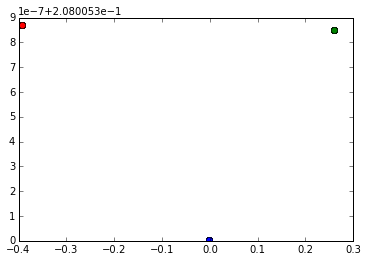

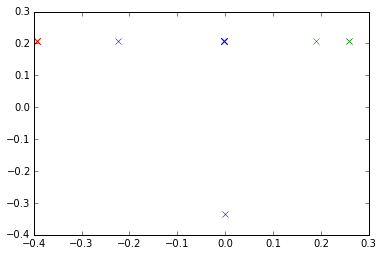

------------------------------------------5 6---------------


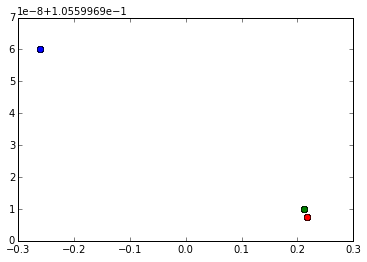

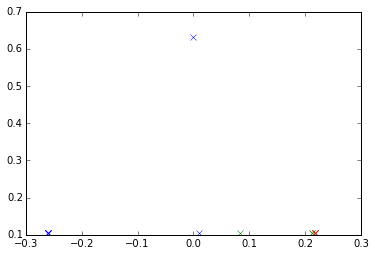

fold number: 5
178 40 3
------------------------------------------1 2---------------


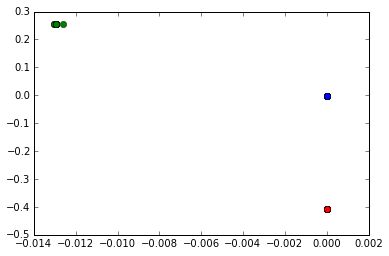

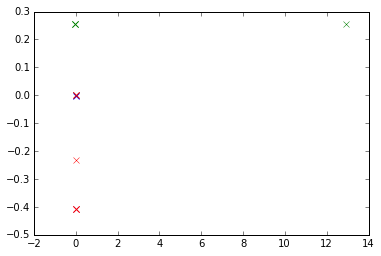

------------------------------------------3 4---------------


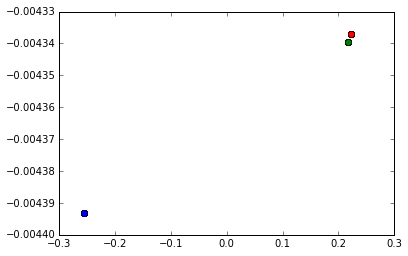

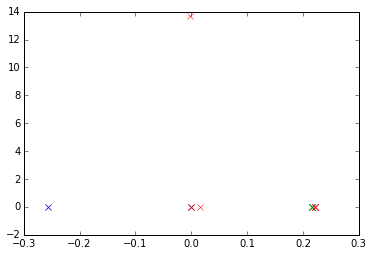

------------------------------------------5 6---------------


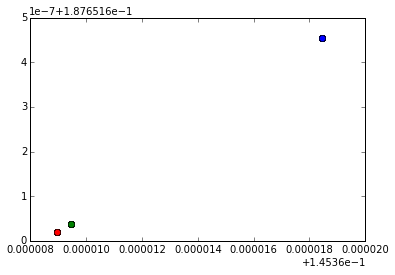

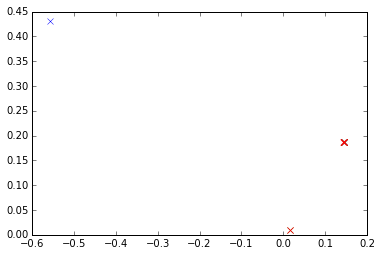

fold number: 6
178 40 3
------------------------------------------1 2---------------


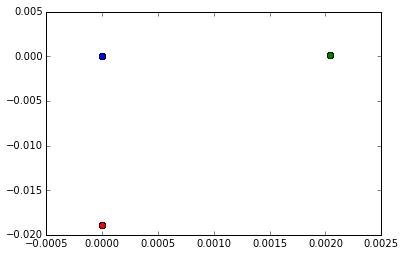

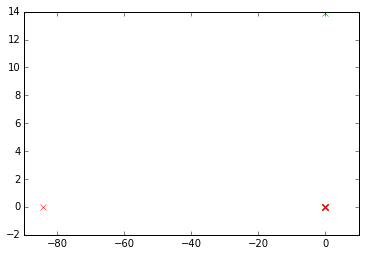

------------------------------------------3 4---------------


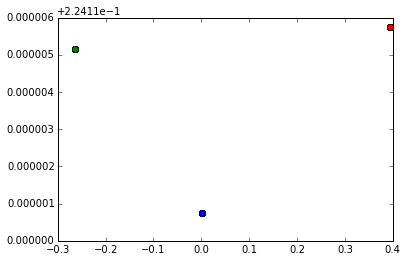

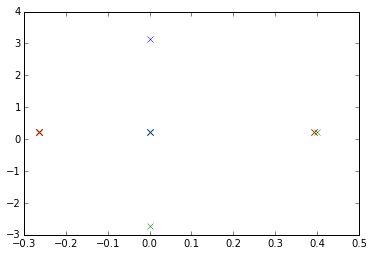

------------------------------------------5 6---------------


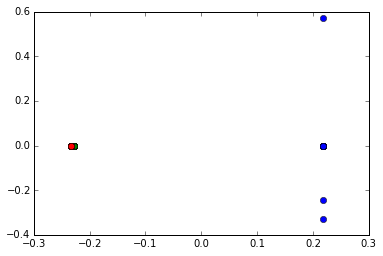

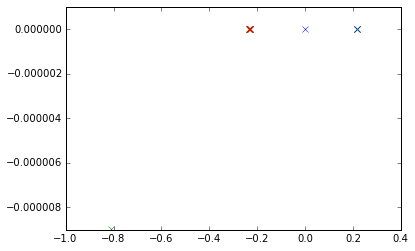

fold number: 7
178 40 3
------------------------------------------1 2---------------


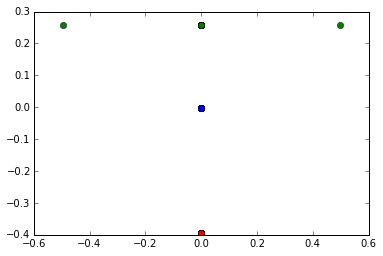

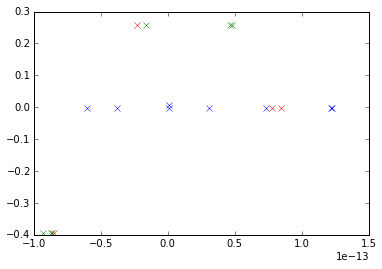

------------------------------------------3 4---------------


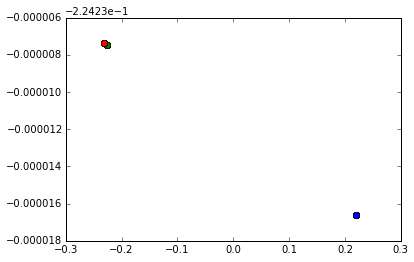

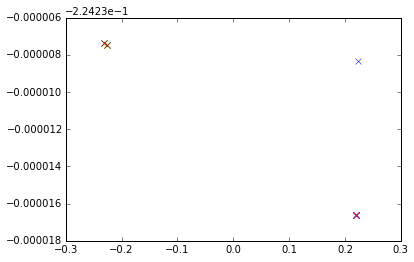

------------------------------------------5 6---------------


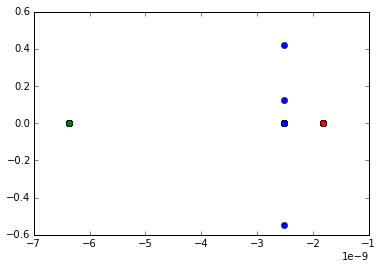

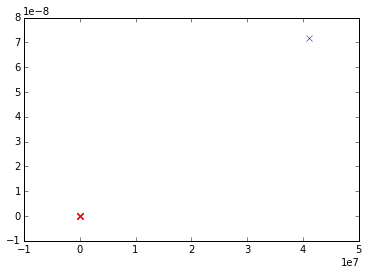

fold number: 8
178 40 3
------------------------------------------1 2---------------


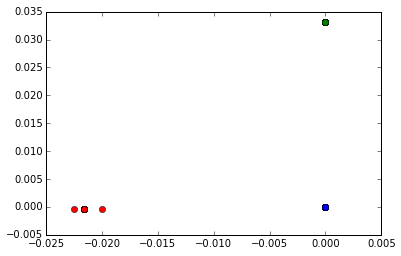

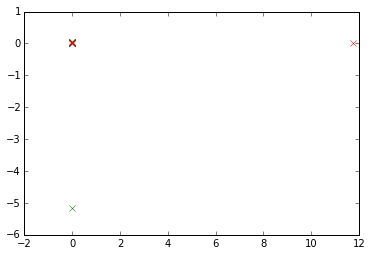

------------------------------------------3 4---------------


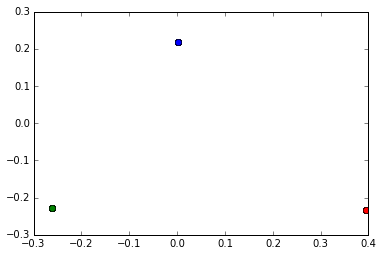

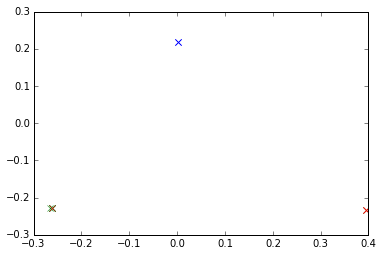

------------------------------------------5 6---------------


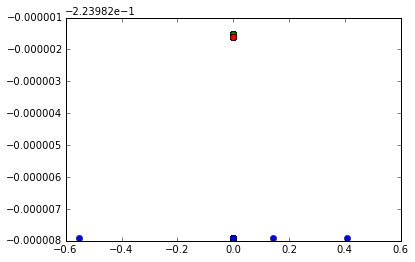

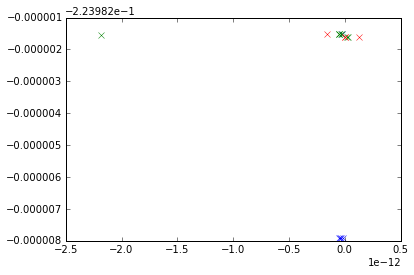

fold number: 9
178 40 3
------------------------------------------1 2---------------


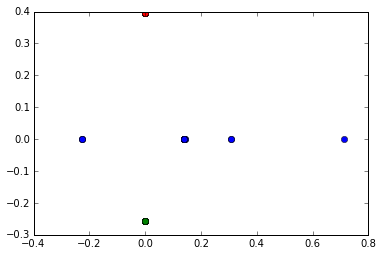

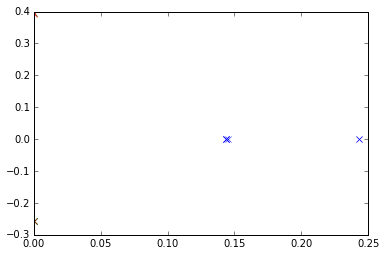

------------------------------------------3 4---------------


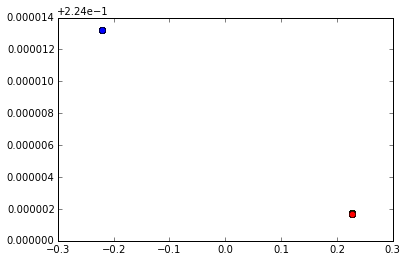

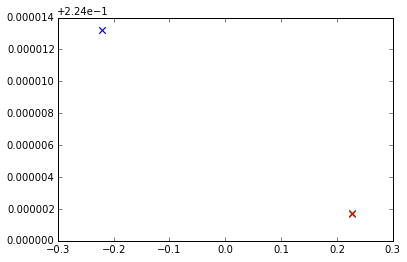

------------------------------------------5 6---------------


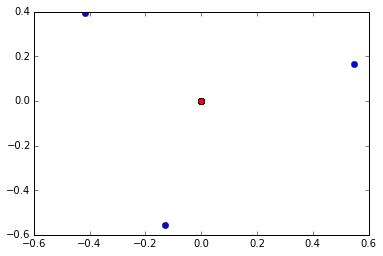

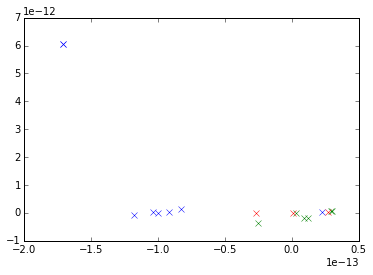

--------------------------------------- sigma:  0.2


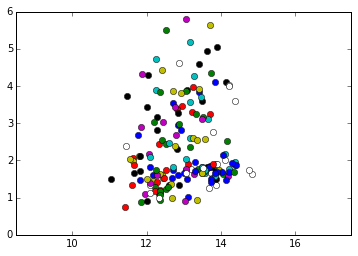

fold number: 0
178 40 3
------------------------------------------1 2---------------


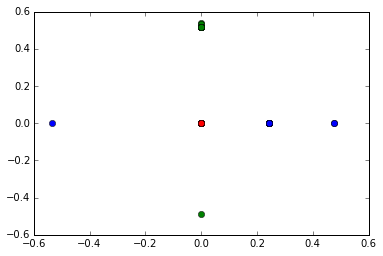

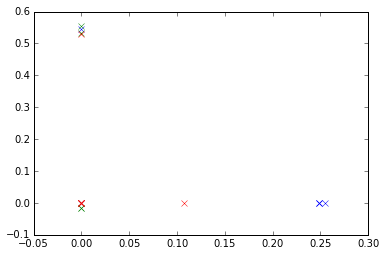

------------------------------------------3 4---------------


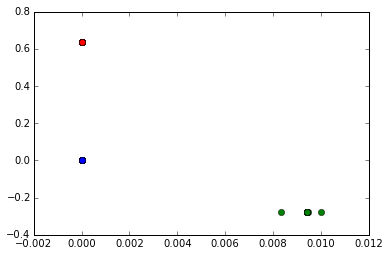

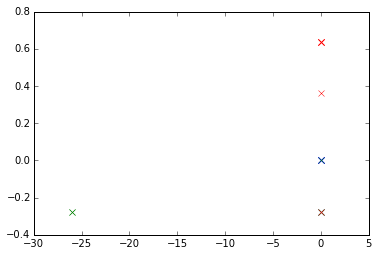

------------------------------------------5 6---------------


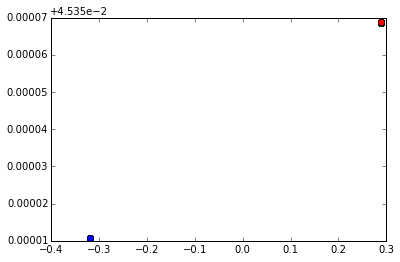

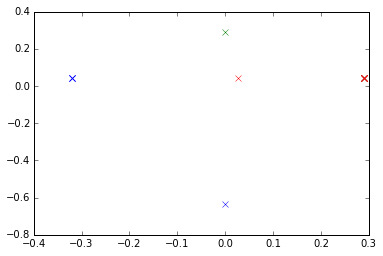

fold number: 1
178 40 3
------------------------------------------1 2---------------


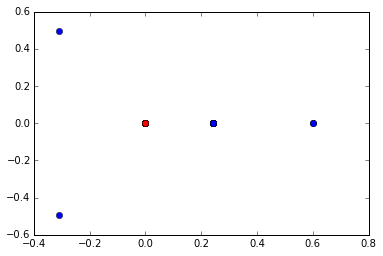

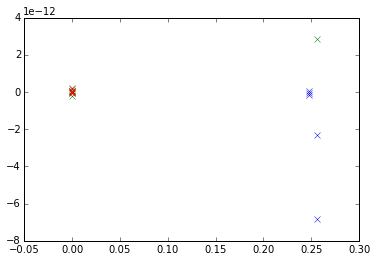

------------------------------------------3 4---------------


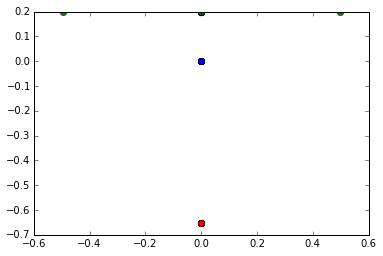

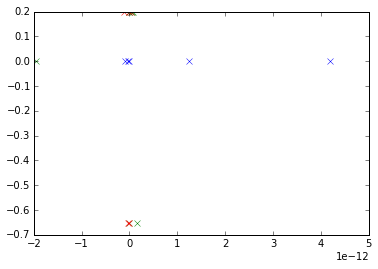

------------------------------------------5 6---------------


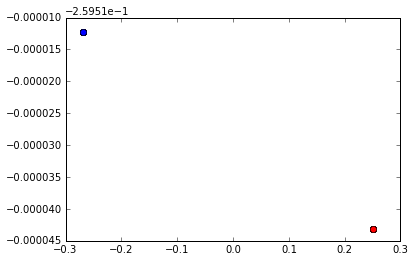

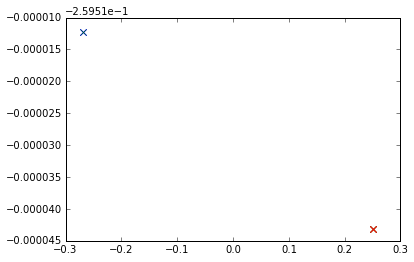

fold number: 2
178 40 3
------------------------------------------1 2---------------


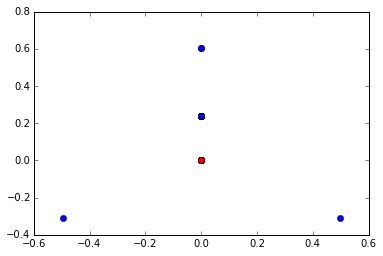

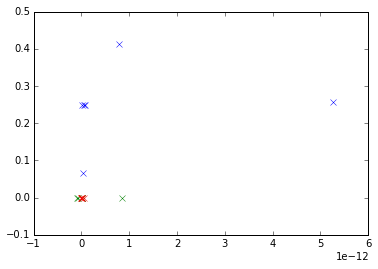

------------------------------------------3 4---------------


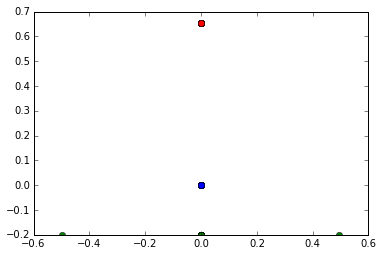

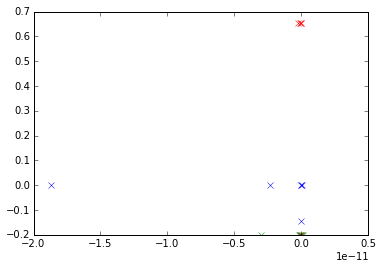

------------------------------------------5 6---------------


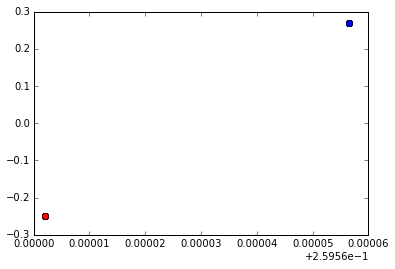

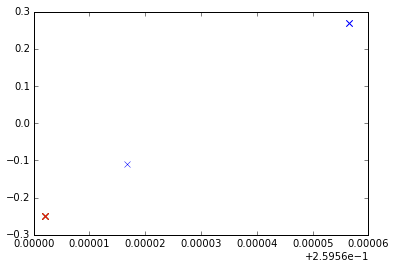

fold number: 3
178 40 3
------------------------------------------1 2---------------


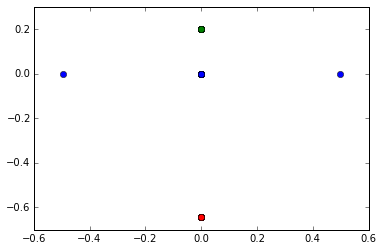

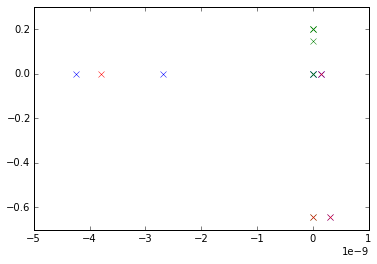

------------------------------------------3 4---------------


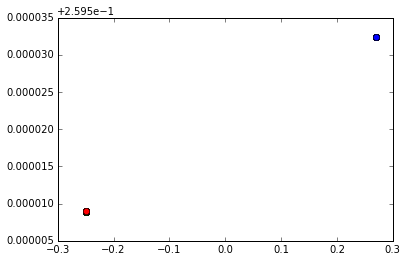

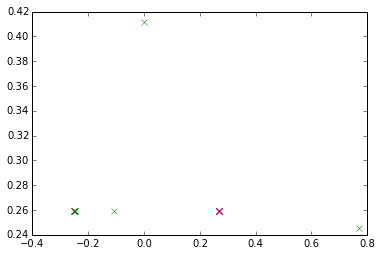

------------------------------------------5 6---------------


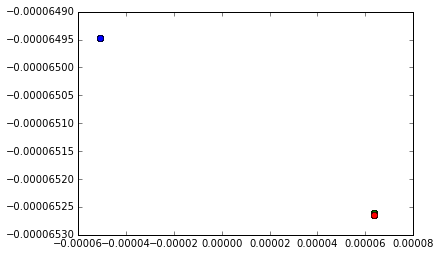

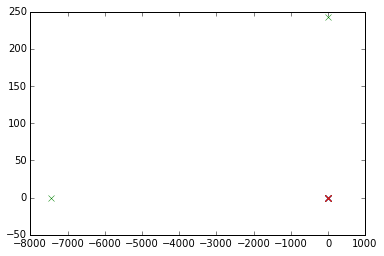

fold number: 4
178 40 3
------------------------------------------1 2---------------


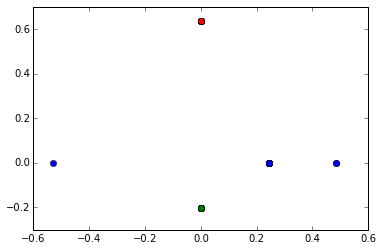

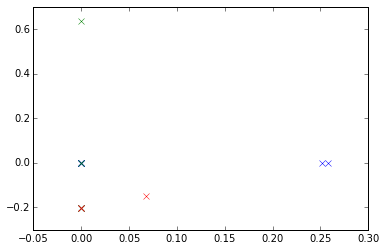

------------------------------------------3 4---------------


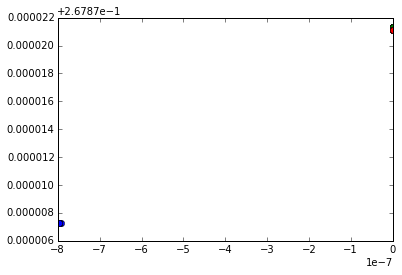

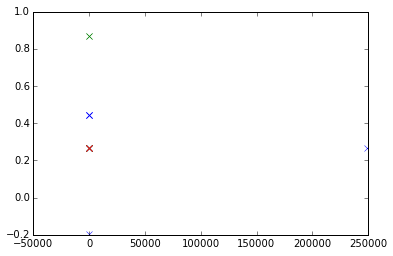

------------------------------------------5 6---------------


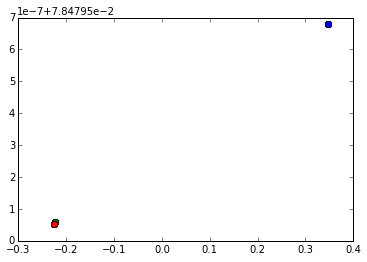

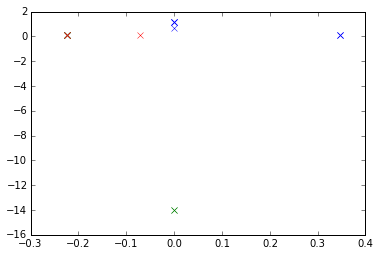

fold number: 5
178 40 3
------------------------------------------1 2---------------


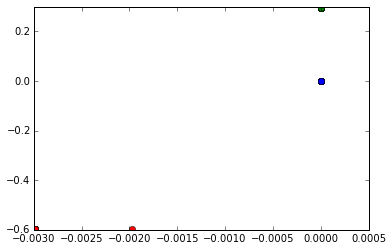

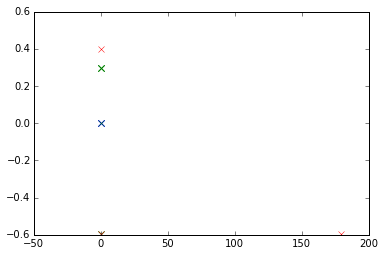

------------------------------------------3 4---------------


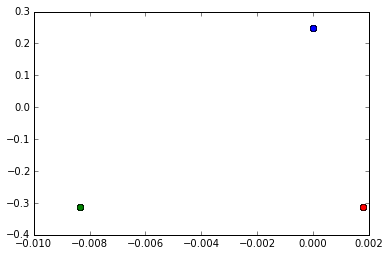

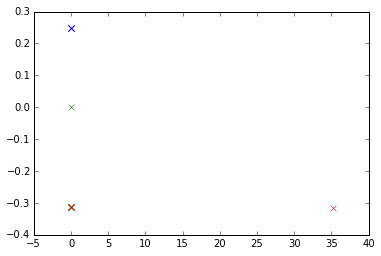

------------------------------------------5 6---------------


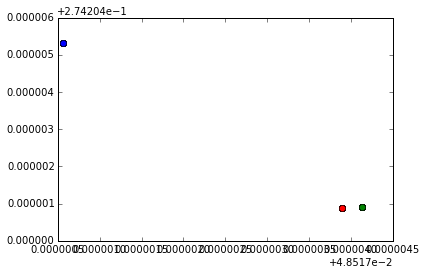

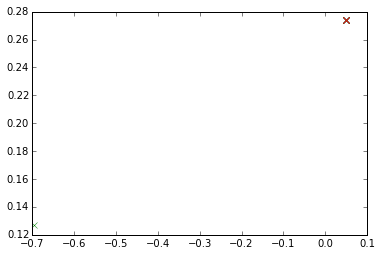

fold number: 6
178 40 3
------------------------------------------1 2---------------


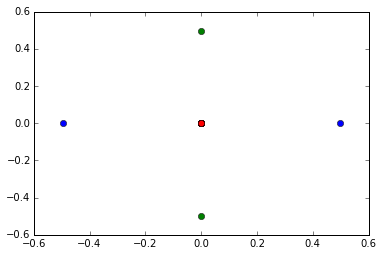

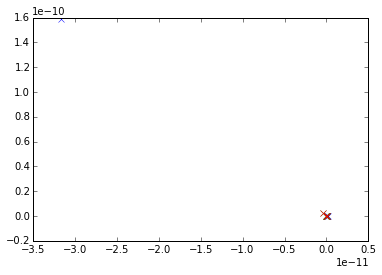

------------------------------------------3 4---------------


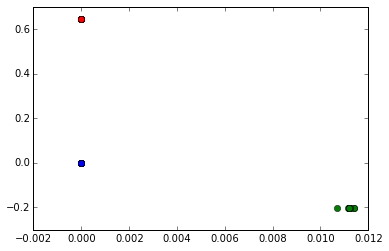

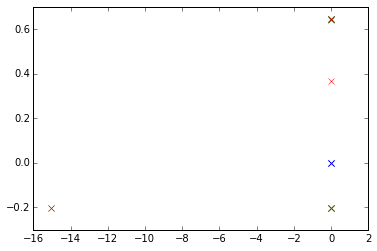

------------------------------------------5 6---------------


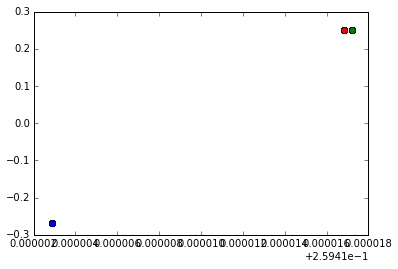

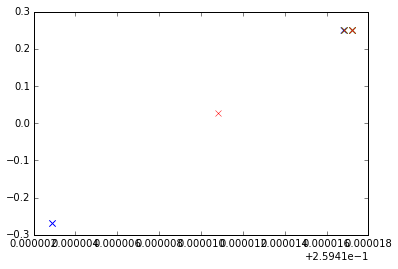

fold number: 7
178 40 3
------------------------------------------1 2---------------


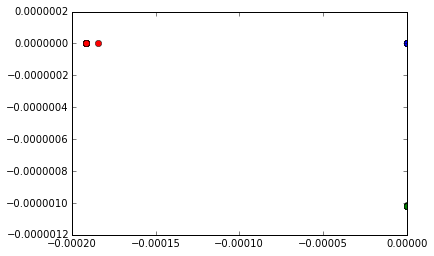

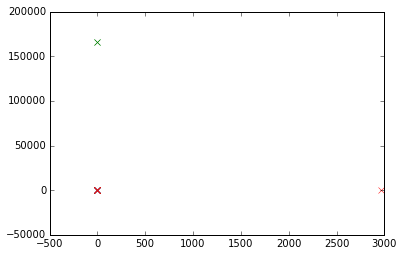

------------------------------------------3 4---------------


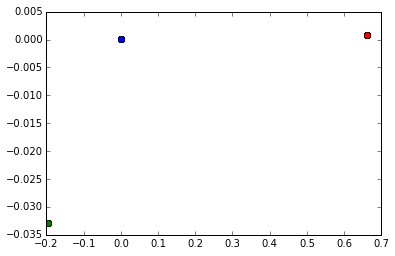

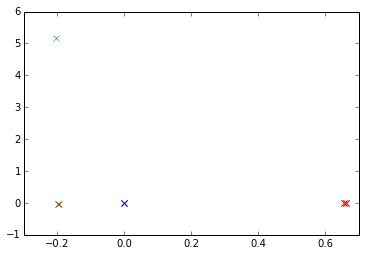

------------------------------------------5 6---------------


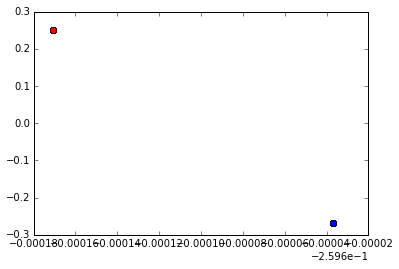

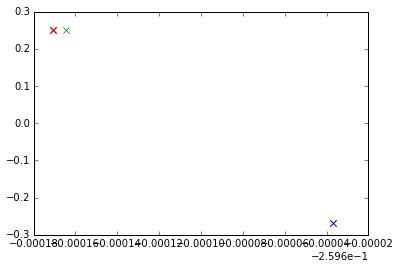

fold number: 8
178 40 3
------------------------------------------1 2---------------


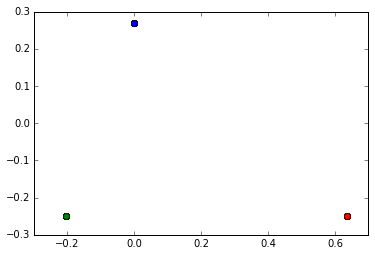

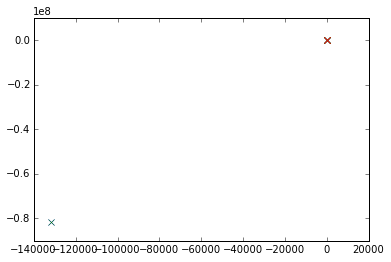

------------------------------------------3 4---------------


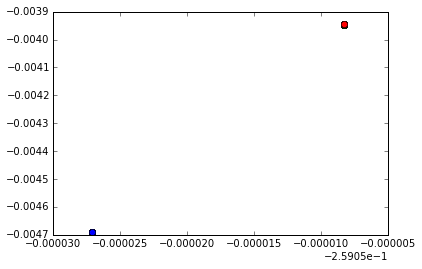

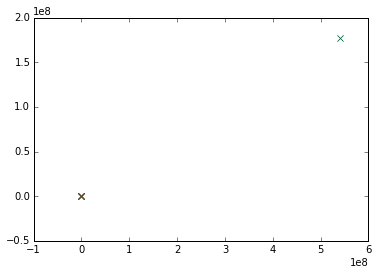

------------------------------------------5 6---------------


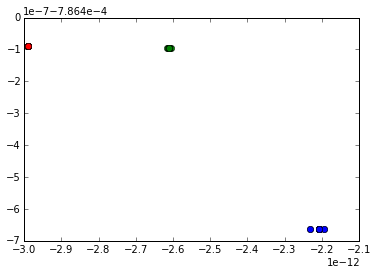

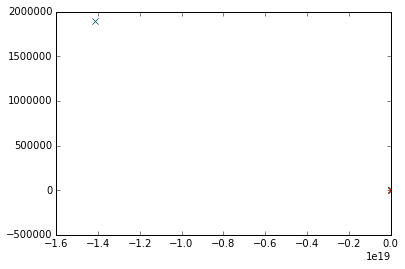

fold number: 9
178 40 3
------------------------------------------1 2---------------


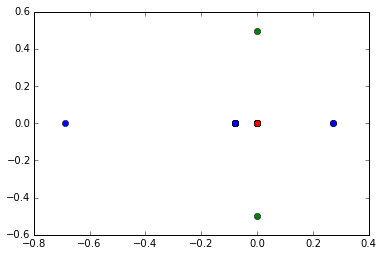

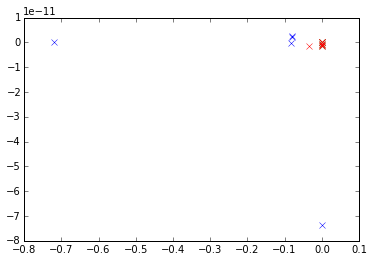

------------------------------------------3 4---------------


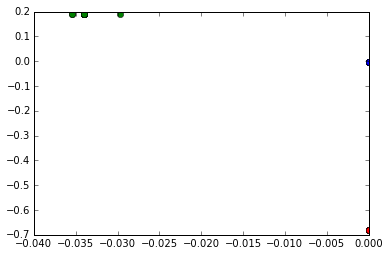

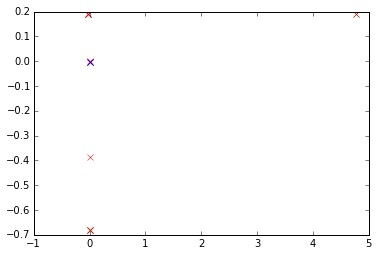

------------------------------------------5 6---------------


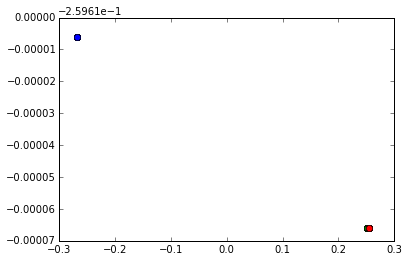

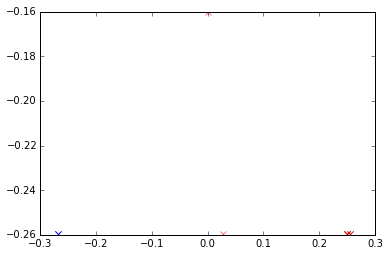

--------------------------------------- sigma:  0.3


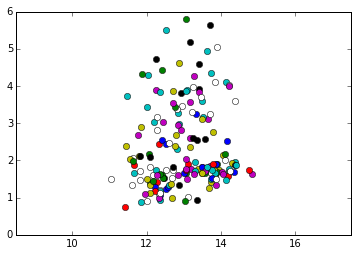

fold number: 0
178 40 3
------------------------------------------1 2---------------


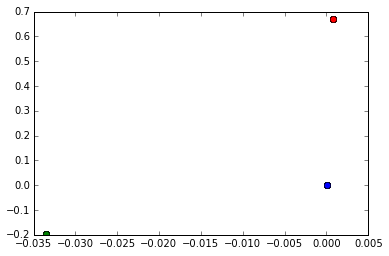

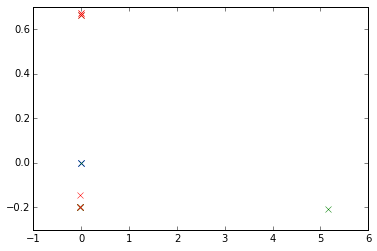

------------------------------------------3 4---------------


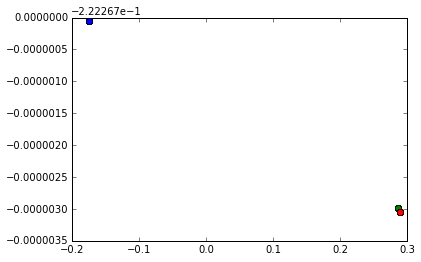

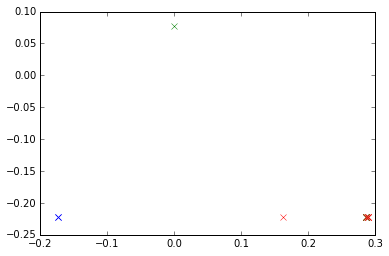

------------------------------------------5 6---------------


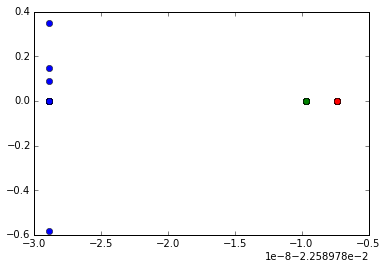

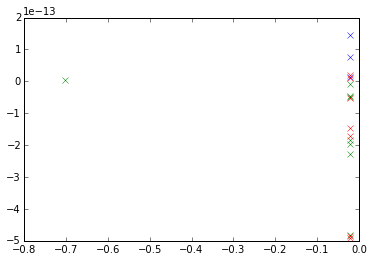

fold number: 1
178 40 3
------------------------------------------1 2---------------


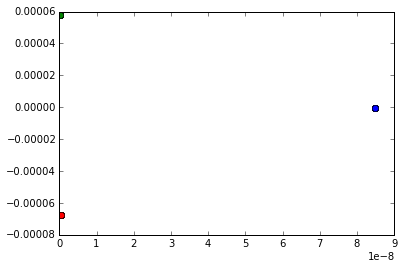

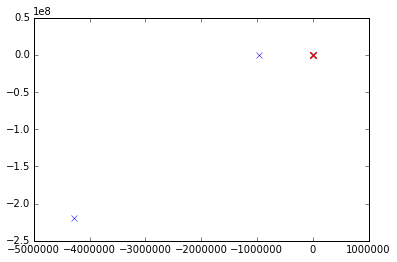

------------------------------------------3 4---------------


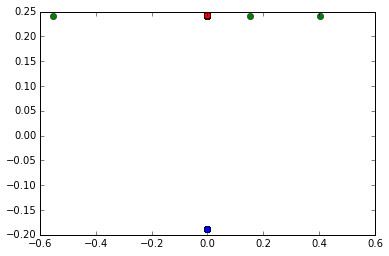

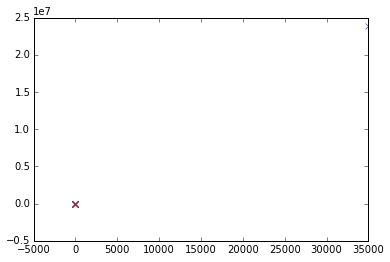

------------------------------------------5 6---------------


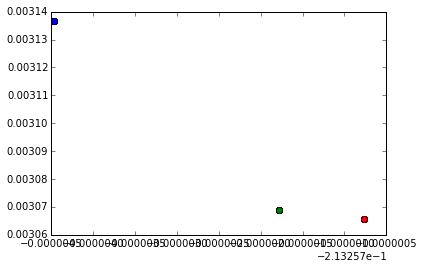

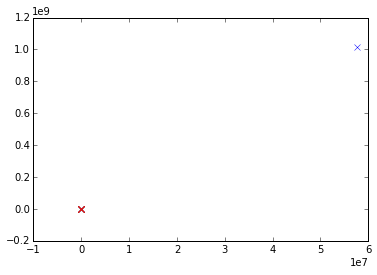

fold number: 2
178 40 3
------------------------------------------1 2---------------


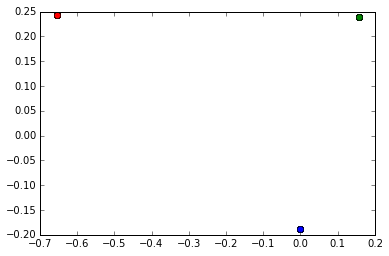

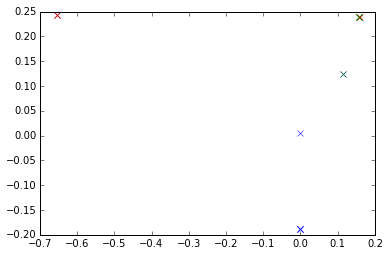

------------------------------------------3 4---------------


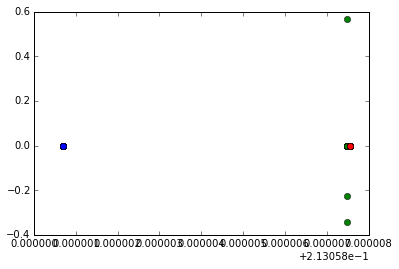

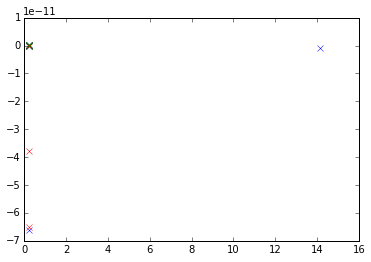

------------------------------------------5 6---------------


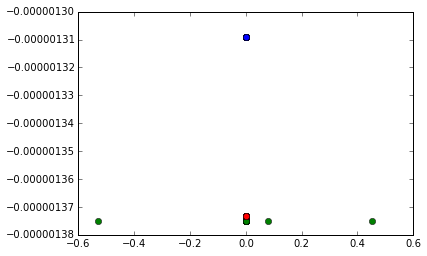

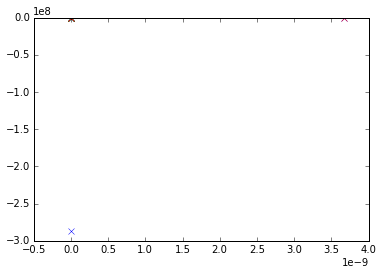

fold number: 3
178 40 3
------------------------------------------1 2---------------


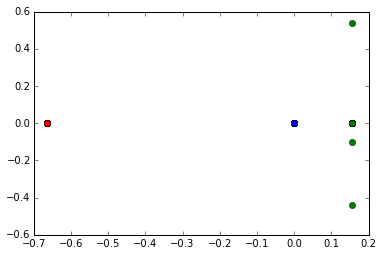

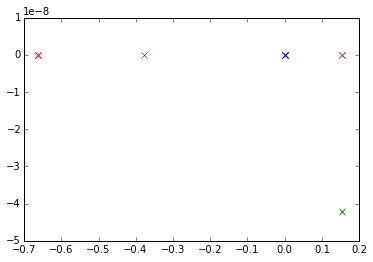

------------------------------------------3 4---------------


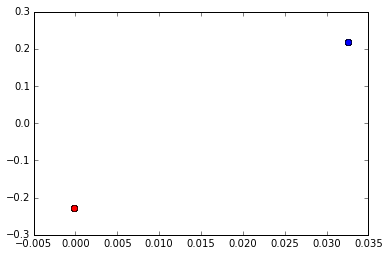

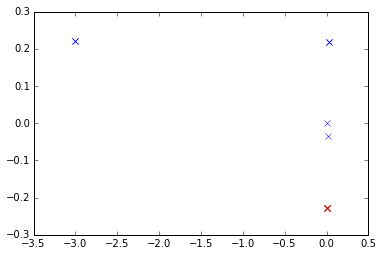

------------------------------------------5 6---------------


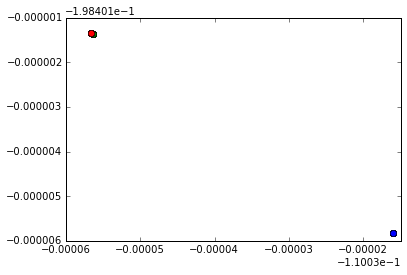

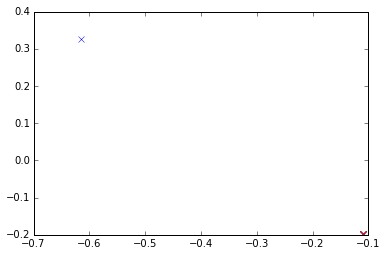

fold number: 4
178 40 3
------------------------------------------1 2---------------


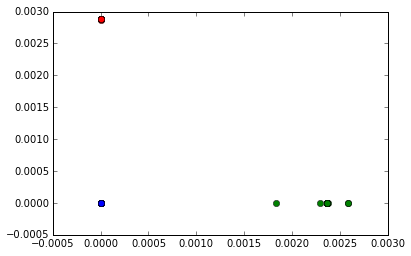

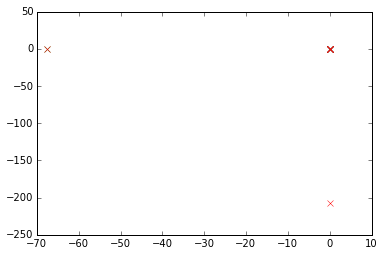

------------------------------------------3 4---------------


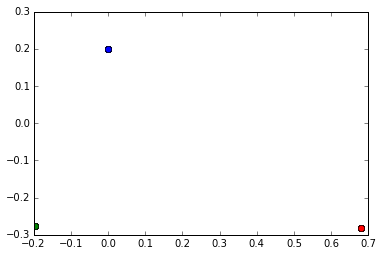

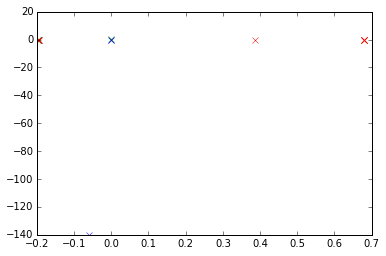

------------------------------------------5 6---------------


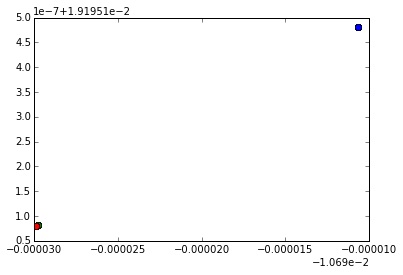

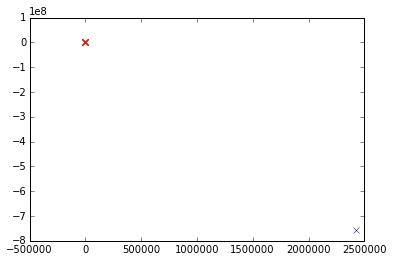

fold number: 5
178 40 3
------------------------------------------1 2---------------


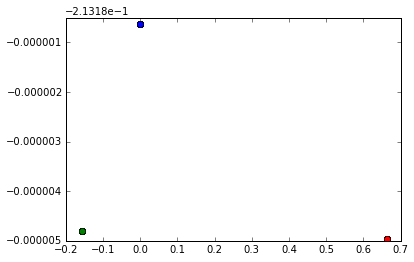

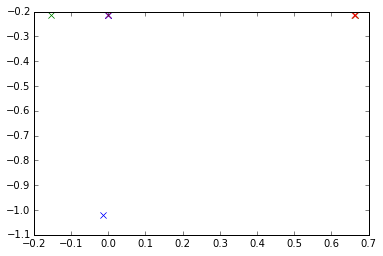

------------------------------------------3 4---------------


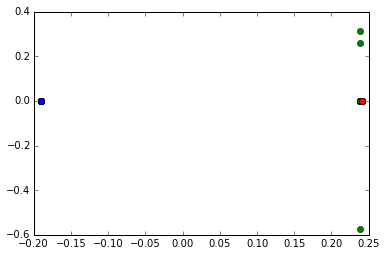

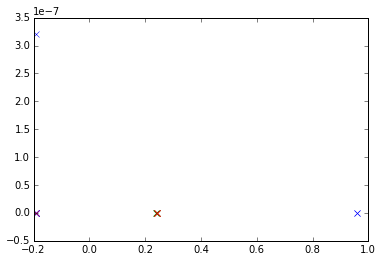

------------------------------------------5 6---------------


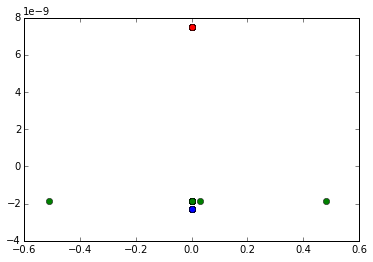

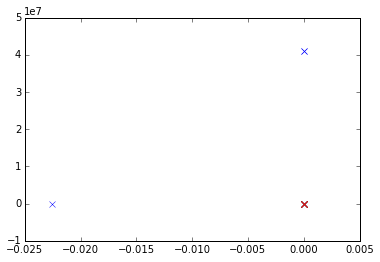

fold number: 6
178 40 3
------------------------------------------1 2---------------


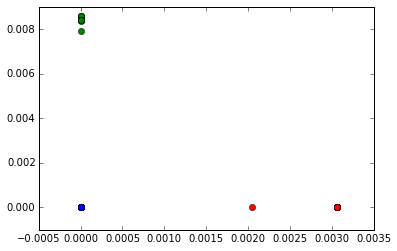

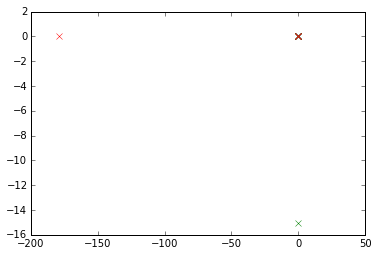

------------------------------------------3 4---------------


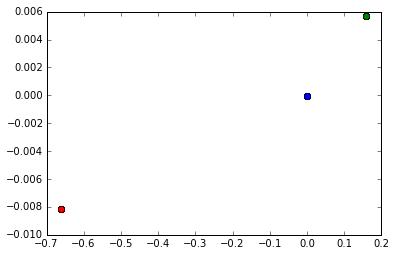

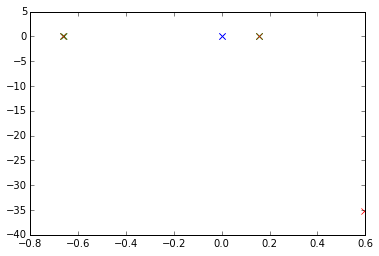

------------------------------------------5 6---------------


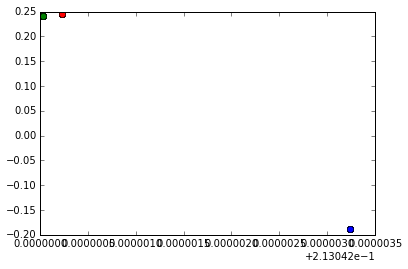

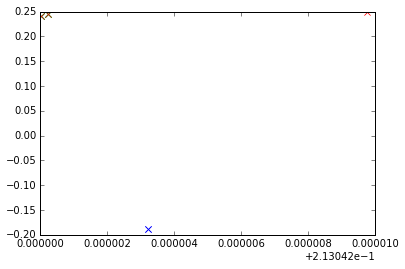

fold number: 7
178 40 3
------------------------------------------1 2---------------


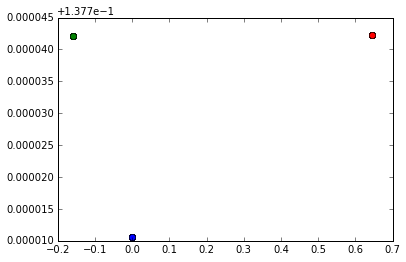

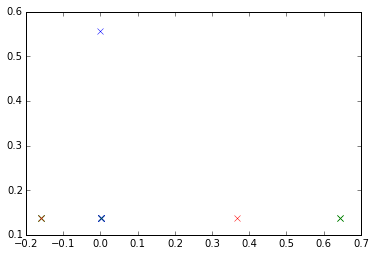

------------------------------------------3 4---------------


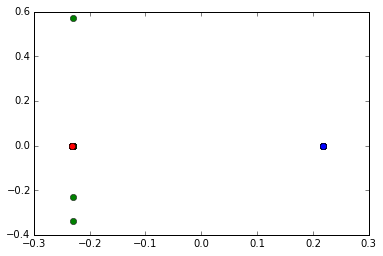

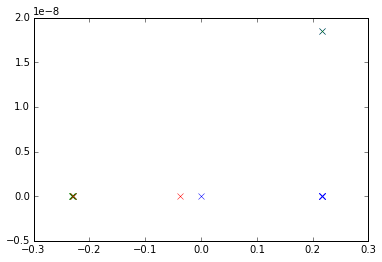

------------------------------------------5 6---------------


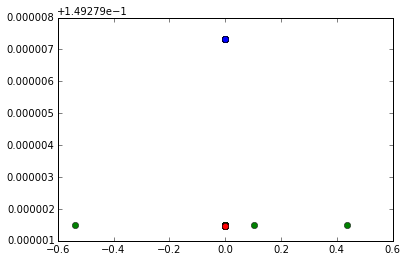

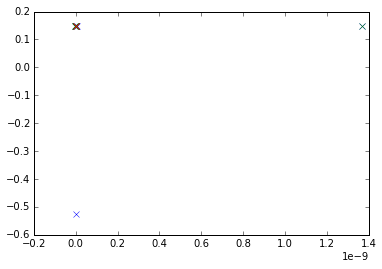

fold number: 8
178 40 3
------------------------------------------1 2---------------


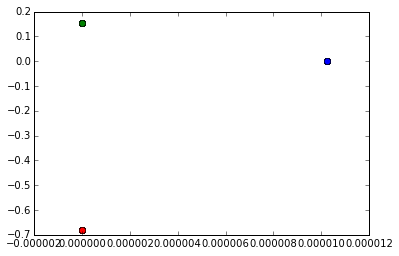

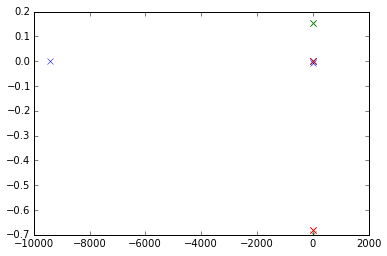

------------------------------------------3 4---------------


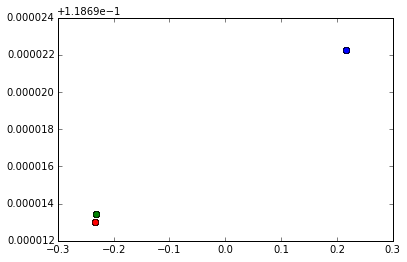

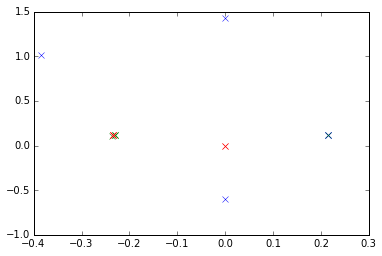

------------------------------------------5 6---------------


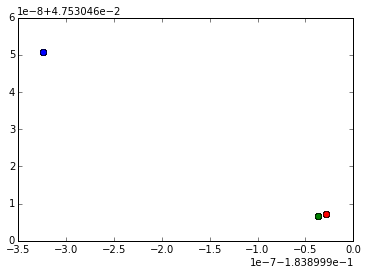

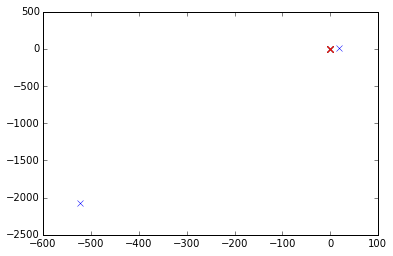

fold number: 9
178 40 3
------------------------------------------1 2---------------


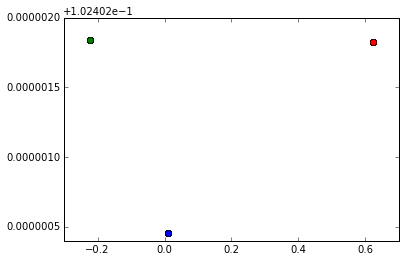

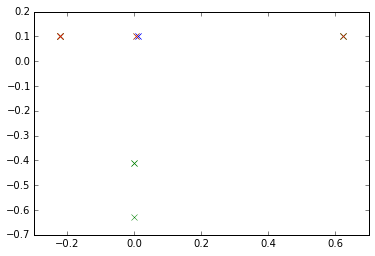

------------------------------------------3 4---------------


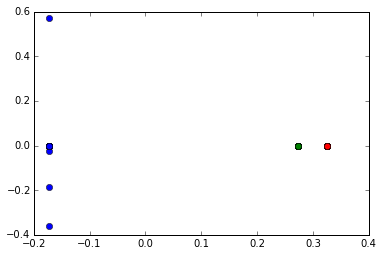

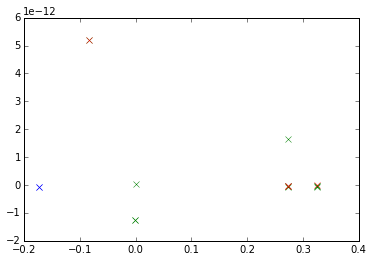

------------------------------------------5 6---------------


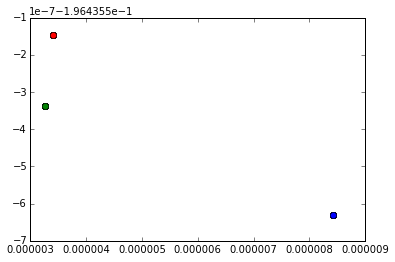

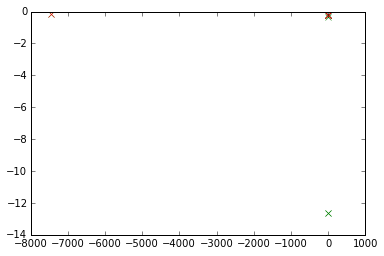

--------------------------------------- sigma:  0.4


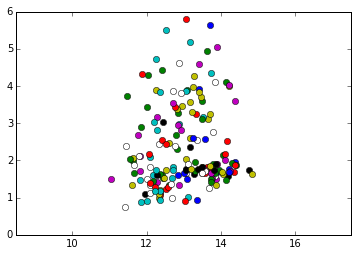

fold number: 0
178 40 3
------------------------------------------1 2---------------


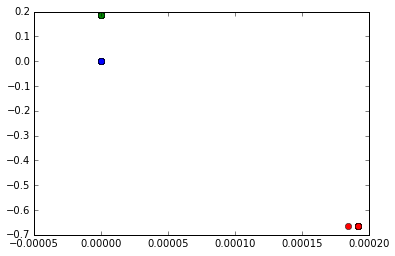

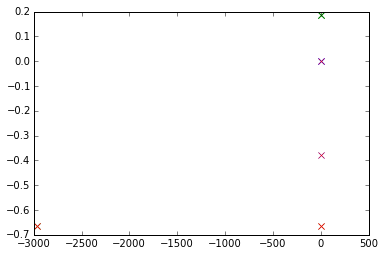

------------------------------------------3 4---------------


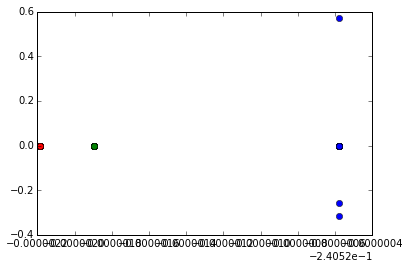

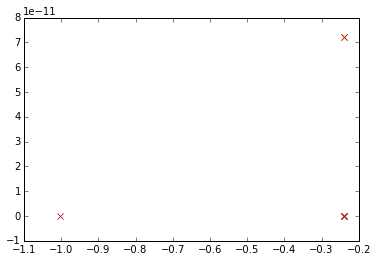

------------------------------------------5 6---------------


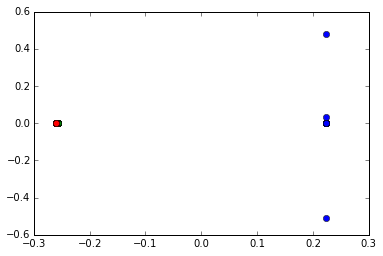

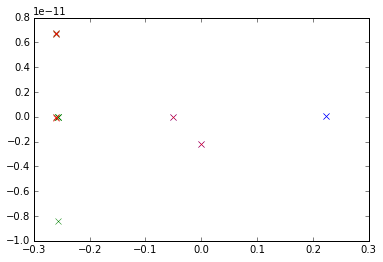

fold number: 1
178 40 3
------------------------------------------1 2---------------


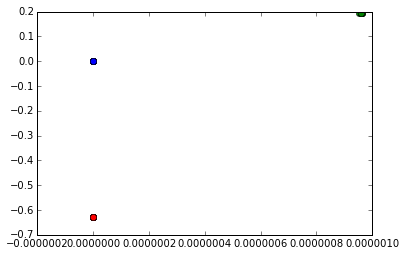

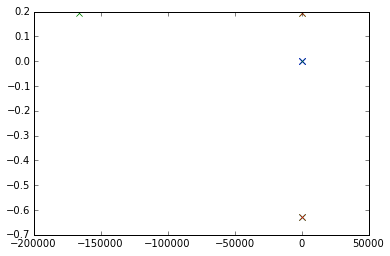

------------------------------------------3 4---------------


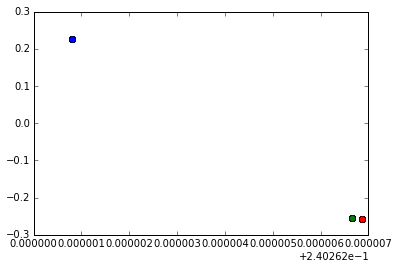

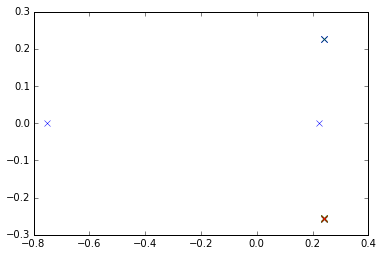

------------------------------------------5 6---------------


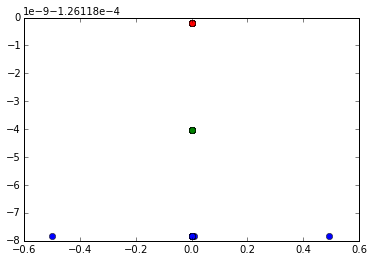

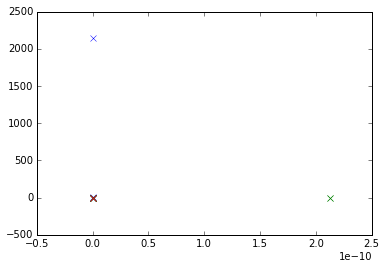

fold number: 2
178 40 3
------------------------------------------1 2---------------


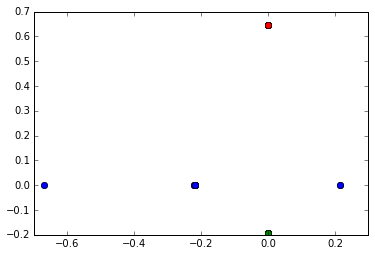

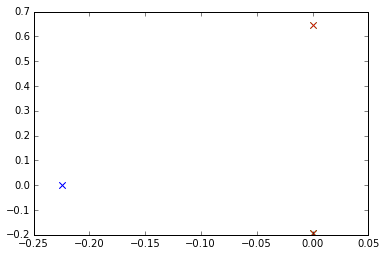

------------------------------------------3 4---------------


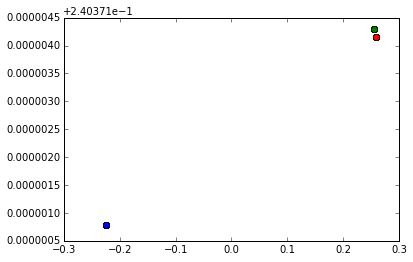

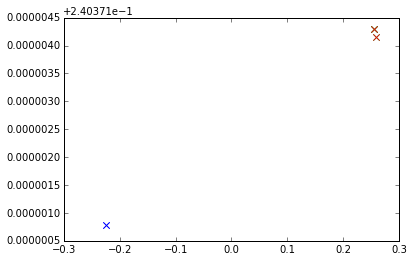

------------------------------------------5 6---------------


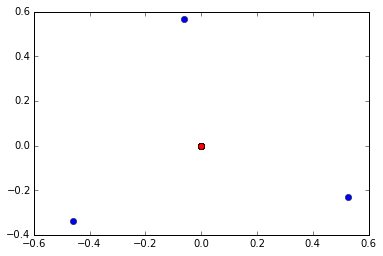

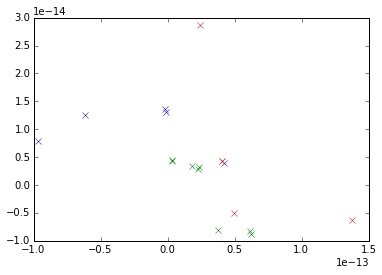

fold number: 3
178 40 3
------------------------------------------1 2---------------


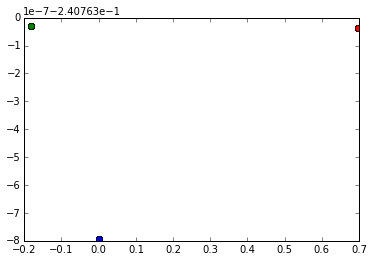

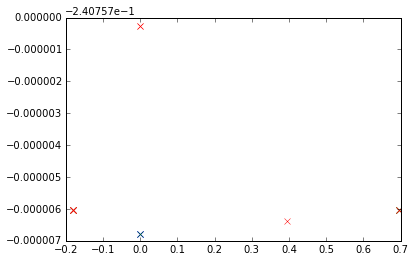

------------------------------------------3 4---------------


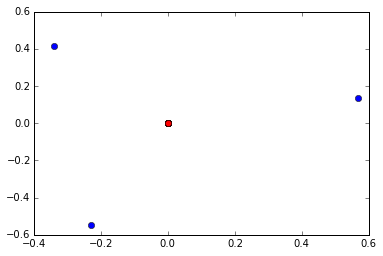

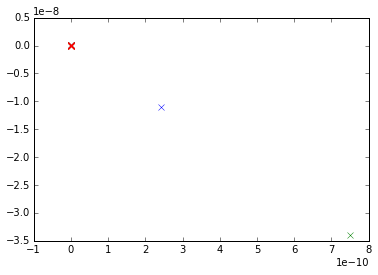

------------------------------------------5 6---------------


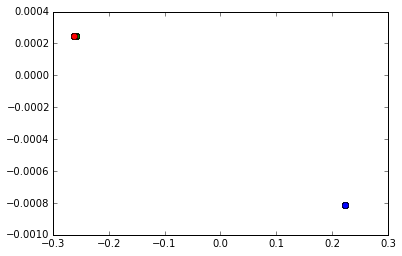

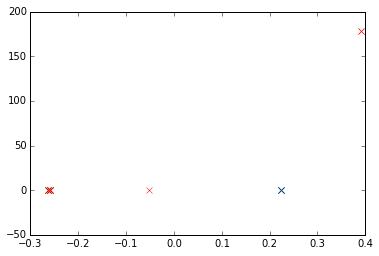

fold number: 4
178 40 3
------------------------------------------1 2---------------


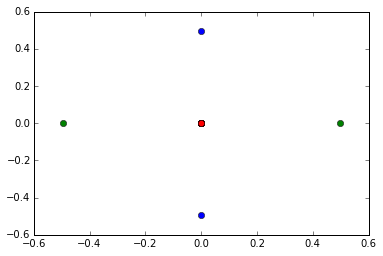

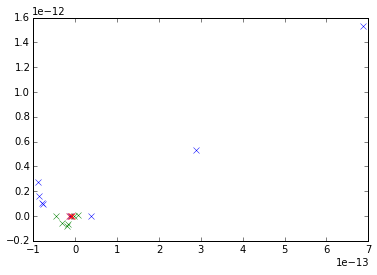

------------------------------------------3 4---------------


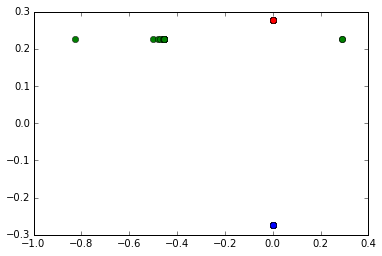

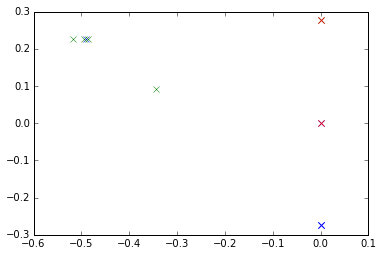

------------------------------------------5 6---------------


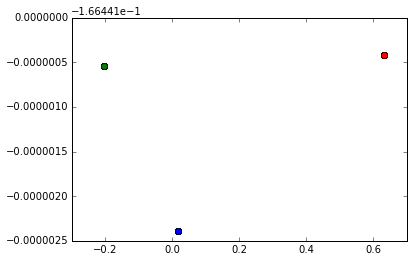

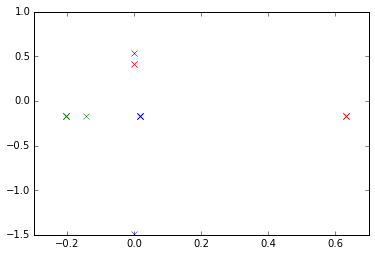

fold number: 5
178 40 3
------------------------------------------1 2---------------


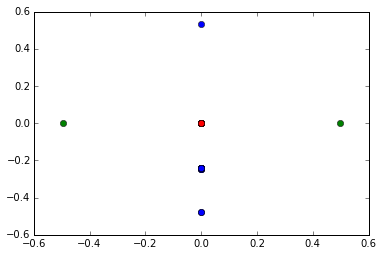

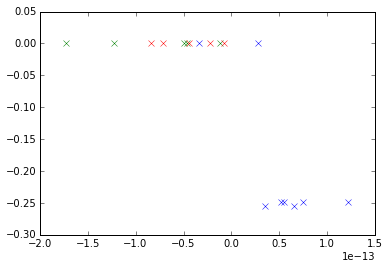

------------------------------------------3 4---------------


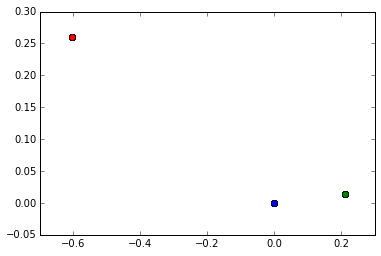

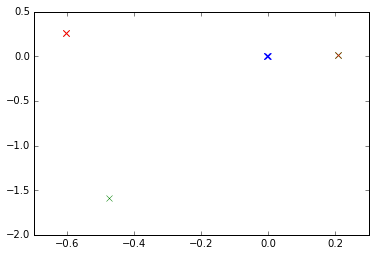

------------------------------------------5 6---------------


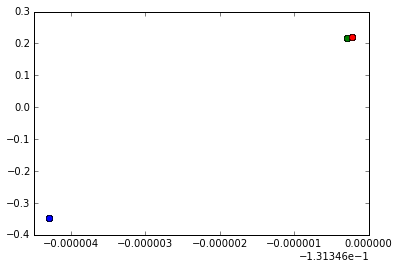

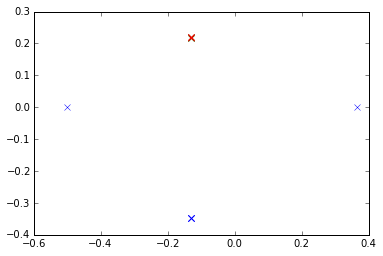

fold number: 6
178 40 3
------------------------------------------1 2---------------


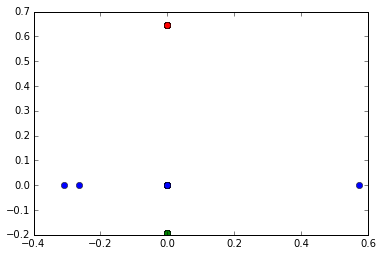

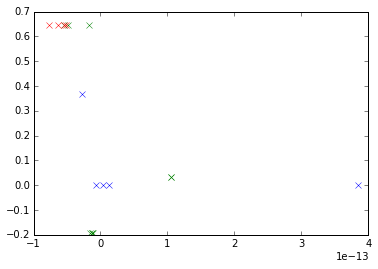

------------------------------------------3 4---------------


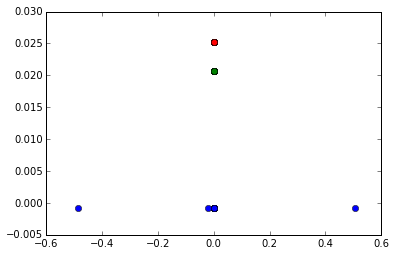

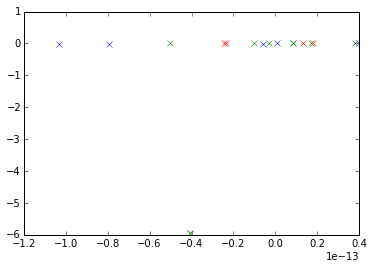

------------------------------------------5 6---------------


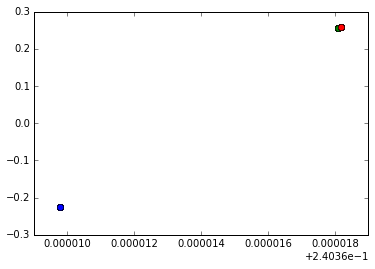

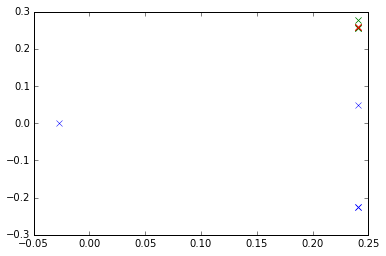

fold number: 7
178 40 3
------------------------------------------1 2---------------


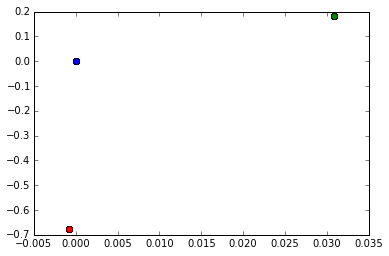

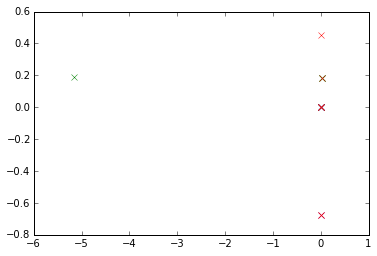

------------------------------------------3 4---------------


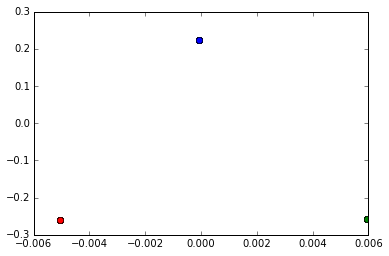

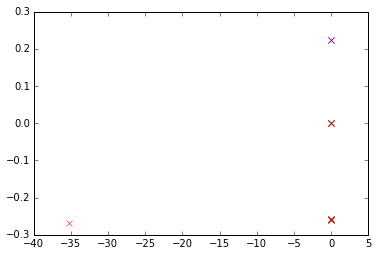

------------------------------------------5 6---------------


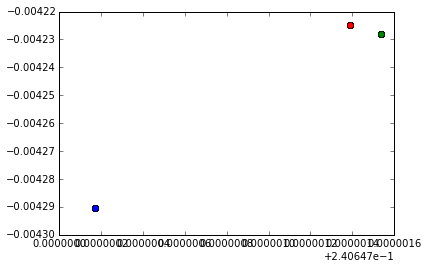

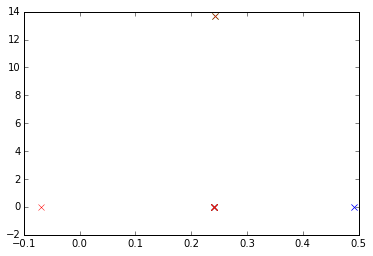

fold number: 8
178 40 3
------------------------------------------1 2---------------


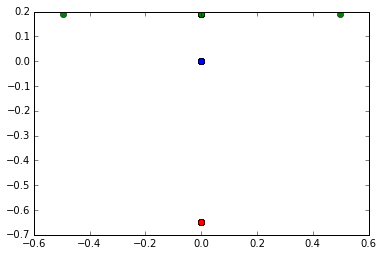

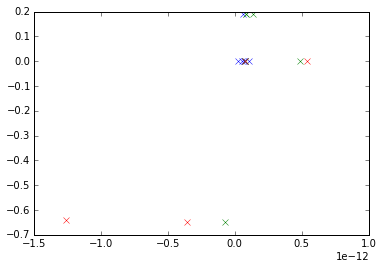

------------------------------------------3 4---------------


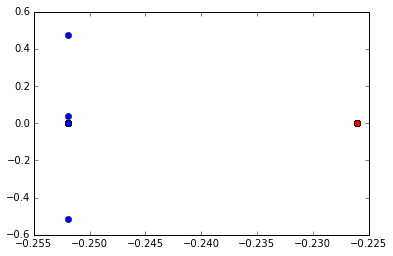

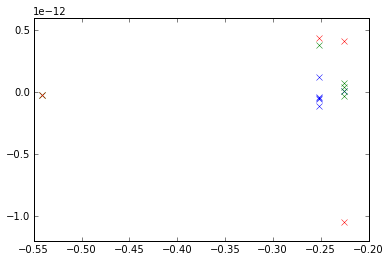

------------------------------------------5 6---------------


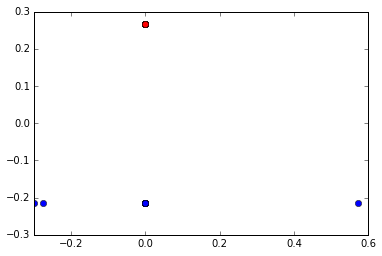

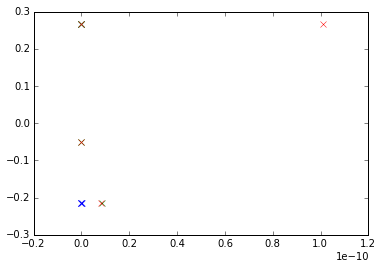

fold number: 9
178 40 3
------------------------------------------1 2---------------


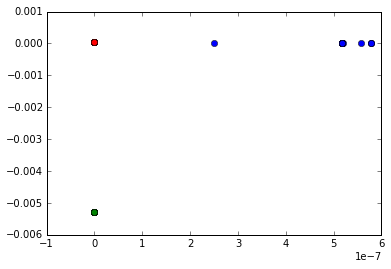

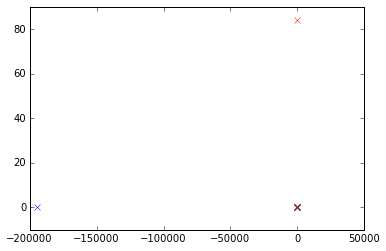

------------------------------------------3 4---------------


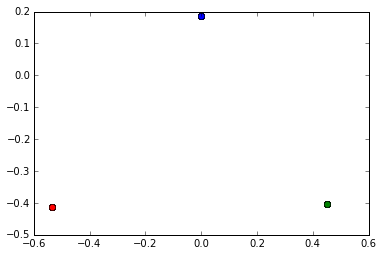

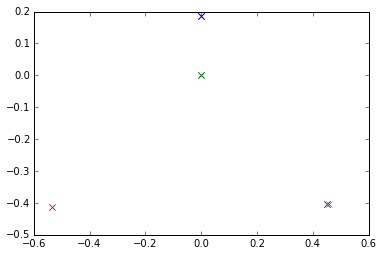

------------------------------------------5 6---------------


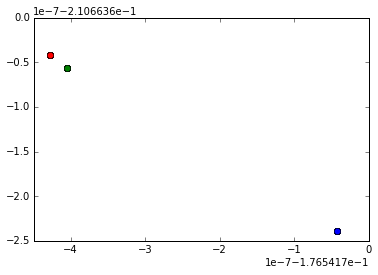

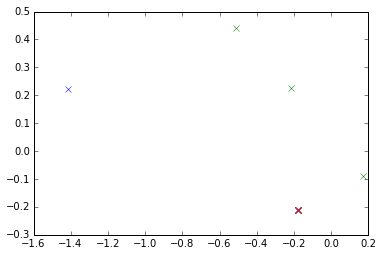

--------------------------------------- sigma:  0.5


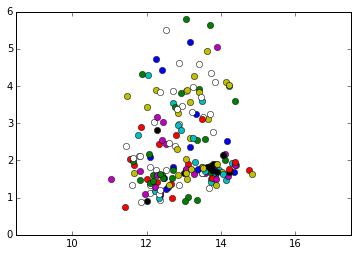

fold number: 0
178 40 3
------------------------------------------1 2---------------


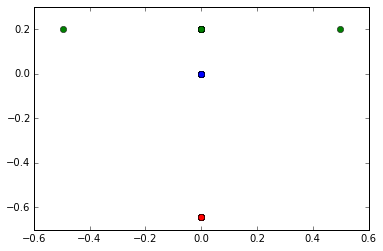

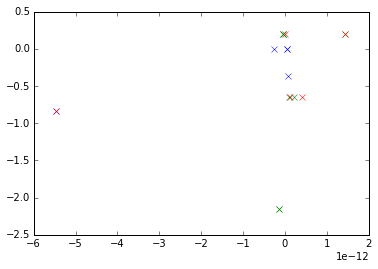

------------------------------------------3 4---------------


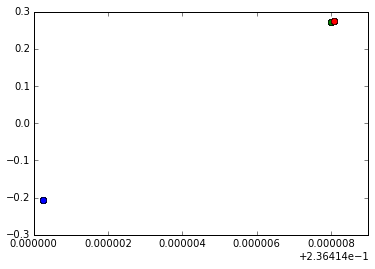

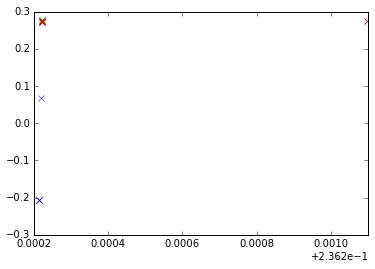

------------------------------------------5 6---------------


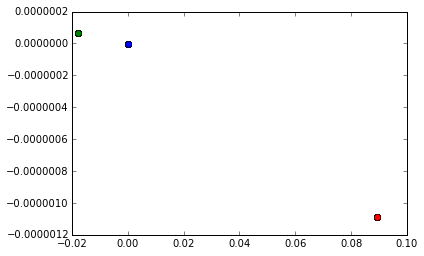

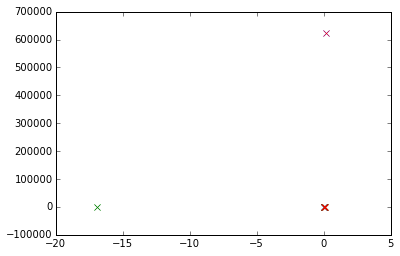

fold number: 1
178 40 3
------------------------------------------1 2---------------


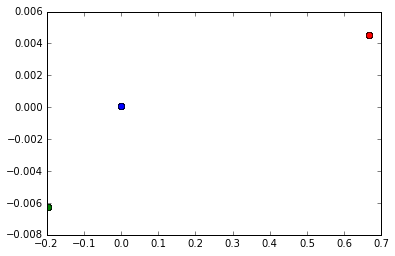

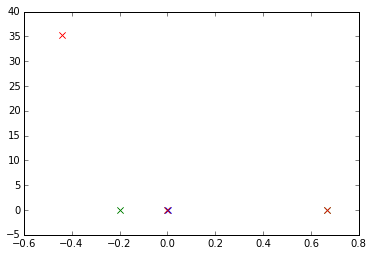

------------------------------------------3 4---------------


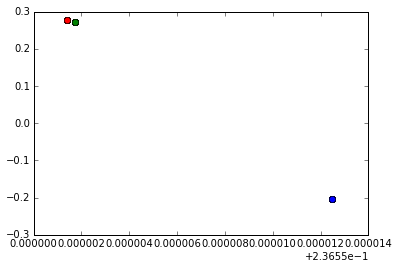

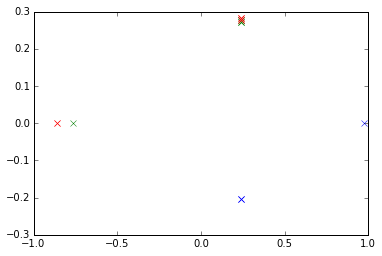

------------------------------------------5 6---------------


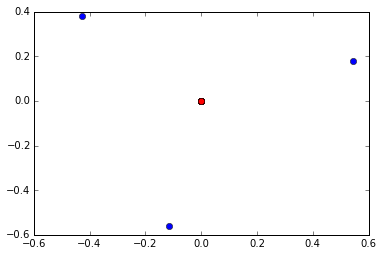

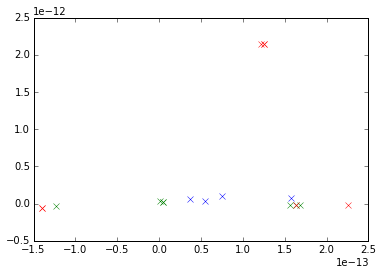

fold number: 2
178 40 3
------------------------------------------1 2---------------


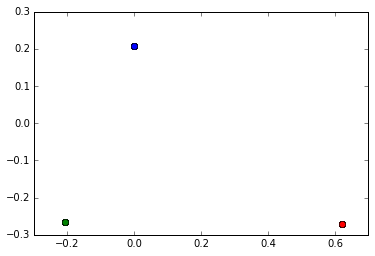

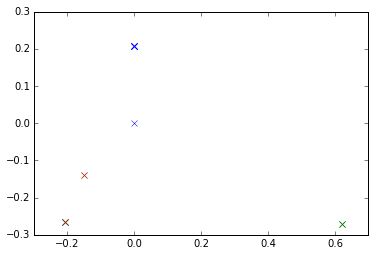

------------------------------------------3 4---------------


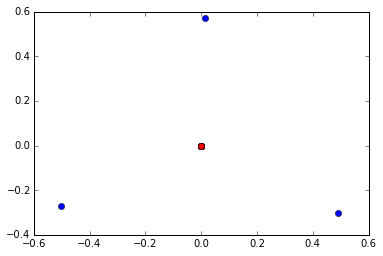

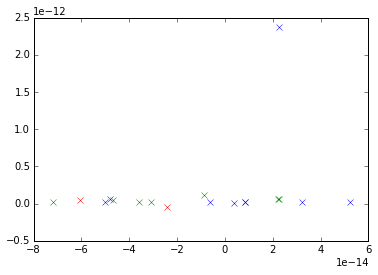

------------------------------------------5 6---------------


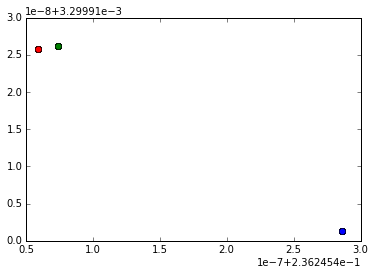

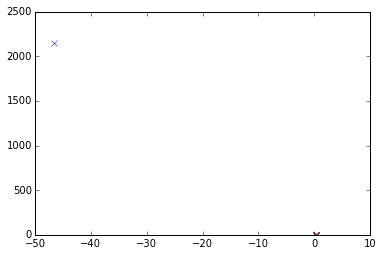

fold number: 3
178 40 3
------------------------------------------1 2---------------


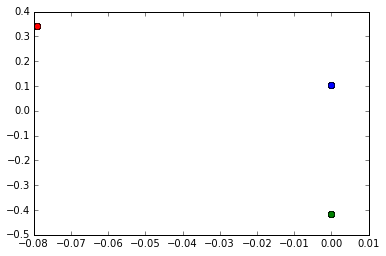

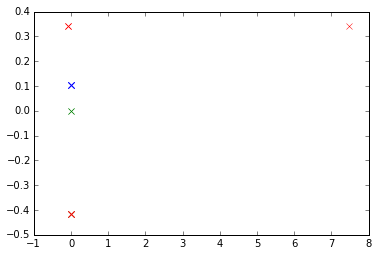

------------------------------------------3 4---------------


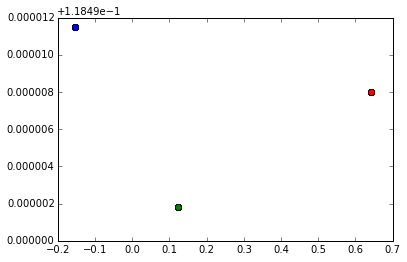

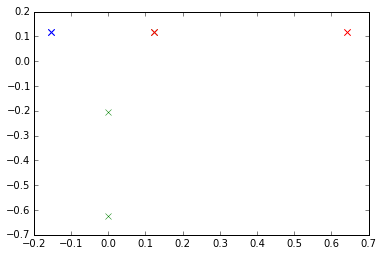

------------------------------------------5 6---------------


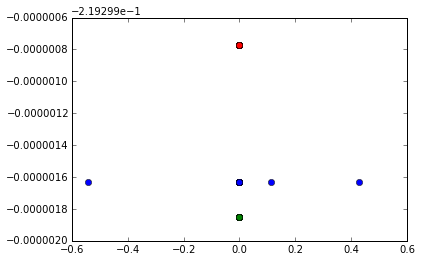

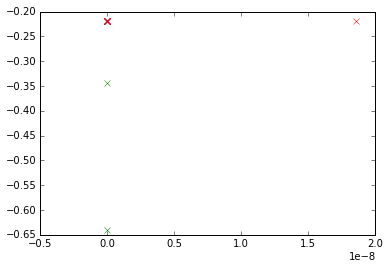

fold number: 4
178 40 3
------------------------------------------1 2---------------


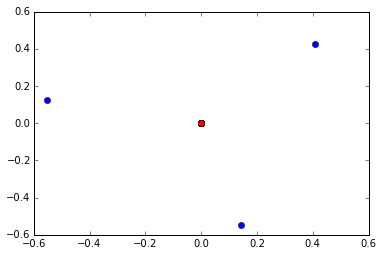

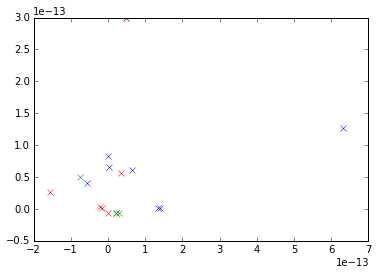

------------------------------------------3 4---------------


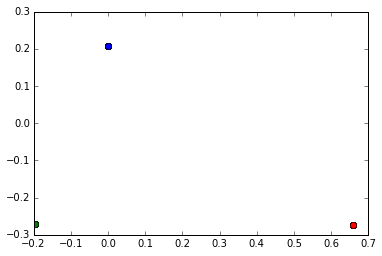

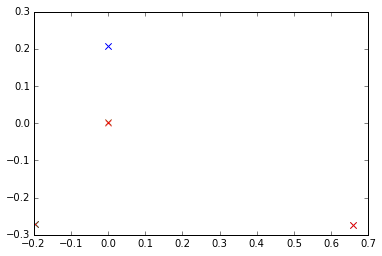

------------------------------------------5 6---------------


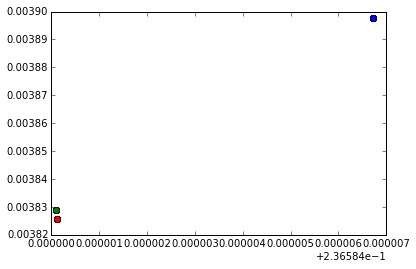

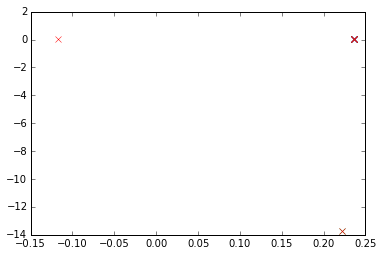

fold number: 5
178 40 3
------------------------------------------1 2---------------


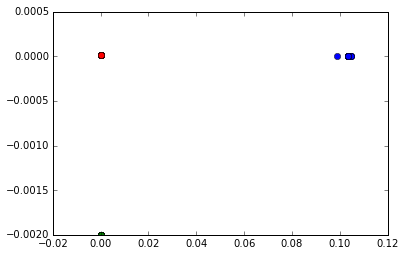

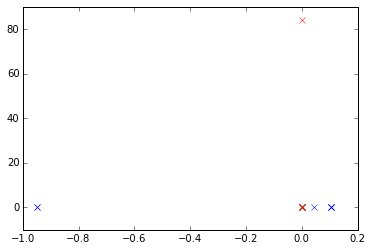

------------------------------------------3 4---------------


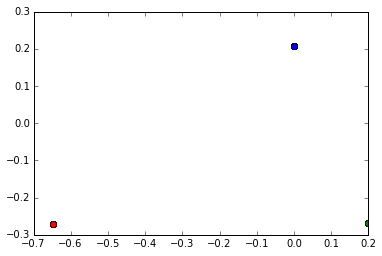

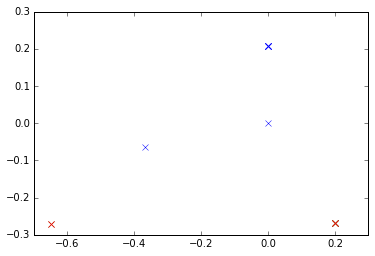

------------------------------------------5 6---------------


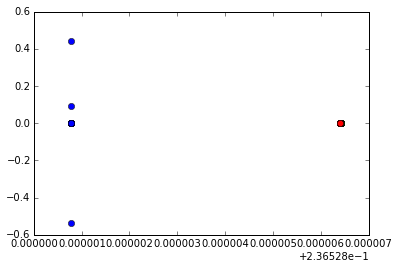

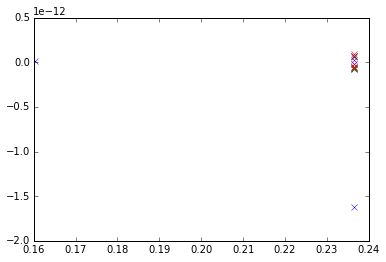

fold number: 6
178 40 3
------------------------------------------1 2---------------


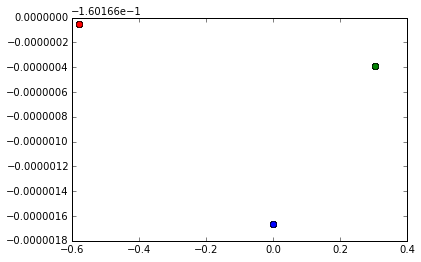

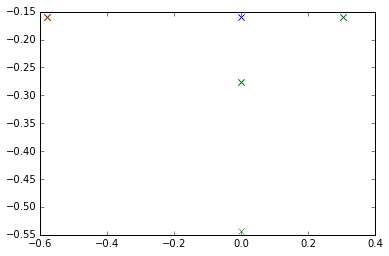

------------------------------------------3 4---------------


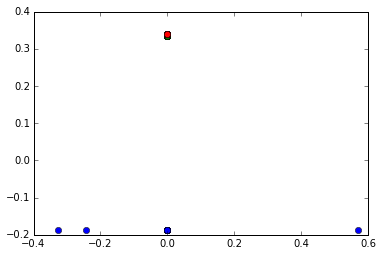

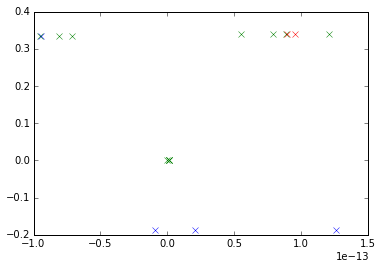

------------------------------------------5 6---------------


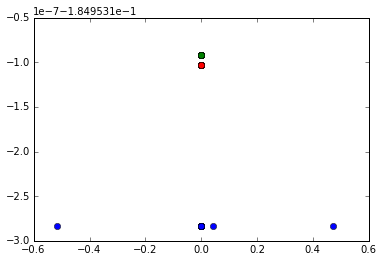

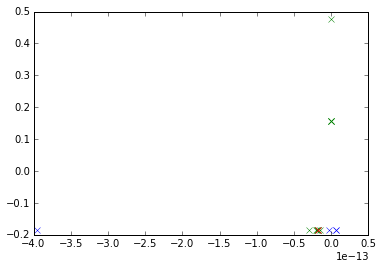

fold number: 7
178 40 3
------------------------------------------1 2---------------


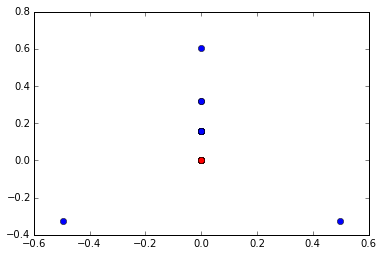

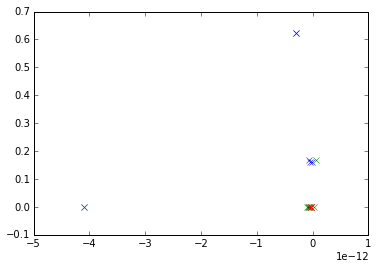

------------------------------------------3 4---------------


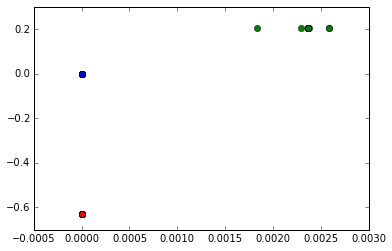

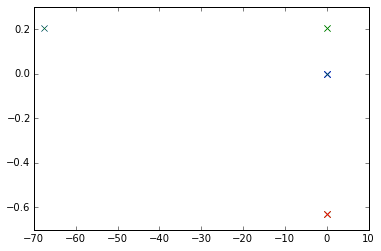

------------------------------------------5 6---------------


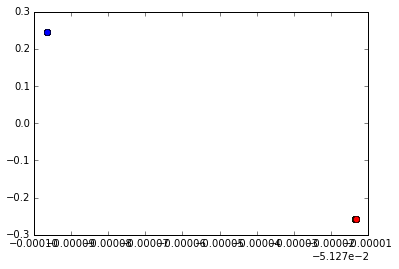

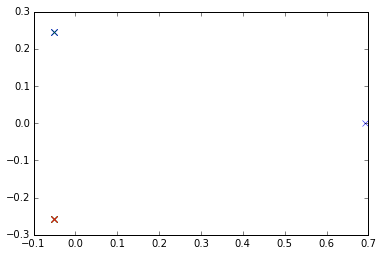

fold number: 8
178 40 3
------------------------------------------1 2---------------


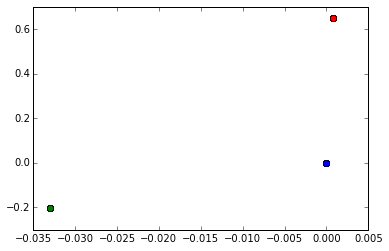

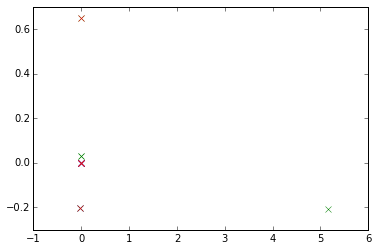

------------------------------------------3 4---------------


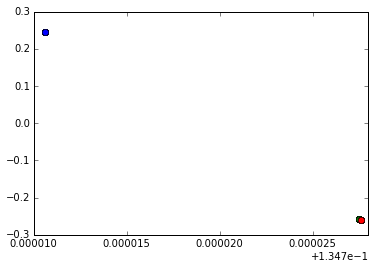

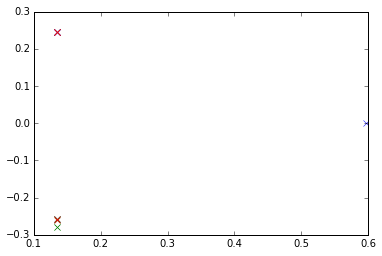

------------------------------------------5 6---------------


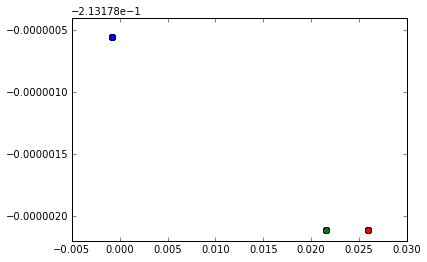

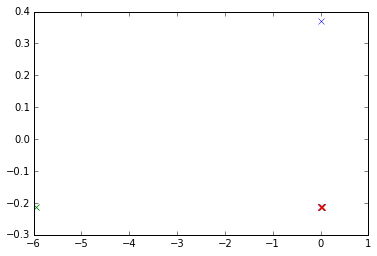

fold number: 9
178 40 3
------------------------------------------1 2---------------


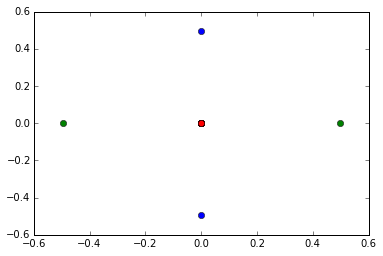

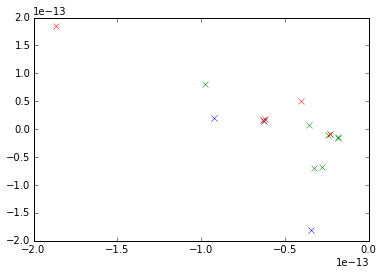

------------------------------------------3 4---------------


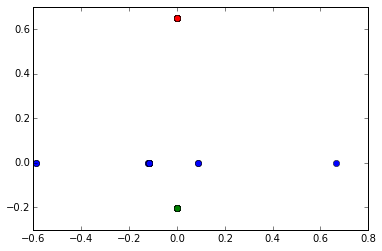

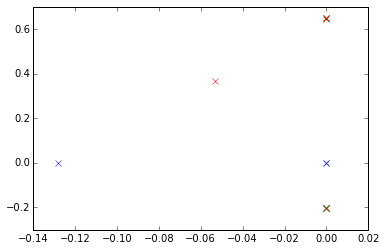

------------------------------------------5 6---------------


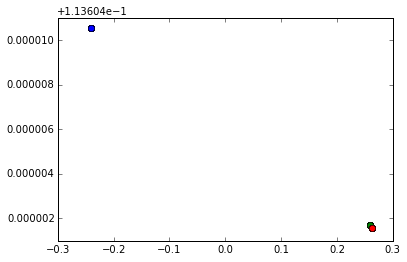

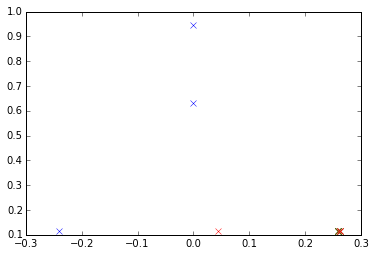

--------------------------------------- sigma:  0.6


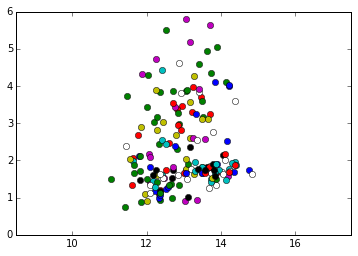

fold number: 0
178 40 3
------------------------------------------1 2---------------


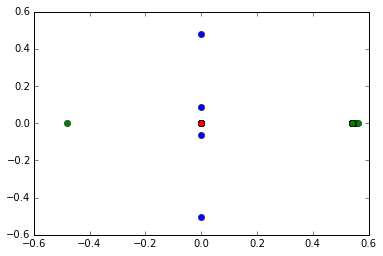

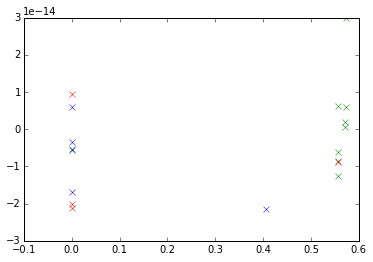

------------------------------------------3 4---------------


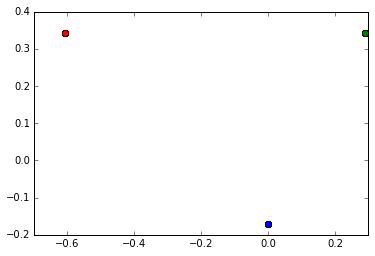

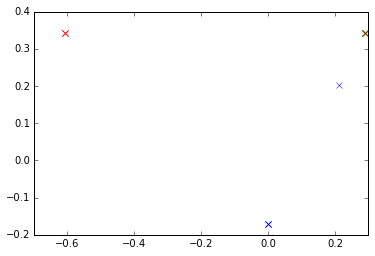

------------------------------------------5 6---------------


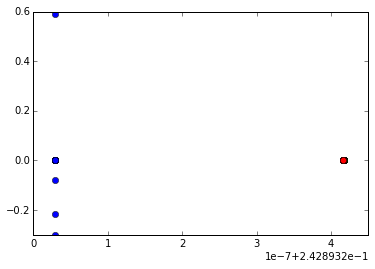

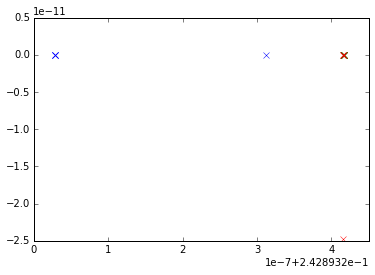

fold number: 1
178 40 3
------------------------------------------1 2---------------


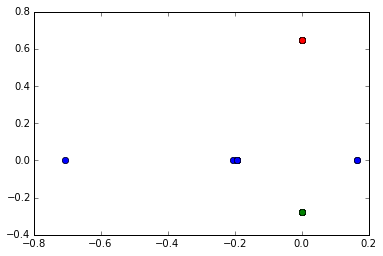

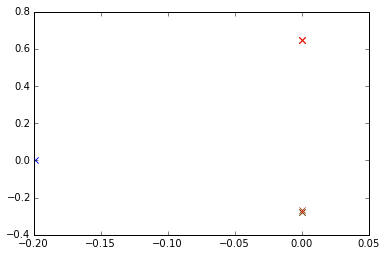

------------------------------------------3 4---------------


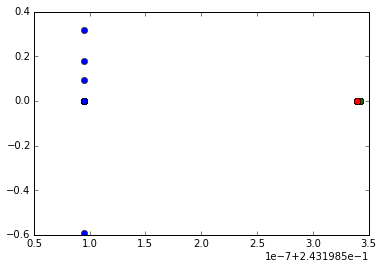

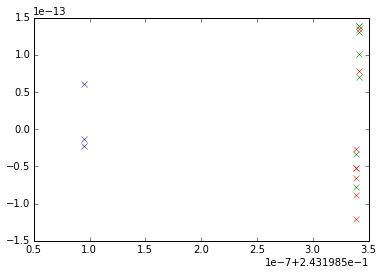

------------------------------------------5 6---------------


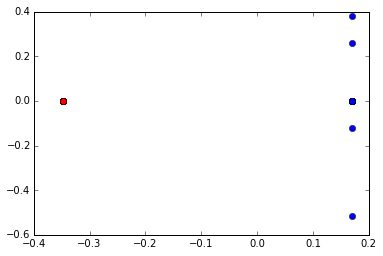

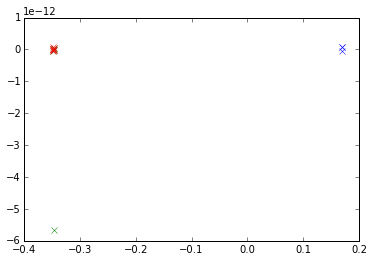

fold number: 2
178 40 3
------------------------------------------1 2---------------


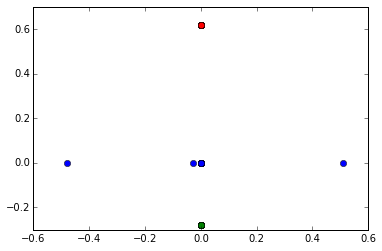

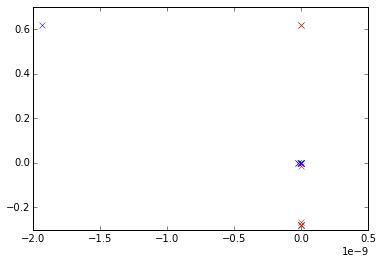

------------------------------------------3 4---------------


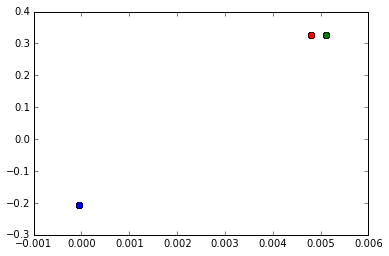

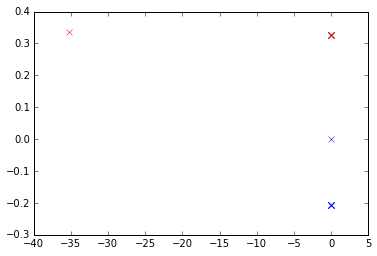

------------------------------------------5 6---------------


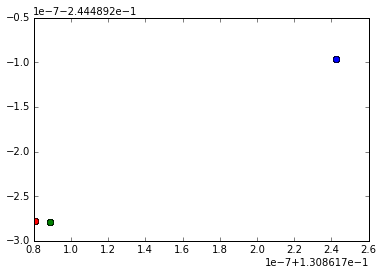

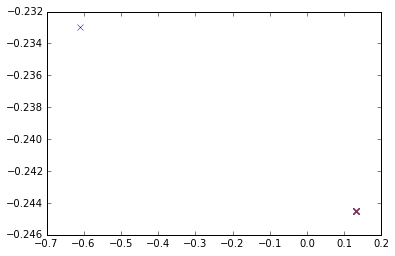

fold number: 3
178 40 3
------------------------------------------1 2---------------


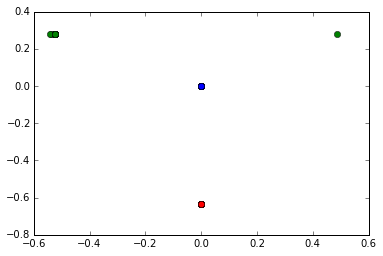

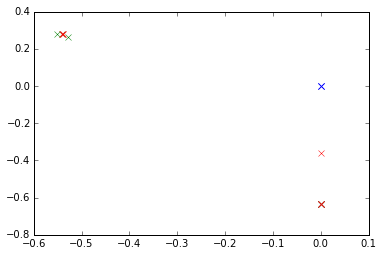

------------------------------------------3 4---------------


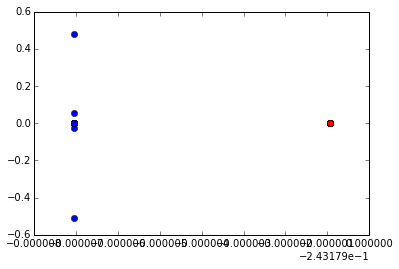

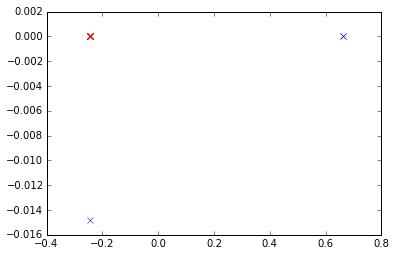

------------------------------------------5 6---------------


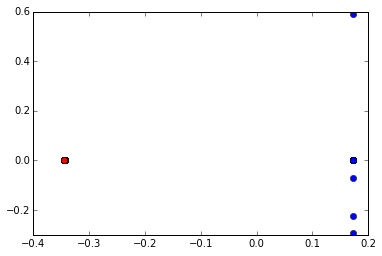

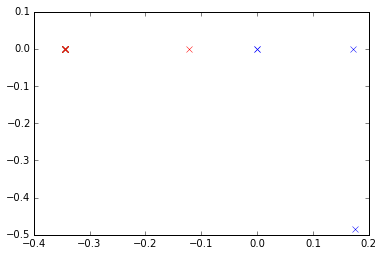

fold number: 4
178 40 3
------------------------------------------1 2---------------


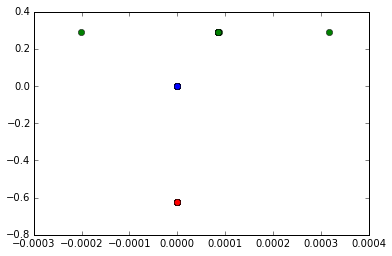

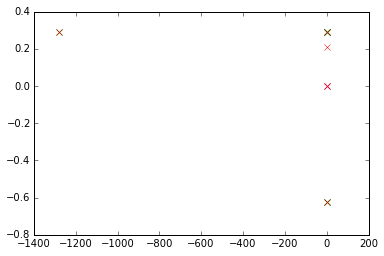

------------------------------------------3 4---------------


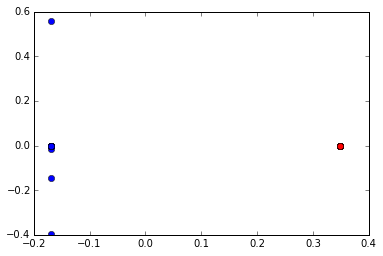

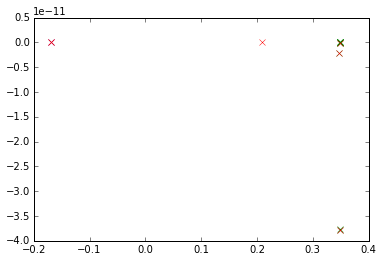

------------------------------------------5 6---------------


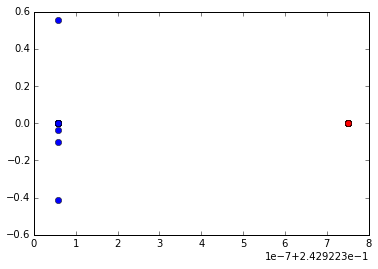

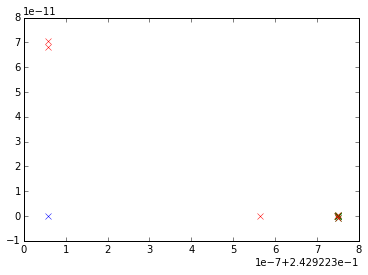

fold number: 5
178 40 3
------------------------------------------1 2---------------


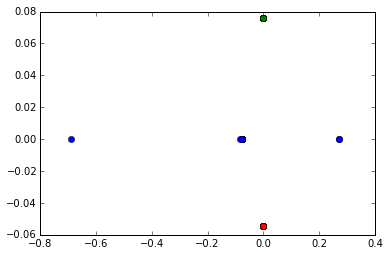

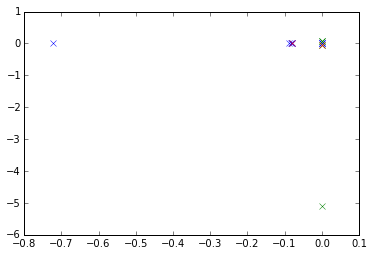

------------------------------------------3 4---------------


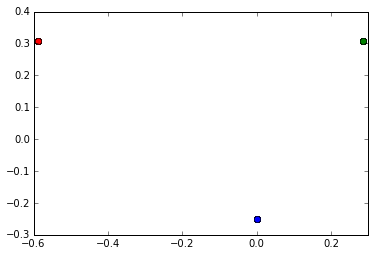

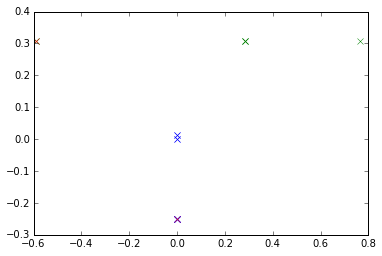

------------------------------------------5 6---------------


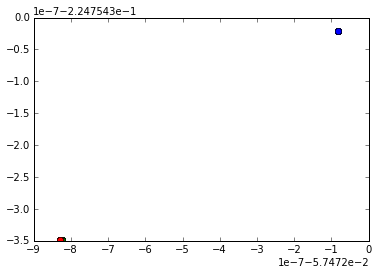

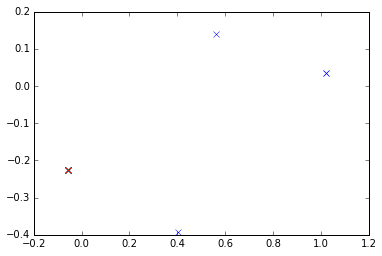

fold number: 6
178 40 3
------------------------------------------1 2---------------


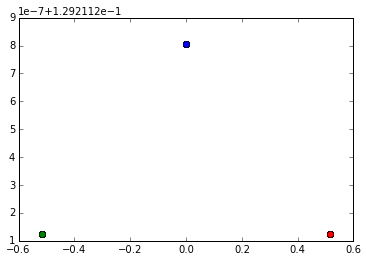

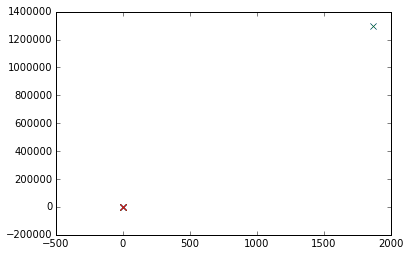

------------------------------------------3 4---------------


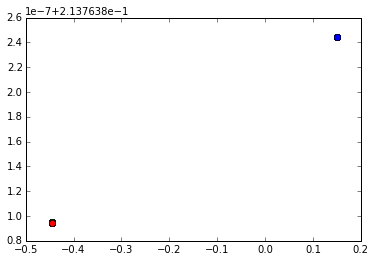

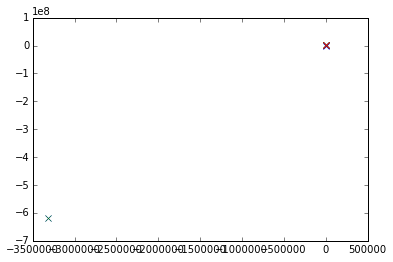

------------------------------------------5 6---------------


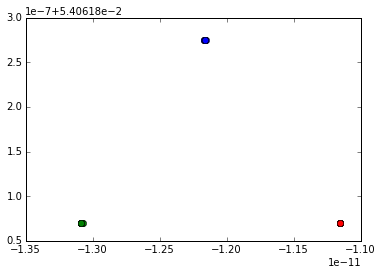

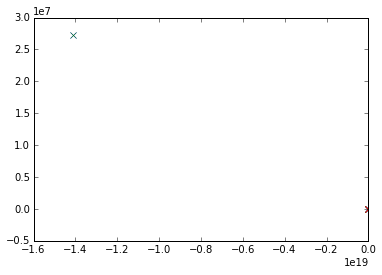

fold number: 7
178 40 3
------------------------------------------1 2---------------


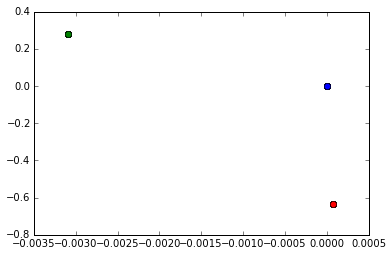

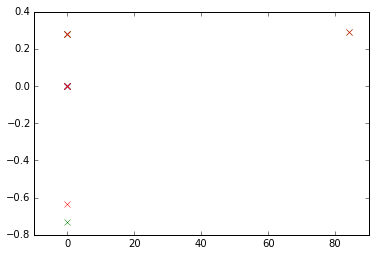

------------------------------------------3 4---------------


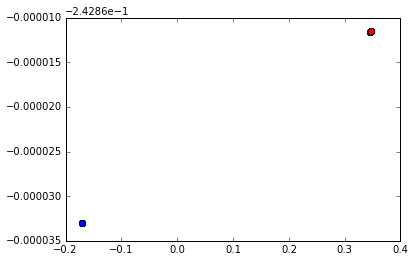

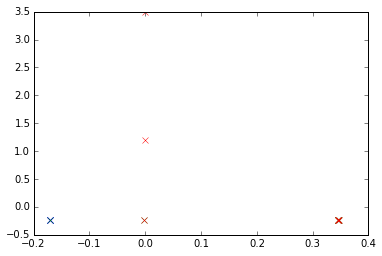

------------------------------------------5 6---------------


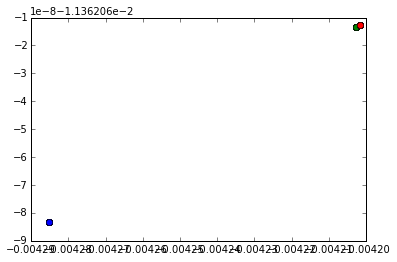

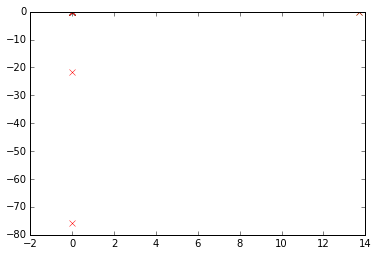

fold number: 8
178 40 3
------------------------------------------1 2---------------


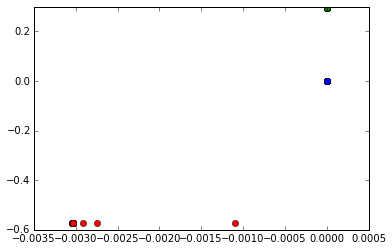

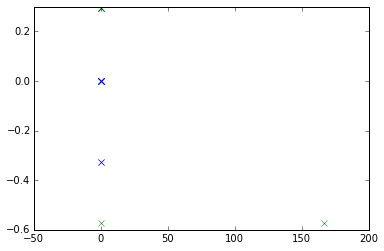

------------------------------------------3 4---------------


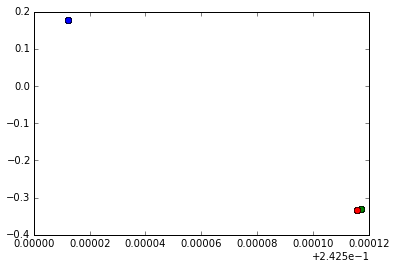

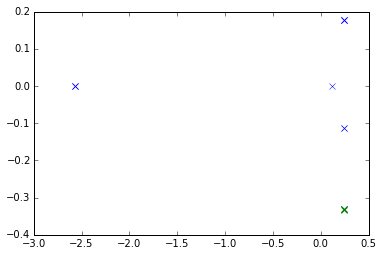

------------------------------------------5 6---------------


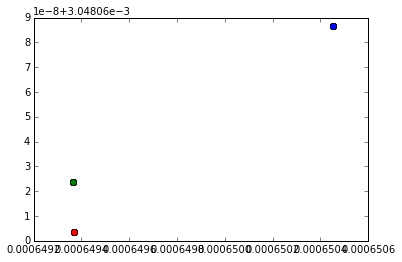

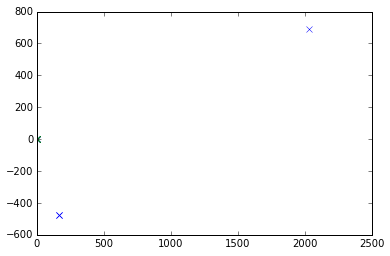

fold number: 9
178 40 3
------------------------------------------1 2---------------


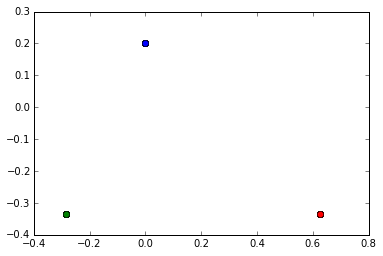

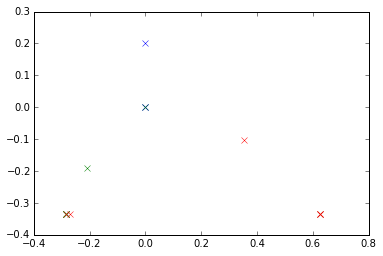

------------------------------------------3 4---------------


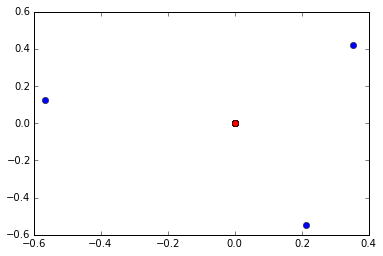

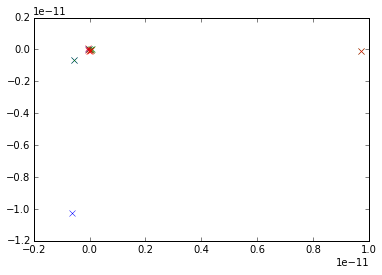

------------------------------------------5 6---------------


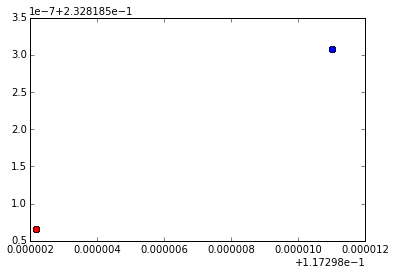

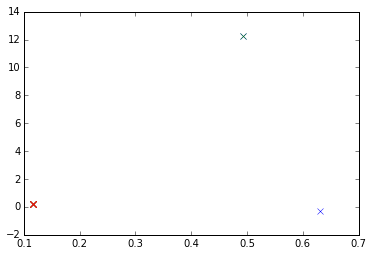

--------------------------------------- sigma:  0.7


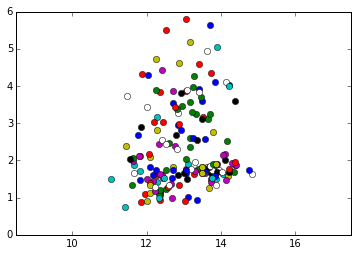

fold number: 0
178 40 3
------------------------------------------1 2---------------


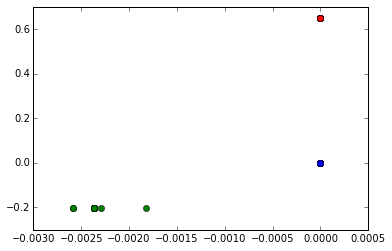

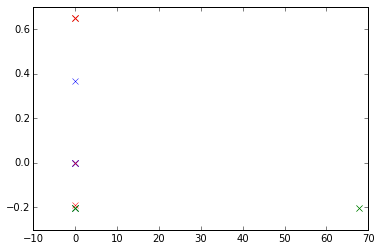

------------------------------------------3 4---------------


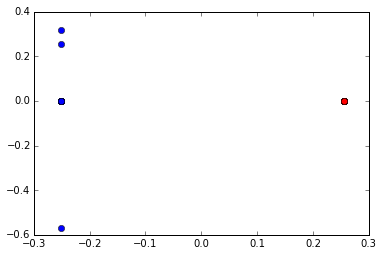

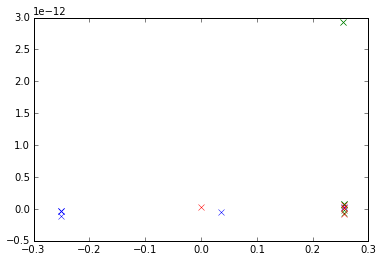

------------------------------------------5 6---------------


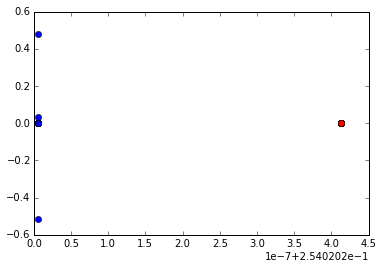

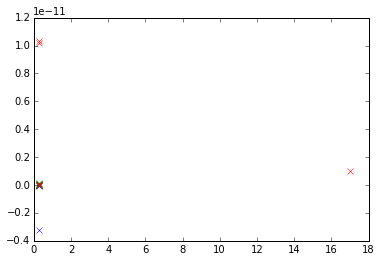

fold number: 1
178 40 3
------------------------------------------1 2---------------


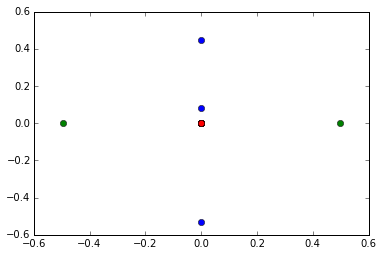

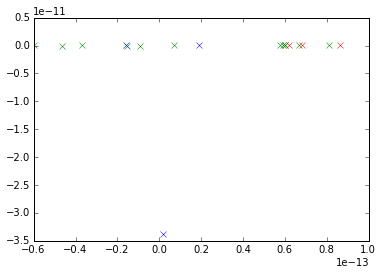

------------------------------------------3 4---------------


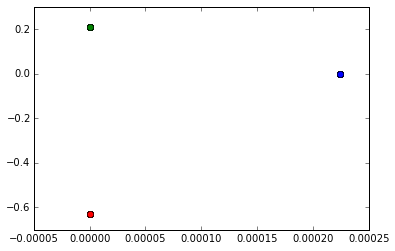

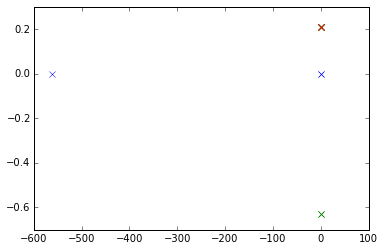

------------------------------------------5 6---------------


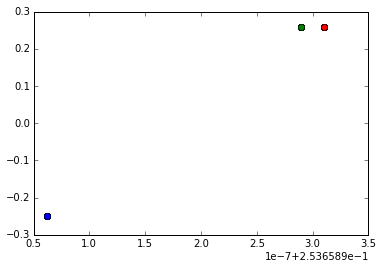

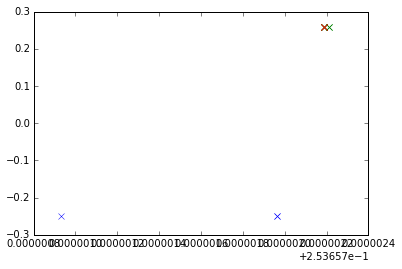

fold number: 2
178 40 3
------------------------------------------1 2---------------


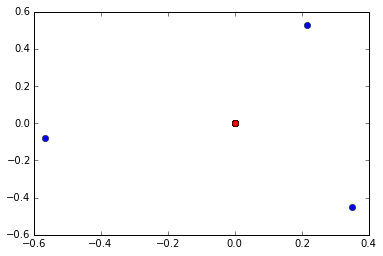

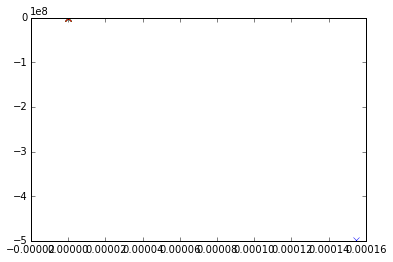

------------------------------------------3 4---------------


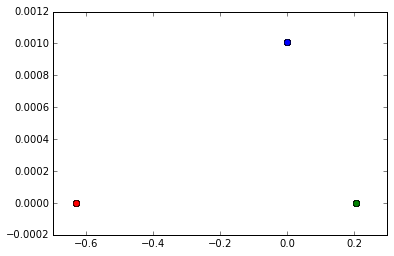

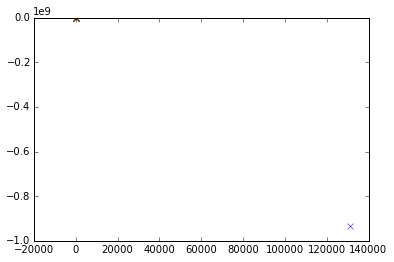

------------------------------------------5 6---------------


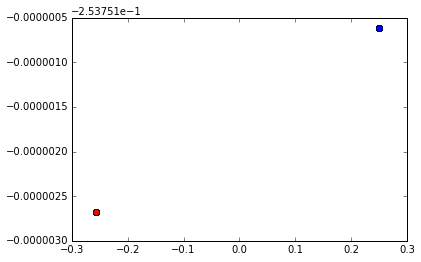

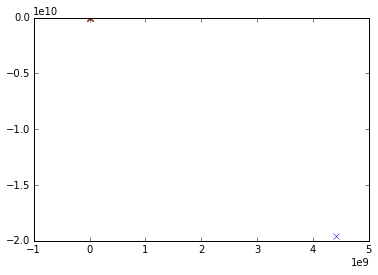

fold number: 3
178 40 3
------------------------------------------1 2---------------


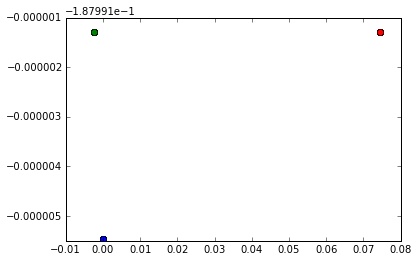

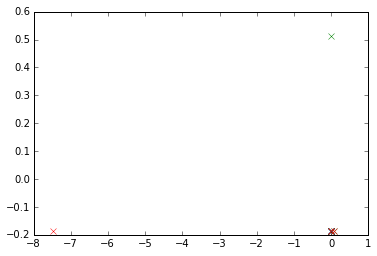

------------------------------------------3 4---------------


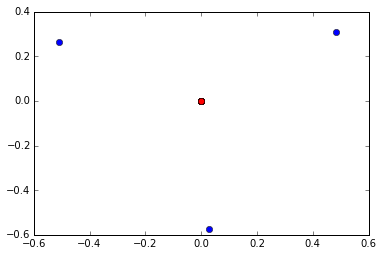

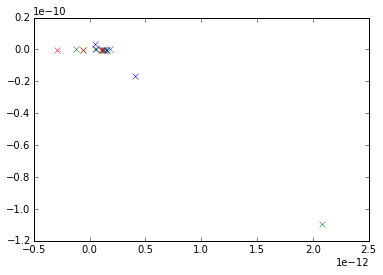

------------------------------------------5 6---------------


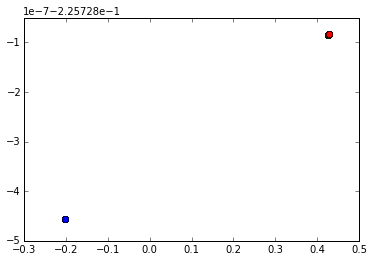

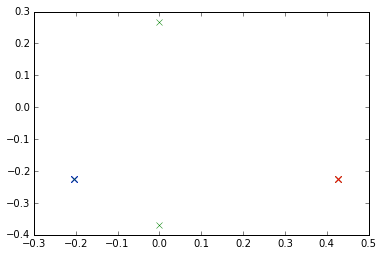

fold number: 4
178 40 3
------------------------------------------1 2---------------


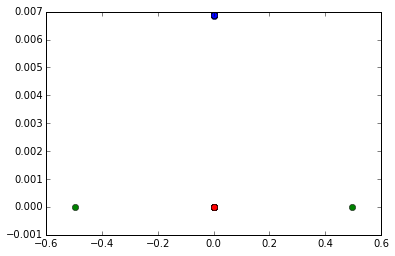

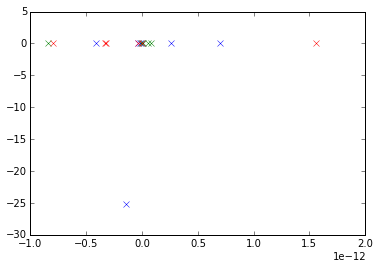

------------------------------------------3 4---------------


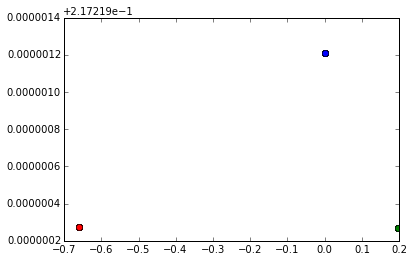

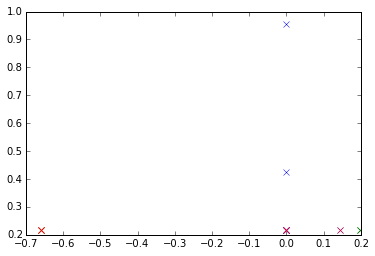

------------------------------------------5 6---------------


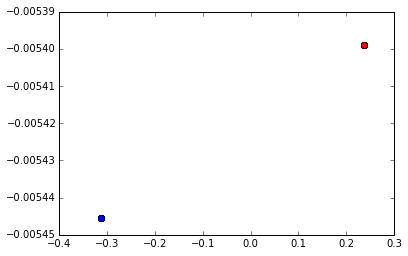

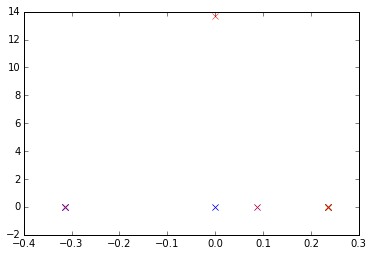

fold number: 5
178 40 3
------------------------------------------1 2---------------


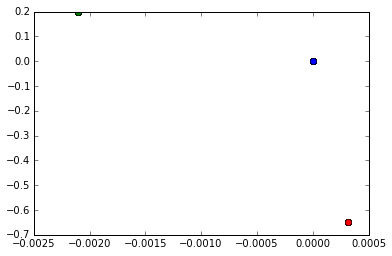

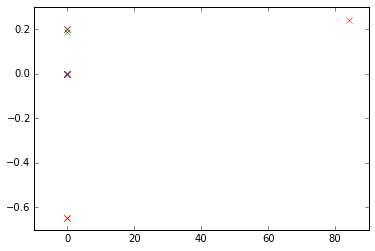

------------------------------------------3 4---------------


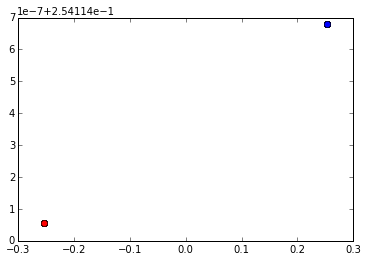

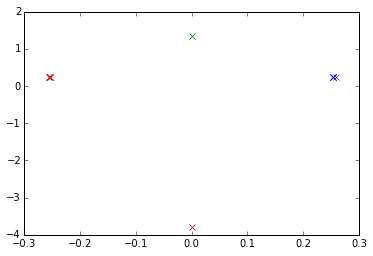

------------------------------------------5 6---------------


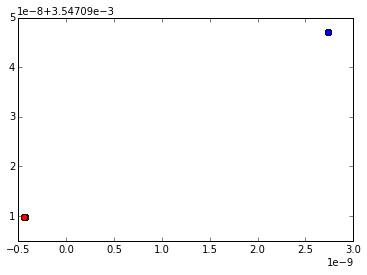

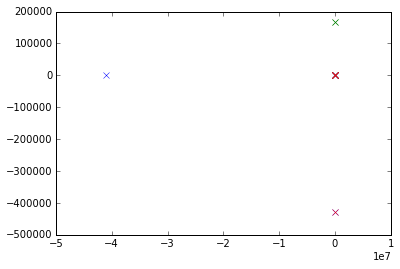

fold number: 6
178 40 3
------------------------------------------1 2---------------


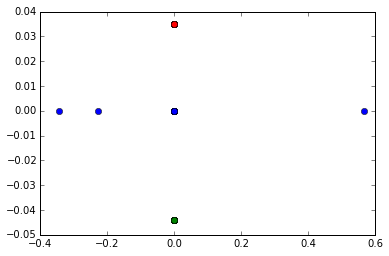

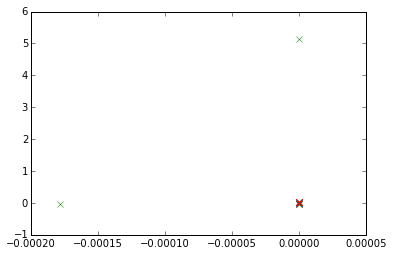

------------------------------------------3 4---------------


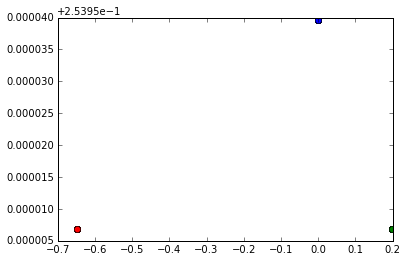

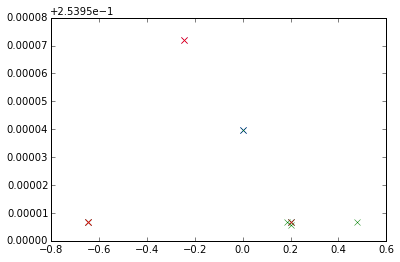

------------------------------------------5 6---------------


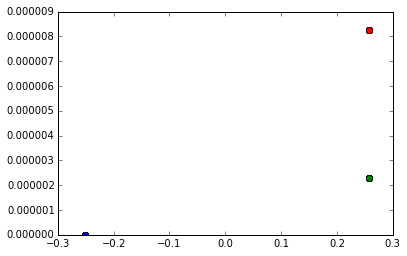

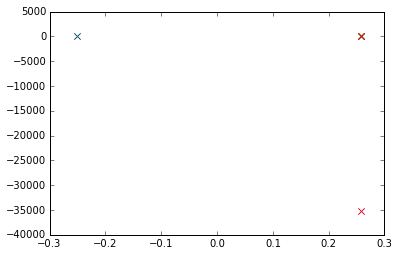

fold number: 7
178 40 3
------------------------------------------1 2---------------


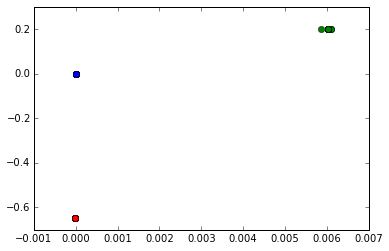

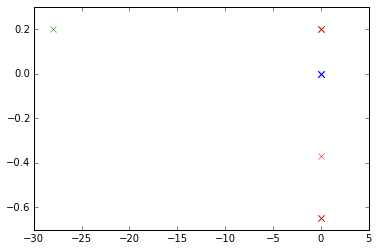

------------------------------------------3 4---------------


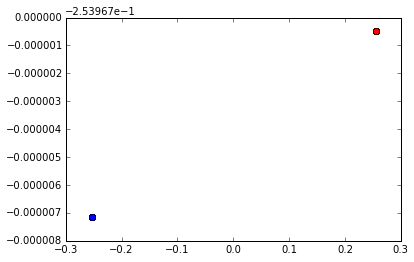

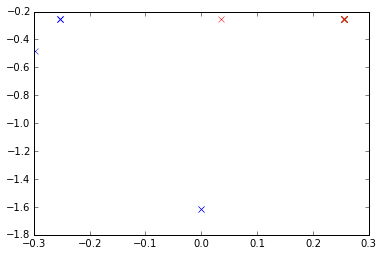

------------------------------------------5 6---------------


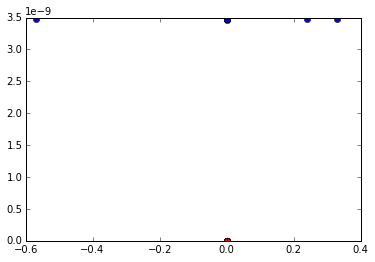

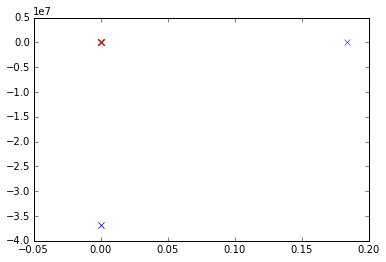

fold number: 8
178 40 3
------------------------------------------1 2---------------


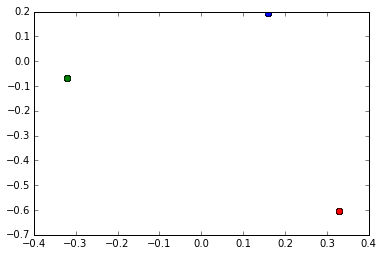

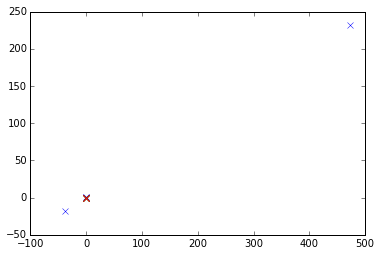

------------------------------------------3 4---------------
Traceback (most recent call last):
  File "c:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "c:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "c:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 285, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "c:\Anaconda\lib\site-packages\IPython\utils\ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "c:\Anaconda\lib\encodings\utf_8.py", line 16, in decode
    return codecs.utf_8_decode(input, errors, True)


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt



Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "c:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "c:\Anaconda\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\Anaconda\lib\site-packages\IPython\kernel\zmq\kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\Anaconda\lib\site-packages\IPython\kernel\zmq\kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\Anaconda\lib\site-packages\IPython\kernel\zmq\kernelbase.py", line 388, in execute_request
    self._abort_queues()
  File "c:\Anaconda\lib\site-packages\IPython\kernel\zmq\kernelbase.py", line 588, in _abort_queues
    self._abort_queue(stream)
  File "c:\Anaconda\lib\site-packages\IPython\kernel\zmq\kernelbase.py", line 611, in _abort_queue
    poller.poll(50)
  File

In [ ]:


results = []
resS = []
for iterator in xrange(10):
    sigmas = [.01,.02,.03,0.04,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]
    sonarX,sonarY = loadSonar()
    sonarMeans = runSigma(sonarX,sonarY,sigmas)
    results.append(sonarMeans.max())
    resS.append(sonarMeans.argmax())

In [ ]:
print results
print
print resS

In [ ]:
plt.plot(sigmas,sonarMeans,'bo-')

In [ ]:
print 'iris:',irisMeans.max()
print 'sonar:',sonarMeans.max()
print 'glass:',glassMeans.max()
print 'wine:',wineMeans.max()

<h1 style="color:red">Other methods<h1>

<h2 style="color:purple">LDA</h2>

In [45]:
from sklearn.lda import LDA
def LDA10Fold(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = LDA()
        clf.fit(X[train_index], yTrain)
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
#         NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        nclf.fit(newRepTrain,yTrain)
        XPred = nclf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
        print i,":",acc[i]
        i += 1
    return np.mean(acc), np.std(acc)

<h2 style="color:purple">PCA</h2>

In [46]:
from sklearn.decomposition import PCA
def PCA10Fold(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = PCA()
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
#         NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        nclf.fit(newRepTrain,yTrain)
        XPred = nclf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc), np.std(acc)

<h2 style="color:purple">Kernel PCA</h2>

In [47]:
from sklearn.decomposition import PCA, KernelPCA
def KPCA10Fold(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
#         NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        nclf.fit(newRepTrain,yTrain)
        XPred = nclf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc),np.std(acc)

<h2 style="color:purple">ICA</h2>

In [48]:
from sklearn.decomposition import FastICA
def ICA10Fold(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf =  FastICA()
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
#         NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        nclf.fit(newRepTrain,yTrain)
        XPred = nclf.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc), np.std(acc)

In [54]:
nclf = GaussianNB()
methods = [ICA10Fold,PCA10Fold,LDA10Fold,KPCA10Fold]
datasets = [loadUsps]#[loadWineNorm,loadGlass,loadIris,loadWdbc,loadWaveform,loadSonar]#,
for method in methods:
    for dat in datasets:
        X,y = dat()
        print method.__name__[:-6],",",dat.__name__[4:], ":",
        print method(X,y,nclf)

ICA , Usps : (0.79837965311836445, 0.015273750148278876)
PCA , Usps : (0.65875584869496584, 0.012214269599418926)
LDA , Usps : 0 : 0.915068493151
1 : 0.913580246914
2 : 0.936899862826
3 : 0.938271604938
4 : 0.913580246914
5 : 0.920438957476
6 : 0.927297668038
7 : 0.914951989026
8 : 0.921810699588
9 : 0.928669410151
(0.92305691790217403, 0.0088888920667993358)
KPCA , Usps : (0.13784429787473929, 0.0093269302478823767)


In [53]:
methods = [ICA10Fold,PCA10Fold,LDA10Fold,KPCA10Fold]
datasets = [generateTwoDisks,generateXOR,generateTwoParabola, generateConcentric]
for method in methods:
    for dat in datasets:
        X,y,tmp = dat()
        print method.__name__[:-6],",",dat.__name__[4:], ":",
        print method(X,y,nclf)

ICA , rateTwoDisks : (1.0, 0.0)
ICA , rateXOR : (0.38, 0.072284161474004793)
ICA , rateTwoParabola : (0.88500000000000001, 0.047368238303741032)
ICA , rateConcentric : (0.83094758064516117, 0.054618215550795629)
PCA , rateTwoDisks : (1.0, 0.0)
PCA , rateXOR : (0.65500000000000003, 0.1197914855071094)
PCA , rateTwoParabola : (0.91874999999999996, 0.024526771087935727)
PCA , rateConcentric : (0.81502016129032262, 0.087625395598674133)
LDA , rateTwoDisks : 0 : 0.797619047619
1 : 0.75
2 : 0.880952380952
3 : 0.77380952381
4 : 0.833333333333
5 : 0.77380952381
6 : 0.797619047619
7 : 0.809523809524
8 : 0.869047619048
9 : 0.845238095238
(0.81309523809523809, 0.040911524470094232)
LDA , rateXOR : 0 : 0.775
1 : 0.9
2 : 0.35
3 : 0.675
4 : 0.575
5 : 0.725
6 : 0.775
7 : 0.85
8 : 0.875
9 : 0.525
(0.70250000000000001, 0.16562382075051885)
LDA , rateTwoParabola : 0 : 0.85
1 : 0.925
2 : 0.9125
3 : 0.95
4 : 0.9
5 : 0.9125
6 : 0.8625
7 : 0.95
8 : 0.9125
9 : 0.95
(0.91249999999999987, 0.033071891388307365)

In [295]:
X,y = loadWine()
print LDA10Fold(X,y)

0 : 0.944444444444
1 : 1.0
2 : 1.0
3 : 1.0
4 : 0.888888888889
5 : 1.0
6 : 1.0
7 : 1.0
8 : 0.941176470588
9 : 1.0
0.977450980392


In [119]:
X,y,tmp = generateTwoParabola()
print LDA10Fold(X,y)

0 : 0.9
1 : 0.9
2 : 0.8125
3 : 0.8375
4 : 0.85
5 : 0.925
6 : 0.9625
7 : 0.85
8 : 0.8875
9 : 0.8625
0.87875


In [120]:
X,y,tmp = generateTwoDisks()
print LDA10Fold(X,y)

0 : 0.666666666667
1 : 0.678571428571
2 : 0.619047619048
3 : 0.75
4 : 0.666666666667
5 : 0.642857142857
6 : 0.72619047619
7 : 0.714285714286
8 : 0.690476190476
9 : 0.666666666667
0.682142857143


In [121]:
X,y,tmp = generateXOR()
print LDA10Fold(X,y)

0 : 0.65
1 : 0.75
2 : 0.75
3 : 0.6
4 : 0.875
5 : 0.575
6 : 0.825
7 : 0.75
8 : 0.475
9 : 0.55
0.68


In [122]:
for met in [generateTwoParabola,generateTwoDisks,generateXOR,generateConcentric]:
    for cls in [ICA10Fold,KPCA10Fold,PCA10Fold,LDA10Fold]:
        X,y,tmp = met()
        print tmp,cls.__name__
        print cls(X,y)

Parabolas ICA10Fold
1.0
Parabolas KPCA10Fold
0.7825
Parabolas PCA10Fold
1.0
Parabolas LDA10Fold
0 : 0.8375
1 : 0.9
2 : 0.8875
3 : 0.9
4 : 0.925
5 : 0.85
6 : 0.95
7 : 0.875
8 : 0.8375
9 : 0.85
0.88125
Disks ICA10Fold
1.0
Disks KPCA10Fold
0.483333333333
Disks PCA10Fold
1.0
Disks LDA10Fold
0 : 0.761904761905
1 : 0.690476190476
2 : 0.654761904762
3 : 0.654761904762
4 : 0.809523809524
5 : 0.75
6 : 0.642857142857
7 : 0.690476190476
8 : 0.75
9 : 0.702380952381
0.710714285714
XOR ICA10Fold
0.93
XOR KPCA10Fold
0.915
XOR PCA10Fold
0.9275
XOR LDA10Fold
0 : 0.75
1 : 0.7
2 : 0.4
3 : 0.525
4 : 0.65
5 : 0.775
6 : 0.85
7 : 0.775
8 : 0.85
9 : 0.625
0.69
Concentric ICA10Fold
0.936088709677
Concentric KPCA10Fold
0.71189516129
Concentric PCA10Fold
0.936290322581
Concentric LDA10Fold
0 : 0.75
1 : 0.75
2 : 0.71875
3 : 0.774193548387
4 : 0.838709677419
5 : 0.774193548387
6 : 0.741935483871
7 : 0.645161290323
8 : 0.709677419355
9 : 0.677419354839
0.738004032258


In [144]:
for cls in [ICA10Fold,KPCA10Fold,PCA10Fold,LDA10Fold]:
        X,y = loadWineNorm()
        print cls.__name__
        print cls(X,y)

ICA10Fold
0.859477124183
KPCA10Fold
0.938235294118
PCA10Fold
0.949673202614
LDA10Fold
0 : 1.0
1 : 1.0
2 : 1.0
3 : 0.944444444444
4 : 1.0
5 : 1.0
6 : 1.0
7 : 0.944444444444
8 : 1.0
9 : 1.0
0.988888888889


<h2 style="color:purple">Supervised PCA</h2>

In [ ]:
def SPCA1NN(X,y):
    n = y.shape[0]
    H = np.eye(n) - 1.0/n
    B = np.zeros((n,n))
    for i in xrange(n):
        for j in xrange(n):
            if y[i] == y[j]:
                B[i,j] = 1
    Q = np.dot(X.T,H)
    Q = np.dot(Q,B)
    Q = np.dot(Q,H)
    Q = np.dot(Q,X)
    U,S,V = np.linalg.svd(Q)
    newRep = np.dot(np.dot(U[:4],X.T),H).T
    NN = neighbors.KNeighborsClassifier()
    NN.fit(newRep,y)
    XPred = NN.predict(newRep)
    return np.sum(XPred==y)*1.0/y.shape[0]

In [117]:
from sklearn.decomposition import FastICA
def ICA1NN(X,y):
    numS = X.shape[0]
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    acc = []
    for train_index,test_index in kf:
        ica = FastICA()
        X_ica = ica.fit(X[train_index])
        X_test = ica.transform(X[test_index])
        NN = neighbors.KNeighborsClassifier()
        NN.fit(X_ica,y)
        XPred = NN.predict(X_test)
        acc.append(np.sum(XPred==y[test_index])*1.0/y[test_index].shape[0])
        print acc[i]
        i += 1
    return np.mean(acc)

<h2 style="color:red">-------------------- NMI -------------------</h2>

In [99]:
def supervised10FoldNMI(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    numClass = len(np.unique(sorted(y)))
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
       
        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))
    
        i += 1
    return np.mean(acc), np.std(acc) 

In [103]:
def runSigmaNMI(X,Y,sigmas):
    Stds = np.zeros(len(sigmas))
    Means = np.zeros(len(sigmas))
    numP = 30
    idx = 0
    for sigma in sigmas:
#         print '--------------------------------------- sigma: ',sigma
        try:
            Means[idx],Stds[idx] = supervised10FoldNMI(X,Y,numP,sigma)
        except Exception as e:
            print e
        idx += 1
#         Means[idx] = supervised10FoldRepresentation(wineX,wineY,1)
    return Means,Stds

In [112]:
def run10FoldNMI(X,y,sigmas):
    result = []
    resultStd = []
    for i in xrange(10):
        Means,Stds = runSigmaNMI(X,y,sigmas)
        result.append(Means.max())
        resultStd.append(Stds[Means.argmax()])
        print i , Means.max(),Stds[Means.argmax()]
        print 'sigma:', sigmas[Means.argmax()]
    return result,resultStd

In [114]:
sigmas = [.05,.07,.08,.09,.1,.11,.12,.13,.15,.2,.25]
wineX,wineY = loadWineNorm()

wineResult,wineResultStd = run10FoldNMI(wineX,wineY,sigmas)

0 0.761088508878 0.0999789314202
sigma: 0.15
1 0.821699462304 0.114318949586
sigma: 0.09
2 0.843516575966 0.225064638255
sigma: 0.1
3 0.865575027608 0.0969030595848
sigma: 0.1
4 0.87401635378 0.147332374784
sigma: 0.1
5 0.768939938634 0.152872652511
sigma: 0.1
6 0.831682807553 0.125454060465
sigma: 0.13
7 0.753665016564 0.159845013408
sigma: 0.15
8 0.814140188488 0.129704909165
sigma: 0.11
9 0.859979905875 0.164427129359
sigma: 0.11


In [115]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
irisX,irisY = loadIris()
irisResult,irisResultStd = run10FoldNMI(irisX,irisY,sigmas)

Factor is exactly singular
Factor is exactly singular
0 0.632464899229 0.251617164606
sigma: 0.2
Factor is exactly singular
Factor is exactly singular
1 0.623041019705 0.267702377384
sigma: 0.2
Factor is exactly singular
Factor is exactly singular
2 0.717088416525 0.101452414037
sigma: 0.05
Factor is exactly singular
Factor is exactly singular
3 0.632614883067 0.220879496834
sigma: 0.2
Factor is exactly singular
Factor is exactly singular
4 0.763697577954 0.269381299466
sigma: 0.1
Factor is exactly singular
Factor is exactly singular
5 0.781389790573 0.072042986856
sigma: 0.2
Factor is exactly singular
Factor is exactly singular
6 0.70342843114 0.103760450731
sigma: 0.2
Factor is exactly singular
Factor is exactly singular
7 0.712490021924 0.282110919823
sigma: 0.1
Factor is exactly singular
Factor is exactly singular
8 0.80070357295 0.148377298403
sigma: 0.1
Factor is exactly singular
Factor is exactly singular
9 0.71362715408 0.176757387641
sigma: 0.05


In [116]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassX,glassY = loadGlass()
glassResult,glassResultStd = run10FoldNMI(glassX,glassY,sigmas)

0 0.592751931601 0.0559409746494
sigma: 5
1 0.586202620989 0.0687053973422
sigma: 0.5
2 0.581465863769 0.0803859475917
sigma: 0.8
3 0.575020521594 0.0716402409666
sigma: 2
4 0.587058293157 0.108198749995
sigma: 0.5
5 0.601496897213 0.113862443667
sigma: 0.5
6 0.582870882208 0.1076007125
sigma: 8
7 0.591043498557 0.0791496631054
sigma: 0.8
8 0.597858649039 0.07695421953
sigma: 2
9 0.582067588742 0.0993300956289
sigma: 1


In [117]:
sigmas = [10,11,12,15,20,21,22,23,24,25,26,27,28,29,30,35]
wdbcX,wdbcY = loadWdbc()
wdbcResult,wdbcResultStd = run10FoldNMI(wdbcX,wdbcY,sigmas)

0 0.49558500044 0.285706183968
sigma: 20
1 0.351146910474 0.270193241508
sigma: 11
2 0.337589295423 0.234755240278
sigma: 11
3 0.361848880571 0.207216738466
sigma: 15
4 0.318319767457 0.23237758445
sigma: 21
5 0.393163895687 0.315815244602
sigma: 12
6 0.421443165265 0.309994530784
sigma: 12
7 0.401636375252 0.277336740728
sigma: 12
8 0.390659999264 0.202878110985
sigma: 11
9 0.422426842299 0.272385372239
sigma: 15


In [118]:
sigmas = [1,2,5,10,15,20,24,30,35]
moonX,moonY, tmp = generateTwoParabola()
moonResult,moonResultStd = run10FoldNMI(moonX,moonY,sigmas)

0 0.609358412472 0.0984463242631
sigma: 20
1 0.609887167197 0.127258032079
sigma: 35
2 0.610547097442 0.118400671496
sigma: 35
3 0.626438678753 0.0735320840446
sigma: 24
4 0.612730053523 0.109621115386
sigma: 30
5 0.61084188336 0.105637724966
sigma: 35
6 0.613051857834 0.14882635533
sigma: 35
7 0.593523355968 0.0764356253354
sigma: 35
8 0.604530112965 0.141016537412
sigma: 35
9 0.610336371297 0.103543084551
sigma: 30


In [119]:
sigmas = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,5]
xorX,xorY,tmp = generateXOR()
xorResult,xorResultStd = run10FoldNMI(xorX,xorY,sigmas)

0 0.435988570466 0.155976920478
sigma: 5
1 0.544221782843 0.278273147979
sigma: 5
2 0.557697225522 0.189894383643
sigma: 5
3 0.543098379364 0.161146388154
sigma: 5
4 0.44853251347 0.344266938833
sigma: 0.1
5 0.483665698205 0.216198022509
sigma: 5
6 0.519644981202 0.221010283374
sigma: 5
7 0.479243190219 0.284827841
sigma: 5
8 0.47430158807 0.228415527654
sigma: 5
9 0.479756217841 0.178099221644
sigma: 5


In [120]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    X = concentric['X'][:,[0,1]]
    Y = concentric['Y'][:,0]
    Y = (Y==1)
    return X,Y,"Concentric"

In [121]:
sigmas = [.4,.5,.7,.8,.9,1,1.1,1.2,1.3,1.5]
concentricX,concentricY,tmp = generateConcentric()
concentricResult,concentricResultStd = run10FoldNMI(concentricX,concentricY,sigmas)

0 0.151782836617 0.0740628137946
sigma: 0.5
1 0.1723865962 0.0745133208405
sigma: 0.5
2 0.167704248347 0.0486436838052
sigma: 1.1
3 0.136202169068 0.068073992427
sigma: 0.9
4 0.178393303482 0.107278447393
sigma: 0.4
5 0.168125238858 0.0835929441175
sigma: 0.5
6 0.136508495541 0.050124390956
sigma: 0.8
7 0.176444040167 0.0732877285256
sigma: 1.5
8 0.153674377274 0.0697665598383
sigma: 1.1
9 0.152176416904 0.0313026635123
sigma: 1.2


In [122]:
sigmas = [.2,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,2.5,3,4,5,7,8,10]
waveformX,waveformY= loadWaveform()
waveformResult,waveformResultStd = run10FoldNMI(waveformX,waveformY,sigmas)

0 0.298401741342 0.0826476648936
sigma: 1.5
1 0.334197724022 0.0878408764076
sigma: 2
2 0.328591209717 0.0623278428848
sigma: 1.5
3 0.318725813988 0.071157475503
sigma: 1.5
4 0.334781547719 0.0772144341229
sigma: 2.5
5 0.288851911759 0.0567708825631
sigma: 1.5
6 0.337038428458 0.0826712865536
sigma: 2
7 0.3330915023 0.0615342495268
sigma: 2.5
8 0.3004482683 0.0756168578338
sigma: 2.5
9 0.326931985338 0.0497967575906
sigma: 2


In [123]:
sigmas = [.5,1,1.5,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,10]
uspsX,uspsY = loadUsps()
uspsResult,uspsResultStd = run10FoldNMI(uspsX,uspsY,sigmas)

0 0.76950886832 0.0157235934265
sigma: 1.7
1 0.768783502735 0.0167902156459
sigma: 1.9
ARPACK error -1: No convergence (73311 iterations, 5/7 eigenvectors converged)
2 0.769505049584 0.0119841894745
sigma: 1.9
ARPACK error -1: No convergence (73311 iterations, 5/7 eigenvectors converged)
3 0.767047578923 0.018302349957
sigma: 2
ARPACK error -1: No convergence (73311 iterations, 2/7 eigenvectors converged)
4 0.77078393809 0.0214291253382
sigma: 1.7
ARPACK error -1: No convergence (73311 iterations, 4/7 eigenvectors converged)
5 0.775689878528 0.0177285852852
sigma: 1.7
6 0.771561752977 0.0148368778229
sigma: 1.7
ARPACK error -1: No convergence (73311 iterations, 3/7 eigenvectors converged)
7 0.76732852732 0.0141810398713
sigma: 1.8
ARPACK error -1: No convergence (73311 iterations, 1/7 eigenvectors converged)
8 0.769946901185 0.0156753347327
sigma: 1.8
9 0.770451269409 0.0193801863878
sigma: 1.8


<h2 style="color:purple">PCA</h2>

In [124]:
from sklearn.decomposition import PCA
def PCA10FoldNMI(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    numClass = len(np.unique(sorted(y)))
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = PCA()
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])

        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))
        
        
        i += 1
    return np.mean(acc), np.std(acc)

<h2 style="color:purple">Kernel PCA</h2>

In [125]:
from sklearn.decomposition import PCA, KernelPCA
def KPCA10FoldNMI(X,y):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    numClass = len(np.unique(sorted(y)))
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
        
        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))

        i += 1
    return np.mean(acc),np.std(acc)

<h2 style="color:purple">ICA</h2>

In [126]:
from sklearn.decomposition import FastICA
def ICA10FoldNMI(X,y,nclf):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    numClass = len(np.unique(sorted(y)))
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf =  FastICA()
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])

        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))
        
        i += 1
    return np.mean(acc), np.std(acc)

<h2 style="color:purple">LDA</h2>

In [127]:
from sklearn.lda import LDA
def LDA10FoldNMI(X,y):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    numClass = len(np.unique(sorted(y)))
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = LDA()
        clf.fit(X[train_index], yTrain)
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
        
        kmeans = KMeans(init='k-means++',n_clusters=numClass)
        kmeans.fit(newRepTest)
        acc.append(NMI(kmeans.labels_,yTest))
        
        print i,":",acc[i]
        i += 1
    return np.mean(acc), np.std(acc)

In [128]:
methods = [ICA10FoldNMI,PCA10FoldNMI,LDA10FoldNMI,KPCA10FoldNMI]
datasets = [generateTwoDisks,generateXOR,generateTwoParabola, generateConcentric,loadWineNorm,loadGlass,loadIris,loadWdbc,loadSonar,loadWaveform,loadUsps]
for method in methods:
    for dat in datasets:
        X,y,tmp = dat()
        print method.__name__[:-6],",",dat.__name__[4:], ":",
        print method(X,y)

ICA10F , rateTwoDisks :

TypeError: ICA10FoldNMI() takes exactly 3 arguments (2 given)